<a href="https://colab.research.google.com/github/sa-hs/Modelos-de-aprendizaje-estadistico/blob/main/Completo_Final_s_relaci%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Código para realizar simulaciones en datos de seguro de autos usando una **variable de respuesta que no tiene relación** con las  variables de la base de datos.

**Simulación con desbalance:**

+ 75-25%
+ 85-15%
+ 95-5%

**Modelos:**
+ Bosques aleatrios
+ Logistico
+ GBM

**Variantes de smote:**
+ smote ENN
+ smote TL
+ Stable smote

**Métricas:**
+ Accuracy
+ MCC-F1

# Funciones necesarias

---



In [ ]:
!pip install feature-engine

In [ ]:
pip install smote-variants

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from collections import Counter
from sklearn.metrics import matthews_corrcoef
from feature_engine.encoding import MeanEncoder
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.metrics import f1_score
from scipy.stats import randint
from sklearn.metrics import precision_recall_curve, auc
import os


# Modelos
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

# Variantes smote
import smote_variants as sv


**Stable SMOTE**

In [ ]:
# Stable SMOTE
class stable_SMOTE:
    def __init__(self, z_nearest=5, target_ratio=0.5):
        self.z_nearest = z_nearest
        self.target_ratio = target_ratio


    def fit_sample(self, x_dataset):
        x_dataset = pd.DataFrame(x_dataset)

        total_pair = []

        defective_instance = x_dataset[x_dataset["Class"] == 1]
        clean_instance = x_dataset[x_dataset["Class"] == 0]

        defective_number = len(defective_instance)
        clean_number = len(clean_instance)
        target_defect_ratio = 0.5
        need_number = int((target_defect_ratio * len(x_dataset) - defective_number) / (1 - target_defect_ratio))

        print(f"Número de instancias minoritarias necesarias: {need_number}")

        if need_number <= 0:
            print("No se necesitan instancias sintéticas. ")
            return x_dataset # Devolver el dataset original en lugar de False


        generated_dataset = []
        number_on_each_instance = need_number / defective_number
        total_pair = []

        rround = number_on_each_instance / self.z_nearest

        while rround >= 1:
            for index, row in defective_instance.iterrows():
                temp_defective_instance = defective_instance.copy(deep=True)
                subtraction = row - temp_defective_instance
                square = subtraction ** 2
                row_sum = square.apply(lambda s: s.sum(), axis=1)
                distance = row_sum ** 0.5
                temp_defective_instance["distance"] = distance
                temp_defective_instance = temp_defective_instance.sort_values(by="distance", ascending=True)
                neighbors = temp_defective_instance[1:self.z_nearest + 1]
                for a, r in neighbors.iterrows():
                    selected_pair = [index, a]
                    selected_pair.sort()
                    total_pair.append(selected_pair)
            rround = rround - 1

        need_number1 = need_number - len(total_pair)
        number_on_each_instance = need_number1 / defective_number

        for index, row in defective_instance.iterrows():
            temp_defective_instance = defective_instance.copy(deep=True)
            subtraction = row - temp_defective_instance
            square = subtraction ** 2
            row_sum = square.apply(lambda s: s.sum(), axis=1)
            distance = row_sum ** 0.5
            temp_defective_instance["distance"] = distance
            temp_defective_instance = temp_defective_instance.sort_values(by="distance", ascending=True)
            neighbors = temp_defective_instance[1:self.z_nearest + 1]
            neighbors = neighbors.sort_values(by="distance", ascending=False)
            target_sample_instance = neighbors[0: int(number_on_each_instance)]
            target_sample_instance = target_sample_instance.drop(columns="distance")

            for a, r in target_sample_instance.iterrows():
                selected_pair = [index, a]
                selected_pair.sort()
                total_pair.append(selected_pair)

        temp_defective_instance = defective_instance.copy(deep=True)
        residue_number = need_number - len(total_pair)
        if residue_number > 0:
            residue_defective_instance = temp_defective_instance.sample(n=residue_number)

            for index, row in residue_defective_instance.iterrows():
                temp_defective_instance = defective_instance.copy(deep=True)
                subtraction = row - temp_defective_instance
                square = subtraction ** 2
                row_sum = square.apply(lambda s: s.sum(), axis=1)
                distance = row_sum ** 0.5
                temp_defective_instance["distance"] = distance
                temp_defective_instance = temp_defective_instance.sort_values(by="distance", ascending=True)
                neighbors = temp_defective_instance[1:self.z_nearest + 1]
                target_sample_instance = neighbors[-1:]

                for a in target_sample_instance.index:
                    selected_pair = [index, a]
                    selected_pair.sort()
                    total_pair.append(selected_pair)

        total_pair_tuple = [tuple(l) for l in total_pair]
        result = Counter(total_pair_tuple)
        result_number = len(result)
        result_keys = result.keys()
        result_values = result.values()

        for f in range(result_number):
            current_pair = list(result_keys)[f]
            row1_index = current_pair[0]
            row2_index = current_pair[1]
            row1 = defective_instance.loc[row1_index]
            row2 = defective_instance.loc[row2_index]
            generated_num = list(result_values)[f]
            generated_instances = np.linspace(row1, row2, generated_num + 2)
            generated_instances = generated_instances[1:-1]
            generated_instances = generated_instances.tolist()
            for w in generated_instances:
                generated_dataset.append(w)

        final_generated_dataset = pd.DataFrame(data=generated_dataset, columns=clean_instance.columns)
        final_generated_dataset = final_generated_dataset.astype(clean_instance.dtypes.to_dict())

        result = pd.concat([clean_instance, defective_instance, final_generated_dataset], axis=0)
        result.reset_index(drop=True, inplace=True)
        return result

**MCC-F1 Metric**

In [ ]:
# Graficar la métrica MCC-F1

def mcc_f1_curve(y_true, y_scores, graficar=None):
    thresholds = np.unique(y_scores) # Calcular la curva MCC-F1 para diferentes umbrales.
    mccs, f1s = [], []
    for t in thresholds: # generar predicciones binarias respecto a t quitando  0's
        y_pred = (y_scores >= t).astype(int)
        try:
            mcc = matthews_corrcoef(y_true, y_pred)
        except:
            mcc = 0.0
        try:
            f1 = f1_score(y_true, y_pred)
        except:
            f1 = 0.0
        mccs.append(mcc)
        f1s.append(f1)

    mcc_arr = np.array(mccs)
    f1_arr = np.array(f1s)

    # Normalizar MCC a un rango entre 0 y 1
    mcc_norm = (mcc_arr + 1) / 2

    # Graficar
    if graficar is not None:
      plt.figure(figsize=(10, 10))
      plt.plot(mcc_norm, f1_arr, marker='o', linestyle='-', color='purple', alpha=0.7)
      plt.scatter([1], [1], color='green', label='Perfect performance (1,1)', zorder=5)
      plt.title('MCC-F1 Curve')
      plt.xlabel('Normalized MCC')
      plt.ylabel('F1 Score')
      plt.grid(True)
      plt.legend()
      plt.axis([0, 1, 0, 1])
      plt.gca().set_aspect('equal', adjustable='box')
      plt.show()


    return thresholds, mcc_norm, f1_arr


In [ ]:
def best_threshold(thresholds, mcc_norm, f1_arr):
    dists = np.sqrt((1 - mcc_norm)**2 + (1 - f1_arr)**2)
    best_idx = int(np.argmin(dists))
    return thresholds[best_idx], mcc_norm[best_idx], f1_arr[best_idx]

In [ ]:
# Calcular la métrica MCC-F1 como la distancia promedio desde los puntos
def mcc_f1_metric(mcc_norm, f1_arr, thresholds, W=100):
    mcc_norm = np.array(mcc_norm)
    f1_arr = np.array(f1_arr)
    thresholds = np.array(thresholds)

    # Distancia Euclidiana a (1,1) para cada punto
    distances = np.sqrt((1 - mcc_norm)**2 + (1 - f1_arr)**2)

    # Encontrar índice del mejor punto
    best_idx = np.argmin(distances)
    T_best = thresholds[best_idx]  # Umbral óptimo

    # Dividir en lado izquierdo (L: threshold >= T_best) y derecho (R: threshold < T_best)
    left_mask = thresholds >= T_best
    right_mask = thresholds < T_best

    sides = {'L': left_mask, 'R': right_mask}
    min_x = np.min(mcc_norm)
    max_x = np.max(mcc_norm)
    w = (max_x - min_x) / W

    D_sj_list = []
    for side, mask in sides.items():
        side_mcc = mcc_norm[mask]
        side_f1 = f1_arr[mask]
        side_dist = distances[mask]

        for j in range(W):
            low = min_x + j * w
            high = low + w if j < W - 1 else max_x

            idx = (side_mcc >= low) & (side_mcc < high) if j < W - 1 else (side_mcc >= low) & (side_mcc <= high)
            if np.any(idx):
                D_sj = np.mean(side_dist[idx])  # Ecuación 12
                D_sj_list.append(D_sj)

    # Ecuación 14: Promedio de distancias medias en ambos lados
    D_estrella = np.mean(D_sj_list)

    # Ecuación 15: Normalización final
    MCC_F1 = 1 - (D_estrella / np.sqrt(2))
    return MCC_F1


**Reducir porcentaje de una clase**

---



In [ ]:
def reduce_class_2(datos, reduction_percentage):
    """
    Reduce la cantidad de datos de la clase 2 en el porcentaje requerido
    """
    # Separar los datos por clase
    class_1_data = datos[datos['Class'] == 0]
    class_2_data = datos[datos['Class'] == 1]

    # Calcular cuántos datos mantener de la clase 2
    n_keep = int(len(class_2_data) * (1 - reduction_percentage))

    # Seleccionar aleatoriamente los datos a mantener de la clase 2
    class_2_reduced = class_2_data.sample(n=n_keep, random_state=42)

    df_reduced = pd.concat([class_1_data, class_2_reduced])

    # Resetear el índice
    df_reduced = df_reduced.reset_index(drop=True)

    return df_reduced

**Validación Cruzada con  SMOTE**

---



In [ ]:
def aplicar_validacion_cruzada_smote(df_reduced, smote_type, modelo_type, n_splits=10):
    features = [col for col in df_reduced.columns if col != 'Class']
    X = df_reduced[features].copy()
    y = df_reduced['Class'].copy()

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    scaler = StandardScaler()

    # Selección del modelo
    if modelo_type == 'rf':
        modelo = RandomForestClassifier(random_state=42)
    elif modelo_type == 'gbm':
        modelo = GradientBoostingClassifier(random_state=42)
    elif modelo_type == 'logit':
        modelo = LogisticRegression(max_iter=100, solver='liblinear', random_state=42)
    else:
        raise ValueError(f"Modelo '{modelo_type}' no reconocido. Usa 'rf', 'gbm' o 'logit'.")


    scores_unbalanced = [] #NUEVO
    mcc_scores_unbalanced =[] #NUEVO
    scores = []
    mcc_scores =[]
    mcc_f1_scores = []
    umbral = []
    confusion_elements = []
    scores_50 = []
    mcc_scores_50 = []

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), start=1):
        print(f"\n=== Fold {fold} ===")

        X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
        y_train, y_test = y.iloc[train_idx].copy(), y.iloc[test_idx].copy()

        # Scaling train and test  #NUEVO
        X_train_scaled = pd.DataFrame(    #NUEVO
            scaler.fit_transform(X_train),   #NUEVO
            columns=features,  #NUEVO
            # Keep the index as it might be useful for later operations,  #NUEVO
            # although after SMOTE the index will be new  #NUEVO
            index=X_train.index  #NUEVO
        ) #NUEVO

        X_test_scaled = pd.DataFrame( #CAMBIO DE POSICIÓN (ESTABA MAS ABAJO PERO LO SUBÍ)
            scaler.transform(X_test), #CAMBIO DE POSICIÓN (ESTABA MAS ABAJO PERO LO SUBÍ)
            columns=features, #CAMBIO DE POSICIÓN (ESTABA MAS ABAJO PERO LO SUBÍ)
            index=X_test.index #CAMBIO DE POSICIÓN (ESTABA MAS ABAJO PERO LO SUBÍ)
        ) #CAMBIO DE POSICIÓN (ESTABA MAS ABAJO PERO LO SUBÍ)

        #Fitting the model with an unbalanced training data
        modelo.fit(X_train_scaled, y_train) #NUEVO
        y_prob_unbalanced = modelo.predict_proba(X_test_scaled)[:, 1] #Obtener probabilidades de la clase positiva #NUEVO
        y_pred_unbalanced_50 = (y_prob_unbalanced >= 0.5).astype(int) #NUEVO
        accuracy_unbalanced_50 = accuracy_score(y_test, y_pred_unbalanced_50 ) #NUEVO
        mcc_unbalanced_50 = matthews_corrcoef(y_test, y_pred_unbalanced_50 ) #NUEVO


        # Convert to NumPy arrays before applying SMOTE
        X_train_np = X_train.values
        y_train_np = y_train.values

        # Selección de SMOTE
        if smote_type == 'sstable':
            # Stable SMOTE implementation takes pandas DataFrame, so keep as is
            train_data = X_train.copy()
            train_data['Class'] = y_train
            smote = stable_SMOTE(z_nearest=5)
            balanced_train_data = smote.fit_sample(train_data)
            X_train_balanced = balanced_train_data[features].copy()
            y_train_balanced = balanced_train_data['Class'].copy()
        elif smote_type == 'smoteipf':
            smote = sv.SMOTE_IPF(random_state=42)
            X_train_balanced_np, y_train_balanced_np = smote.fit_resample(X_train_np, y_train_np)
            X_train_balanced = pd.DataFrame(X_train_balanced_np, columns=features)
            y_train_balanced = pd.Series(y_train_balanced_np, name='Class')
        elif smote_type == 'smotetl':
             smote = sv.SMOTE_TomekLinks(random_state=42)
             # Pass NumPy arrays to smote_variants
             X_train_balanced_np, y_train_balanced_np = smote.fit_resample(X_train_np, y_train_np)
             # Convert back to DataFrame after sampling
             X_train_balanced = pd.DataFrame(X_train_balanced_np, columns=features)
             y_train_balanced = pd.Series(y_train_balanced_np, name='Class')
        else:
            raise ValueError(f"SMOTE tipo '{smote_type}' no reconocido. Usa 'sstable', 'smoteenn' o 'smotetl'.")

        print(f"Distribución antes de SMOTE: {y_train.value_counts().to_dict()}")
        print(f"Distribución después de SMOTE: {y_train_balanced.value_counts().to_dict()}")

        # Ensure data types are float64
        X_train_balanced = X_train_balanced.astype('float64')
        X_test = X_test.astype('float64')

        # Scaling requires DataFrames with column names for clarity and robustness
        X_train_balanced_scaled = pd.DataFrame(
            scaler.fit_transform(X_train_balanced),
            columns=features,
            # Keep the index as it might be useful for later operations,
            # although after SMOTE the index will be new
            index=X_train_balanced.index
        )

        #Fitting after balanced data
        modelo.fit(X_train_balanced_scaled, y_train_balanced)

        if hasattr(modelo, 'predict_proba'):
            y_prob = modelo.predict_proba(X_test_scaled)[:, 1] #Obtener probabilidades de la clase positiva
        else:
            y_prob = modelo.decision_function(X_test_scaled)
            # Check if decision_function returned a scalar before normalizing
            if np.ndim(y_prob) == 0:
                 y_prob = np.array([y_prob])
            y_prob = (y_prob - y_prob.min()) / (y_prob.max() - y_prob.min())  # Normalizar

        # Asegurar que y_test es un arreglo NumPy
        thresholds, mcc_norm, f1_arr = mcc_f1_curve(y_test.values, y_prob)

        # Pasar también thresholds a la función mcc_f1_metric
        mcc_f1_score = mcc_f1_metric(mcc_norm, f1_arr, thresholds, W=100)

        # Obtener el umbral óptimo
        umbral_optimo, mcc_opt, f1_opt = best_threshold(thresholds, mcc_norm, f1_arr)

        # Generar las predicciones con el nuevo umbral
        y_pred_nuevo_umbral = (y_prob >= umbral_optimo).astype(int)

        # Generar las predicciones con umbral 50%
        y_pred_50 = (y_prob >= 0.5).astype(int)
        accuracy_50 = accuracy_score(y_test, y_pred_50 )
        mcc_50 = matthews_corrcoef(y_test, y_pred_50 )


        # Predicción con umbral ótimo
        y_pred_nuevo_umbral = (y_prob >= umbral_optimo).astype(int)

        cm = confusion_matrix(y_test, y_pred_nuevo_umbral)
        print("Matriz de confusión (Umbral óptimo):") #MODIFICADO
        print(cm)

        tn, fp, fn, tp = cm.ravel()
        confusion_elements.append((tn, fp, fn, tp))

        accuracy = accuracy_score(y_test, y_pred_nuevo_umbral)
        mcc=matthews_corrcoef(y_test, y_pred_nuevo_umbral)

        print(f"Exactitud (datos de entrenamiento desbalanceados) en Fold {fold}: {accuracy_unbalanced_50:.4f}") #NUEVO
        print(f"MCC (datos de entrenamiento desbalanceados) en Fold {fold}: {mcc_unbalanced_50:.4f}") #NUEVO

        print(f"Exactitud (SMOTE con umbral 50%) en Fold {fold}: {accuracy_50:.4f}") #SE MODIFICÓ
        print(f"MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold {fold}: {mcc_50:.4f}") #SE MODIFICÓ

        print(f"Exactitud (SMOTE con umbral óptimo) Fold {fold}: {accuracy:.4f}") #SE MODIFICÓ
        print(f"MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold {fold}: {mcc:.4f}") #SE MODIFICÓ


        print(f"MCC-F1 score (Fold {fold}): {mcc_f1_score:.4f}")
        print(f"Umbral óptimo: {umbral_optimo:.4f} — MCC(Normalizado): {mcc_opt:.4f}, F1: {f1_opt:.4f}") #SE MODIFICÓ

        scores_unbalanced.append(accuracy_unbalanced_50) #NUEVO
        mcc_scores_unbalanced.append(mcc_unbalanced_50) #NUEVO
        scores.append(accuracy)
        mcc_f1_scores.append(mcc_f1_score)
        mcc_scores.append(mcc)
        umbral.append(umbral_optimo)
        scores_50.append(accuracy_50)
        mcc_scores_50.append(mcc_50)

    print("\nResultados Finales:")
    if scores:
        print(f"Exactitud media (datos de entrenamiento desbalanceados) : {np.mean(scores_unbalanced):.4f} ± {np.std(scores_unbalanced):.4f}") #NUEVO
        print(f"MCC medio (datos de entrenamiento desbalanceados) : {np.mean(mcc_scores_unbalanced):.4f} ± {np.std(mcc_scores_unbalanced):.4f}") #NUEVO
        print(f"Exactitud media (SMOTE con umbral 50%) : {np.mean(scores_50):.4f} ± {np.std(scores_50):.4f}") #SE MODIFICÓ
        print(f"MCC medio (SMOTE con umbral 50%) : {np.mean(mcc_scores_50):.4f} ± {np.std(mcc_scores_50):.4f}") #SE MODIFICÓ
        print(f"Exactitud media (SMOTE con umbral óptimo) : {np.mean(scores):.4f} ± {np.std(scores):.4f}") #SE MODIFICÓ
        print(f"MCC medio (SMOTE con umbral óptimo) : {np.mean(mcc_scores):.4f} ± {np.std(mcc_scores):.4f}") #SE MODIFICÓ
        print(f"MCC-F1 medio: {np.mean(mcc_f1_scores):.4f} ± {np.std(mcc_f1_scores):.4f}")
        print(f"Mejor umbral: {np.mean(umbral):.4f}")
    else:
        print("No se pudo completar la validación cruzada.")

    return scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50, scores_unbalanced, mcc_scores_unbalanced  #SE MODIFICÓ

**Validación Cruzada sin SMOTE**

---



In [ ]:
#Validación cruzada sin smote
def aplicar_validacion_cruzada(df_reduced, modelo_type, n_splits=10):
    features = [col for col in df_reduced.columns if col != 'Class']
    X = df_reduced[features].copy()
    y = df_reduced['Class'].copy()

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    scaler = StandardScaler()

    # Selección del modelo
    if modelo_type == 'rf':
        modelo = RandomForestClassifier(random_state=42)
    elif modelo_type == 'gbm':
        modelo = GradientBoostingClassifier(random_state=42)
    elif modelo_type == 'logit':
        modelo = LogisticRegression(solver='liblinear', random_state=42)
    else:
        raise ValueError(f"Modelo '{modelo_type}' no reconocido. Usa 'rf', 'gbm' o 'logit'.")

    scores = []
    mcc_scores =[]
    mcc_f1_scores = []
    umbral = []
    confusion_elements = []
    scores_50 = []
    mcc_scores_50 = []

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), start=1):
        print(f"\n=== Fold {fold} ===")

        X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
        y_train, y_test = y.iloc[train_idx].copy(), y.iloc[test_idx].copy()

        X_train = X_train.astype('float64')
        X_test = X_test.astype('float64')

        X_train_scaled = pd.DataFrame(
            scaler.fit_transform(X_train),
            columns=features,
            index=X_train.index
        )

        X_test_scaled = pd.DataFrame(
            scaler.transform(X_test),
            columns=features,
            index=X_test.index
        )

        modelo.fit(X_train_scaled, y_train)

        if hasattr(modelo, 'predict_proba'):
            y_prob = modelo.predict_proba(X_test_scaled)[:, 1]
        else:
            y_prob = modelo.decision_function(X_test_scaled)
            y_prob = (y_prob - y_prob.min()) / (y_prob.max() - y_prob.min())  # Normalización

        # Asegurar que y_test es un arreglo NumPy
        thresholds, mcc_norm, f1_arr = mcc_f1_curve(y_test.values, y_prob)

        # Pasar también thresholds a la función mcc_f1_metric
        mcc_f1_score = mcc_f1_metric(mcc_norm, f1_arr, thresholds, W=100)

        # Obtener el umbral óptimo
        umbral_optimo, mcc_opt, f1_opt = best_threshold(thresholds, mcc_norm, f1_arr)

        # Generar las predicciones con el umbral óptimo
        y_pred_nuevo_umbral = (y_prob >= umbral_optimo).astype(int)

        # Generar las predicciones con umbral 50%
        y_pred_50 = (y_prob >= 0.5).astype(int)
        accuracy_50 = accuracy_score(y_test, y_pred_50 )
        mcc_50 = matthews_corrcoef(y_test, y_pred_50 )

        cm = confusion_matrix(y_test, y_pred_nuevo_umbral)
        print("Matriz de confusión (Umbral óptimo):") #MODIFICADO
        print(cm)

        tn, fp, fn, tp = cm.ravel()
        confusion_elements.append((tn, fp, fn, tp))

        accuracy = accuracy_score(y_test, y_pred_nuevo_umbral)

        mcc=matthews_corrcoef(y_test, y_pred_nuevo_umbral)

        print(f"Exactitud (con umbral 50%) en Fold {fold}: {accuracy_50:.4f}") #NUEVO
        print(f"MCC (con umbral 50%) en Fold {fold}: {mcc_50:.4f}") #NUEVO

        print(f"Exactitud (con umbral óptimo) Fold {fold}: {accuracy:.4f}") #SE MODIFICÓ
        print(f"MCC ( con umbral óptimo)en Fold {fold}: {mcc:.4f}") #SE MODIFICÓ

        print(f"MCC-F1 score (Fold {fold}): {mcc_f1_score:.4f}")
        print(f"Umbral óptimo: {umbral_optimo:.4f} — MCC(Normalizado): {mcc_opt:.4f}, F1: {f1_opt:.4f}") #SE MODIFICÓ


        scores.append(accuracy)
        mcc_f1_scores.append(mcc_f1_score)
        mcc_scores.append(mcc)
        umbral.append(umbral_optimo)
        scores_50.append(accuracy_50)
        mcc_scores_50.append(mcc_50)

    print("\nResultados Finales:")
    if scores:
        print(f"Exactitud media (con umbral 50%) : {np.mean(scores_50):.4f} ± {np.std(scores_50):.4f}") #SE MODIFICÓ
        print(f"MCC medio (con umbral 50%) : {np.mean(mcc_scores_50):.4f} ± {np.std(mcc_scores_50):.4f}") #SE MODIFICÓ
        print(f"Exactitud media (con umbral óptimo) : {np.mean(scores):.4f} ± {np.std(scores):.4f}") #SE MODIFICÓ
        print(f"MCC medio (con umbral óptimo) : {np.mean(mcc_scores):.4f} ± {np.std(mcc_scores):.4f}") #SE MODIFICÓ
        print(f"MCC-F1 medio: {np.mean(mcc_f1_scores):.4f} ± {np.std(mcc_f1_scores):.4f}")
        print(f"Mejor umbral: {np.mean(umbral):.4f}")

    else:
        print("No se pudo completar la validación cruzada.")

    return scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50

**Función para guardar resultados en csv**

In [ ]:
def guardar_resultados(nombre_archivo, modelo, smote, escenario, desbalance,  exactitud_50, mcc_50, umbral,
                       mcc_f1_scores, exactitud_opt, mcc_opt,  confusion_elements):

    # Calcular promedios de los elementos de la matriz de confusión
    tn_mean = np.mean([x[0] for x in confusion_elements])
    fp_mean = np.mean([x[1] for x in confusion_elements])
    fn_mean = np.mean([x[2] for x in confusion_elements])
    tp_mean = np.mean([x[3] for x in confusion_elements])

    resultados_df = pd.DataFrame({
        "Escenario": [escenario],
        "Modelo": [modelo],
        "SMOTE": [smote],
        "Desbalance": [desbalance],

        "Exactitud_50": [np.mean(exactitud_50)],
        "MCC_50": [np.mean(mcc_50)],

        "Umbral": [np.mean(umbral)],
        "MCC-F1": [np.mean(mcc_f1_scores)],

        "Exactitud_opt": [np.mean(exactitud_opt)],
        "MCC_opt": [np.mean(mcc_opt)],

        "TN_Medio": [tn_mean],
        "FP_Medio": [fp_mean],
        "FN_Medio": [fn_mean],
        "TP_Medio": [tp_mean],
    })

    resultados_df = resultados_df.round(4)

    if os.path.exists(nombre_archivo):
        resultados_existentes = pd.read_csv(nombre_archivo)
        resultados_final = pd.concat([resultados_existentes, resultados_df], ignore_index=True)
    else:
        resultados_final = resultados_df

    resultados_final.to_csv(nombre_archivo, index=False)
    print(f"Resultados guardados en {nombre_archivo}")


In [ ]:
def guardar_resultados_smote(nombre_archivo, modelo, smote, escenario, desbalance, exactitud_sin_balance, mcc_sin_balance, exactitud_SMOTE_50, mcc_SMOTE_50, umbral,
                       mcc_f1_scores, exactitud_SMOTE_opt, mcc_SMOTE_opt,  confusion_elements):

    # Calcular promedios de los elementos de la matriz de confusión
    tn_mean = np.mean([x[0] for x in confusion_elements])
    fp_mean = np.mean([x[1] for x in confusion_elements])
    fn_mean = np.mean([x[2] for x in confusion_elements])
    tp_mean = np.mean([x[3] for x in confusion_elements])

    resultados_df = pd.DataFrame({
        "Escenario": [escenario],
        "Modelo": [modelo],
        "SMOTE": [smote],
        "Desbalance": [desbalance],

        "Exactitud_Sin_Balance": [np.mean(exactitud_sin_balance)],
        "MCC_Sin_Balance": [np.mean(mcc_sin_balance)],

        "Exactitud_SMOTE_50": [np.mean(exactitud_SMOTE_50)],
        "MCC_SMOTE_50": [np.mean(mcc_SMOTE_50)],

        "Umbral": [np.mean(umbral)],
        "MCC-F1": [np.mean(mcc_f1_scores)],

        "Exactitud_SMOTE_opt": [np.mean(exactitud_SMOTE_opt)],
        "MCC_SMOTE_opt": [np.mean(mcc_SMOTE_opt)],

        "TN_Medio": [tn_mean],
        "FP_Medio": [fp_mean],
        "FN_Medio": [fn_mean],
        "TP_Medio": [tp_mean],
    })

    resultados_df = resultados_df.round(4)

    if os.path.exists(nombre_archivo):
        resultados_existentes = pd.read_csv(nombre_archivo)
        resultados_final = pd.concat([resultados_existentes, resultados_df], ignore_index=True)
    else:
        resultados_final = resultados_df

    resultados_final.to_csv(nombre_archivo, index=False)
    print(f"Resultados guardados en {nombre_archivo}")

# Implemetación en datos de seguros de autos
---



Importamos la base de datos

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount = True)


Mounted at /content/drive/


In [ ]:
datos_seguros = '/content/drive/MyDrive/Colab Notebooks/Proy Investigación/fraud_oracle.csv'

df_fraude = pd.read_csv(datos_seguros)

df_fraude

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15415,Nov,4,Friday,Toyota,Urban,Tuesday,Nov,5,Male,Married,...,6 years,31 to 35,No,No,External,none,no change,1 vehicle,1996,Collision
15416,Nov,5,Thursday,Pontiac,Urban,Friday,Dec,1,Male,Married,...,6 years,31 to 35,No,No,External,more than 5,no change,3 to 4,1996,Liability
15417,Nov,5,Thursday,Toyota,Rural,Friday,Dec,1,Male,Single,...,5 years,26 to 30,No,No,External,1 to 2,no change,1 vehicle,1996,Collision
15418,Dec,1,Monday,Toyota,Urban,Thursday,Dec,2,Female,Married,...,2 years,31 to 35,No,No,External,more than 5,no change,1 vehicle,1996,All Perils


In [ ]:
# Filtrar y conservar solo registros 0
datos_cero=df_fraude[df_fraude['MonthClaimed'] == '0'][['MonthClaimed']]

print("Registros filtrados:")
print(datos_cero)

# Eliminar esos registros
df_fraude.drop(datos_cero.index, inplace=True)

Registros filtrados:
     MonthClaimed
1516            0


In [ ]:
# Reemplazar los valores 0 por 16 o 17 aleatoriamente
df_fraude['Age'] = df_fraude['Age'].apply(lambda x: np.random.choice([16, 17]) if x == 0 else x)
print(df_fraude[df_fraude['Age'] == 0][['Age','AgeOfVehicle', 'AgeOfPolicyHolder']])

Empty DataFrame
Columns: [Age, AgeOfVehicle, AgeOfPolicyHolder]
Index: []


In [ ]:

# Orden para los meses (de enero a diciembre)
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Orden para los días de la semana (de lunes a domingo)
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Conversión de Month
if 'Month' in df_fraude.columns:
    df_fraude['Month'] = df_fraude['Month'].map({month: index for index, month in enumerate(month_order, 1)})

# Conversión de DayOfWeek
if 'DayOfWeek' in df_fraude.columns:
    df_fraude['DayOfWeek'] = df_fraude['DayOfWeek'].map({day: index for index, day in enumerate(day_order, 1)})

# Conversión de DayOfWeekClaimed
if 'DayOfWeekClaimed' in df_fraude.columns:
    df_fraude['DayOfWeekClaimed'] = df_fraude['DayOfWeekClaimed'].map({day: index for index, day in enumerate(day_order, 1)})

# Conversión de MonthClaimed
if 'MonthClaimed' in df_fraude.columns:
    df_fraude['MonthClaimed'] = df_fraude['MonthClaimed'].map({month: index for index, month in enumerate(month_order, 1)})



In [ ]:
# Verificar y limpiar valores antes de mapear
for col in ['AccidentArea', 'Sex', 'Fault', 'PoliceReportFiled', 'WitnessPresent', 'AgentType']:
    df_fraude[col] = df_fraude[col].astype(str).str.strip()  # Asegurar que son strings y eliminar espacios
    print(f"Valores únicos en {col}: {df_fraude[col].unique()}")  # Verificar valores únicos





Valores únicos en AccidentArea: ['Urban' 'Rural']
Valores únicos en Sex: ['Female' 'Male']
Valores únicos en Fault: ['Policy Holder' 'Third Party']
Valores únicos en PoliceReportFiled: ['No' 'Yes']
Valores únicos en WitnessPresent: ['No' 'Yes']
Valores únicos en AgentType: ['External' 'Internal']


In [ ]:
# Cambiar variables categoricas binarias a 0 y 1
df_fraude['AccidentArea'] = df_fraude['AccidentArea'].map({'Urban': 0, 'Rural': 1}).astype(int)
df_fraude['Sex'] = df_fraude['Sex'].map({'Male': 0, 'Female': 1}).astype(int)
df_fraude['Fault'] = df_fraude['Fault'].map({'Policy Holder': 0, 'Third Party': 1}).astype(int)

df_fraude['PoliceReportFiled'] = df_fraude['PoliceReportFiled'].map({'No': 0, 'Yes': 1}).astype(int)
df_fraude['WitnessPresent'] = df_fraude['WitnessPresent'].map({'No': 0, 'Yes': 1}).astype(int)
df_fraude['AgentType'] = df_fraude['AgentType'].map({'External': 0, 'Internal': 1}).astype(int)





In [ ]:
# Quitar variable llave

df_fraude.drop(['PolicyNumber', ], axis = 'columns', inplace = True)

In [ ]:
# Quitar variables categoricas

df_fraude.drop(['Make'], axis = 'columns', inplace = True)
df_fraude.drop(['MaritalStatus'], axis = 'columns', inplace = True)
df_fraude.drop(['PolicyType'], axis = 'columns', inplace = True)
df_fraude.drop(['VehicleCategory'], axis = 'columns', inplace = True)
df_fraude.drop(['VehiclePrice'], axis = 'columns', inplace = True)
df_fraude.drop(['Days_Policy_Accident'], axis = 'columns', inplace = True)
df_fraude.drop(['Days_Policy_Claim'], axis = 'columns', inplace = True)
df_fraude.drop(['PastNumberOfClaims'], axis = 'columns', inplace = True)
df_fraude.drop(['AgeOfVehicle'], axis = 'columns', inplace = True)
df_fraude.drop(['AgeOfPolicyHolder'], axis = 'columns', inplace = True)
df_fraude.drop(['AddressChange_Claim'], axis = 'columns', inplace = True)
df_fraude.drop(['NumberOfSuppliments'], axis = 'columns', inplace = True)
df_fraude.drop(['NumberOfCars'], axis = 'columns', inplace = True)
df_fraude.drop(['BasePolicy'], axis = 'columns', inplace = True)


In [ ]:
df_fraude.drop(['MonthClaimed'], axis = 'columns', inplace = True)

In [ ]:
df_fraude.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15419 entries, 0 to 15419
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   Month               15419 non-null  int64
 1   WeekOfMonth         15419 non-null  int64
 2   DayOfWeek           15419 non-null  int64
 3   AccidentArea        15419 non-null  int64
 4   DayOfWeekClaimed    15419 non-null  int64
 5   WeekOfMonthClaimed  15419 non-null  int64
 6   Sex                 15419 non-null  int64
 7   Age                 15419 non-null  int64
 8   Fault               15419 non-null  int64
 9   FraudFound_P        15419 non-null  int64
 10  RepNumber           15419 non-null  int64
 11  Deductible          15419 non-null  int64
 12  DriverRating        15419 non-null  int64
 13  PoliceReportFiled   15419 non-null  int64
 14  WitnessPresent      15419 non-null  int64
 15  AgentType           15419 non-null  int64
 16  Year                15419 non-null  int64
dty

In [ ]:
df_fraude

,Month,WeekOfMonth,DayOfWeek,AccidentArea,DayOfWeekClaimed,WeekOfMonthClaimed,Sex,Age,Fault,FraudFound_P,RepNumber,Deductible,DriverRating,PoliceReportFiled,WitnessPresent,AgentType,Year
0,12,5,3,0,2,1,1,21,0,0,12,300,1,0,0,0,1994
1,1,3,3,0,1,4,0,34,0,0,15,400,4,1,0,0,1994
2,10,5,5,0,4,2,0,47,0,0,7,400,3,0,0,0,1994
3,6,2,6,1,5,1,0,65,1,0,4,400,2,1,0,0,1994
4,1,5,1,0,2,2,1,27,1,0,3,400,1,0,0,0,1994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15415,11,4,5,0,2,5,0,35,0,1,5,400,4,0,0,0,1996
15416,11,5,4,0,5,1,0,30,0,0,11,400,3,0,0,0,1996
15417,11,5,4,1,5,1,0,24,0,1,4,400,4,0,0,0,1996
15418,12,1,1,0,4,2,1,34,1,0,6,400,4,0,0,0,1996


In [ ]:
# Seleccionar columnas de tipo 'object'
df_columnas_object = df_fraude.select_dtypes(include='object').columns.tolist()
df_columnas_object

[]

In [ ]:
X = df_fraude.drop('FraudFound_P', axis=1)
y = df_fraude['FraudFound_P']


In [ ]:
print(len(X.columns))


16


In [ ]:
X.columns = ['x' + str(i) for i in range(1, len(X.columns) + 1)]

print(X.head())

   x1  x2  x3  x4  x5  x6  x7  x8  x9  x10  x11  x12  x13  x14  x15   x16
0  12   5   3   0   2   1   1  21   0   12  300    1    0    0    0  1994
1   1   3   3   0   1   4   0  34   0   15  400    4    1    0    0  1994
2  10   5   5   0   4   2   0  47   0    7  400    3    0    0    0  1994
3   6   2   6   1   5   1   0  65   1    4  400    2    1    0    0  1994
4   1   5   1   0   2   2   1  27   1    3  400    1    0    0    0  1994


In [ ]:
columns = X.columns.tolist()

# Definir variables con el nombre de las columnas
for col in columns:
    globals()[col] = X[col]


In [ ]:
# Generar la  variable de respuesta y_ de forma aleatoria
n=len(df_fraude.index)


# Generar clases basadas en las probabilidades
y_ = np.random.binomial(n=1, p=0.5, size=n)


#Reiniciar indice

y_ = pd.DataFrame(y_, columns=['Class'])

X.reset_index(drop=True, inplace=True)
y_.reset_index(drop=True, inplace=True)


datos_com = pd.concat([X, y_], axis=1)



In [ ]:
datos_com

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,Class
0,12,5,3,0,2,1,1,21,0,12,300,1,0,0,0,1994,1
1,1,3,3,0,1,4,0,34,0,15,400,4,1,0,0,1994,0
2,10,5,5,0,4,2,0,47,0,7,400,3,0,0,0,1994,1
3,6,2,6,1,5,1,0,65,1,4,400,2,1,0,0,1994,1
4,1,5,1,0,2,2,1,27,1,3,400,1,0,0,0,1994,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15414,11,4,5,0,2,5,0,35,0,5,400,4,0,0,0,1996,0
15415,11,5,4,0,5,1,0,30,0,11,400,3,0,0,0,1996,0
15416,11,5,4,1,5,1,0,24,0,4,400,4,0,0,0,1996,0
15417,12,1,1,0,4,2,1,34,1,6,400,4,0,0,0,1996,0


In [ ]:
datos_com['Class'].value_counts()

,count
Class,
1,7739
0,7680


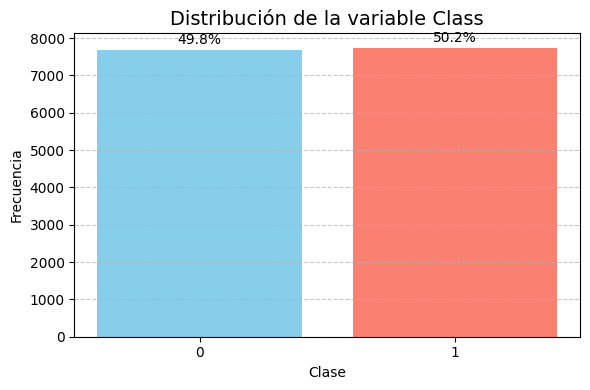

In [ ]:
import matplotlib.pyplot as plt

# Contar la frecuencia de cada clase
conteo = datos_com['Class'].value_counts().sort_index()

# Calcular los porcentajes
porcentajes = conteo / conteo.sum() * 100

# Crear la gráfica de barras
plt.figure(figsize=(6, 4))
bars = plt.bar(conteo.index.astype(str), conteo.values, color=['skyblue', 'salmon'])

# Añadir los porcentajes encima de cada barra
for i, val in enumerate(conteo.values):
    plt.text(i, val + max(conteo.values)*0.02, f'{porcentajes.iloc[i]:.1f}%', ha='center', fontsize=10)

# Personalizar el gráfico
plt.title('Distribución de la variable Class', fontsize=14)
plt.xlabel('Clase')
plt.ylabel('Frecuencia')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


**Aplicar validación cruzada en los datos completos, es decir, con balance 50-50% sin alguna variante de smote**

---



**Regresión logística**

In [ ]:
# Validación cruzada en datos completos con regresión logística
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50 = aplicar_validacion_cruzada(datos_com, modelo_type='logit')

guardar_resultados(
    nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-s_relación:Resultados.csv",
    modelo="Regresión logística",
    smote="Sin SMOTE",
    escenario="Completos",
    desbalance="50-50%",
    exactitud_50=scores_50,
    mcc_50=mcc_scores_50,
    umbral=umbral,
    mcc_f1_scores=mcc_f1_scores,
    exactitud_opt=scores,
    mcc_opt=mcc_scores,
    confusion_elements=confusion_elements
)


=== Fold 1 ===
Matriz de confusión (Umbral óptimo):
[[ 60 708]
 [ 42 732]]
Exactitud (con umbral 50%) en Fold 1: 0.5084
MCC (con umbral 50%) en Fold 1: 0.0165
Exactitud (con umbral óptimo) Fold 1: 0.5136
MCC ( con umbral óptimo)en Fold 1: 0.0480
MCC-F1 score (Fold 1): 0.4966
Umbral óptimo: 0.4806 — MCC(Normalizado): 0.5240, F1: 0.6612

=== Fold 2 ===
Matriz de confusión (Umbral óptimo):
[[  1 767]
 [  0 774]]
Exactitud (con umbral 50%) en Fold 2: 0.5013
MCC (con umbral 50%) en Fold 2: 0.0020
Exactitud (con umbral óptimo) Fold 2: 0.5026
MCC ( con umbral óptimo)en Fold 2: 0.0256
MCC-F1 score (Fold 2): 0.4111
Umbral óptimo: 0.4252 — MCC(Normalizado): 0.5128, F1: 0.6687

=== Fold 3 ===
Matriz de confusión (Umbral óptimo):
[[  0 768]
 [  0 774]]
Exactitud (con umbral 50%) en Fold 3: 0.4955
MCC (con umbral 50%) en Fold 3: -0.0099
Exactitud (con umbral óptimo) Fold 3: 0.5019
MCC ( con umbral óptimo)en Fold 3: 0.0000
MCC-F1 score (Fold 3): 0.4770
Umbral óptimo: 0.4275 — MCC(Normalizado): 0.50

**Gradient Boosting**

In [ ]:
# Validación cruzada en datos completos con  Gradient Boosting
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50 = aplicar_validacion_cruzada(datos_com, modelo_type='gbm')

guardar_resultados(
    nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-s_relación:Resultados.csv",
    modelo="Gradient Boosting",
    smote="Sin SMOTE",
    escenario="Completos",
    desbalance="50-50%",
    exactitud_50=scores_50,
    mcc_50=mcc_scores_50,
    umbral=umbral,
    mcc_f1_scores=mcc_f1_scores,
    exactitud_opt=scores,
    mcc_opt=mcc_scores,
    confusion_elements=confusion_elements
)


=== Fold 1 ===
Matriz de confusión (Umbral óptimo):
[[ 75 693]
 [ 48 726]]
Exactitud (con umbral 50%) en Fold 1: 0.5110
MCC (con umbral 50%) en Fold 1: 0.0217
Exactitud (con umbral óptimo) Fold 1: 0.5195
MCC ( con umbral óptimo)en Fold 1: 0.0658
MCC-F1 score (Fold 1): 0.5096
Umbral óptimo: 0.4461 — MCC(Normalizado): 0.5329, F1: 0.6621

=== Fold 2 ===
Matriz de confusión (Umbral óptimo):
[[ 25 743]
 [ 14 760]]
Exactitud (con umbral 50%) en Fold 2: 0.5052
MCC (con umbral 50%) en Fold 2: 0.0099
Exactitud (con umbral óptimo) Fold 2: 0.5091
MCC ( con umbral óptimo)en Fold 2: 0.0461
MCC-F1 score (Fold 2): 0.5105
Umbral óptimo: 0.4203 — MCC(Normalizado): 0.5230, F1: 0.6675

=== Fold 3 ===
Matriz de confusión (Umbral óptimo):
[[  2 766]
 [  0 774]]
Exactitud (con umbral 50%) en Fold 3: 0.5084
MCC (con umbral 50%) en Fold 3: 0.0164
Exactitud (con umbral óptimo) Fold 3: 0.5032
MCC ( con umbral óptimo)en Fold 3: 0.0362
MCC-F1 score (Fold 3): 0.4331
Umbral óptimo: 0.3002 — MCC(Normalizado): 0.518

**Random Forest**

In [ ]:
# Validación cruzada en datos completos con  Random Forest
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50 = aplicar_validacion_cruzada(datos_com, modelo_type='rf')

guardar_resultados(
    nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-s_relación:Resultados.csv",
    modelo="Random Forest",
    smote="Sin SMOTE",
    escenario="Completos",
    desbalance="50-50%",
    exactitud_50=scores_50,
    mcc_50=mcc_scores_50,
    umbral=umbral,
    mcc_f1_scores=mcc_f1_scores,
    exactitud_opt=scores,
    mcc_opt=mcc_scores,
    confusion_elements=confusion_elements
)


=== Fold 1 ===
Matriz de confusión (Umbral óptimo):
[[  2 766]
 [  0 774]]
Exactitud (con umbral 50%) en Fold 1: 0.4955
MCC (con umbral 50%) en Fold 1: -0.0093
Exactitud (con umbral óptimo) Fold 1: 0.5032
MCC ( con umbral óptimo)en Fold 1: 0.0362
MCC-F1 score (Fold 1): 0.4302
Umbral óptimo: 0.2100 — MCC(Normalizado): 0.5181, F1: 0.6690

=== Fold 2 ===
Matriz de confusión (Umbral óptimo):
[[  1 767]
 [  0 774]]
Exactitud (con umbral 50%) en Fold 2: 0.4792
MCC (con umbral 50%) en Fold 2: -0.0420
Exactitud (con umbral óptimo) Fold 2: 0.5026
MCC ( con umbral óptimo)en Fold 2: 0.0256
MCC-F1 score (Fold 2): 0.4350
Umbral óptimo: 0.2100 — MCC(Normalizado): 0.5128, F1: 0.6687

=== Fold 3 ===
Matriz de confusión (Umbral óptimo):
[[  1 767]
 [  0 774]]
Exactitud (con umbral 50%) en Fold 3: 0.5052
MCC (con umbral 50%) en Fold 3: 0.0100
Exactitud (con umbral óptimo) Fold 3: 0.5026
MCC ( con umbral óptimo)en Fold 3: 0.0256
MCC-F1 score (Fold 3): 0.4517
Umbral óptimo: 0.2100 — MCC(Normalizado): 0.5

In [ ]:
datos_com['Class'].value_counts()

,count
Class,
1,7739
0,7680


# Escenario 1: 75-25%

**Aplicar validación cruzada con tres variantes de smote en los tres modelos**

---

**Regresión logística**

In [ ]:
dta1 = datos_com.copy()

In [ ]:
dta1['Class'].value_counts()

,count
Class,
1,7739
0,7680


In [ ]:
# Reducción de clases variables relacionadas
print("\nDistribución de clases:")
print(dta1['Class'].value_counts())
df_reduced1 = reduce_class_2(dta1, reduction_percentage=0.75)
print("\nDistribución de clases después de reducción:")
df_reduced1['Class'].value_counts()


Distribución de clases:
Class
1    7739
0    7680
Name: count, dtype: int64

Distribución de clases después de reducción:


,count
Class,
0,7680
1,1934


***Stable SMOTE***

In [ ]:
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50, scores_unbalanced, mcc_scores_unbalanced = aplicar_validacion_cruzada_smote(
        df_reduced1,
        smote_type="sstable",
        modelo_type="logit"
    )
guardar_resultados_smote(
      nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-s_relación:Resultados.csv",
      modelo="Regresión logística",
      smote="Stable Smote",
      escenario="Reducidos con SMOTE",
      desbalance="75-25%",
      exactitud_sin_balance=scores_unbalanced,
      mcc_sin_balance=mcc_scores_unbalanced,
      exactitud_SMOTE_50=scores_50,
      mcc_SMOTE_50=mcc_scores_50,
      umbral=umbral,
      mcc_f1_scores=mcc_f1_scores,
      exactitud_SMOTE_opt=scores,
      mcc_SMOTE_opt=mcc_scores,
      confusion_elements=confusion_elements
)


=== Fold 1 ===
Número de instancias minoritarias necesarias: 5172
Distribución antes de SMOTE: {0: 6912, 1: 1740}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[ 16 752]
 [  3 191]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 1: 0.7983
MCC (datos de entrenamiento desbalanceados) en Fold 1: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 1: 0.4719
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 1: -0.0252
Exactitud (SMOTE con umbral óptimo) Fold 1: 0.2152
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 1: 0.0155
MCC-F1 score (Fold 1): 0.3331
Umbral óptimo: 0.1506 — MCC(Normalizado): 0.5077, F1: 0.3360

=== Fold 2 ===
Número de instancias minoritarias necesarias: 5172
Distribución antes de SMOTE: {0: 6912, 1: 1740}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[  6 762]
 [  0 194]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 2: 0.7983
MCC (datos de en

In [ ]:
dta1['Class'].value_counts()

,count
Class,
1,7739
0,7680


***Stable TL***

In [ ]:
dta2 = datos_com.copy()
# Reducción de clases variables relacionadas
print("\nDistribución de clases:")
print(dta2['Class'].value_counts())
df_reduced2 = reduce_class_2(dta2, reduction_percentage=0.75)
print("\nDistribución de clases después de reducción:")
df_reduced2['Class'].value_counts()


Distribución de clases:
Class
1    7739
0    7680
Name: count, dtype: int64

Distribución de clases después de reducción:


,count
Class,
0,7680
1,1934


In [ ]:
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50, scores_unbalanced, mcc_scores_unbalanced = aplicar_validacion_cruzada_smote(
        df_reduced2,
        smote_type="smotetl",
        modelo_type="logit"
    )
guardar_resultados_smote(
      nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-s_relación:Resultados.csv",
      modelo="Regresión logística",
      smote="Smote TL",
      escenario="Reducidos con SMOTE",
      desbalance="75-25%",
      exactitud_sin_balance=scores_unbalanced,
      mcc_sin_balance=mcc_scores_unbalanced,
      exactitud_SMOTE_50=scores_50,
      mcc_SMOTE_50=mcc_scores_50,
      umbral=umbral,
      mcc_f1_scores=mcc_f1_scores,
      exactitud_SMOTE_opt=scores,
      mcc_SMOTE_opt=mcc_scores,
      confusion_elements=confusion_elements
)

2025-12-06 03:09:51,087:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 03:09:51,091:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari


=== Fold 1 ===


2025-12-06 03:09:51,250:INFO:SMOTE: simplex sampling with n_dim 2
INFO:smote_variants:SMOTE: simplex sampling with n_dim 2
2025-12-06 03:09:51,287:INFO:TomekLinkRemoval: Running noise removal.
INFO:smote_variants:TomekLinkRemoval: Running noise removal.
2025-12-06 03:09:51,291:INFO:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
INFO:smote_variants:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
2025-12-06 03:09:51,296:INFO:NearestNeighborsWithMetricTensor: kneighbors query minkowski
INFO:smote_variants:NearestNeighborsWithMetricTensor: kneighbors query minkowski


Distribución antes de SMOTE: {0: 6912, 1: 1740}
Distribución después de SMOTE: {0: 6860, 1: 6860}


2025-12-06 03:09:57,064:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 03:09:57,066:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Matriz de confusión (Umbral óptimo):
[[ 34 734]
 [  4 190]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 1: 0.7983
MCC (datos de entrenamiento desbalanceados) en Fold 1: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 1: 0.4719
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 1: -0.0097
Exactitud (SMOTE con umbral óptimo) Fold 1: 0.2328
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 1: 0.0487
MCC-F1 score (Fold 1): 0.3771
Umbral óptimo: 0.4393 — MCC(Normalizado): 0.5244, F1: 0.3399

=== Fold 2 ===
Distribución antes de SMOTE: {0: 6912, 1: 1740}
Distribución después de SMOTE: {0: 6854, 1: 6854}


2025-12-06 03:10:01,689:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 03:10:01,691:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Matriz de confusión (Umbral óptimo):
[[ 34 734]
 [  5 189]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 2: 0.7983
MCC (datos de entrenamiento desbalanceados) en Fold 2: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 2: 0.4917
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 2: 0.0195
Exactitud (SMOTE con umbral óptimo) Fold 2: 0.2318
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 2: 0.0376
MCC-F1 score (Fold 2): 0.3653
Umbral óptimo: 0.4415 — MCC(Normalizado): 0.5188, F1: 0.3384

=== Fold 3 ===
Distribución antes de SMOTE: {0: 6912, 1: 1740}
Distribución después de SMOTE: {0: 6855, 1: 6855}


2025-12-06 03:10:07,358:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 03:10:07,362:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Matriz de confusión (Umbral óptimo):
[[102 666]
 [ 16 178]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 3: 0.7983
MCC (datos de entrenamiento desbalanceados) en Fold 3: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 3: 0.4823
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 3: 0.0319
Exactitud (SMOTE con umbral óptimo) Fold 3: 0.2911
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 3: 0.0616
MCC-F1 score (Fold 3): 0.3892
Umbral óptimo: 0.4722 — MCC(Normalizado): 0.5308, F1: 0.3430

=== Fold 4 ===
Distribución antes de SMOTE: {0: 6912, 1: 1740}
Distribución después de SMOTE: {0: 6867, 1: 6867}


2025-12-06 03:10:12,338:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 03:10:12,340:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Matriz de confusión (Umbral óptimo):
[[131 637]
 [ 24 170]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 4: 0.7983
MCC (datos de entrenamiento desbalanceados) en Fold 4: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 4: 0.4906
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 4: -0.0341
Exactitud (SMOTE con umbral óptimo) Fold 4: 0.3129
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 4: 0.0511
MCC-F1 score (Fold 4): 0.3839
Umbral óptimo: 0.4663 — MCC(Normalizado): 0.5256, F1: 0.3397

=== Fold 5 ===
Distribución antes de SMOTE: {0: 6912, 1: 1741}
Distribución después de SMOTE: {0: 6854, 1: 6854}


2025-12-06 03:10:16,941:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 03:10:16,943:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Matriz de confusión (Umbral óptimo):
[[ 10 758]
 [  1 192]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 5: 0.7992
MCC (datos de entrenamiento desbalanceados) en Fold 5: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 5: 0.4703
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 5: -0.0593
Exactitud (SMOTE con umbral óptimo) Fold 5: 0.2102
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 5: 0.0295
MCC-F1 score (Fold 5): 0.3499
Umbral óptimo: 0.4134 — MCC(Normalizado): 0.5148, F1: 0.3360

=== Fold 6 ===
Distribución antes de SMOTE: {0: 6912, 1: 1741}
Distribución después de SMOTE: {0: 6863, 1: 6863}


2025-12-06 03:10:22,912:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 03:10:22,914:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Matriz de confusión (Umbral óptimo):
[[206 562]
 [ 43 150]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 6: 0.7992
MCC (datos de entrenamiento desbalanceados) en Fold 6: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 6: 0.4683
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 6: -0.0085
Exactitud (SMOTE con umbral óptimo) Fold 6: 0.3704
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 6: 0.0415
MCC-F1 score (Fold 6): 0.3809
Umbral óptimo: 0.4802 — MCC(Normalizado): 0.5208, F1: 0.3315

=== Fold 7 ===
Distribución antes de SMOTE: {0: 6912, 1: 1741}
Distribución después de SMOTE: {0: 6859, 1: 6859}


2025-12-06 03:10:27,534:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 03:10:27,536:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Matriz de confusión (Umbral óptimo):
[[ 32 736]
 [  3 190]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 7: 0.7992
MCC (datos de entrenamiento desbalanceados) en Fold 7: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 7: 0.4922
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 7: -0.0001
Exactitud (SMOTE con umbral óptimo) Fold 7: 0.2310
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 7: 0.0559
MCC-F1 score (Fold 7): 0.3729
Umbral óptimo: 0.4461 — MCC(Normalizado): 0.5279, F1: 0.3396

=== Fold 8 ===
Distribución antes de SMOTE: {0: 6912, 1: 1741}
Distribución después de SMOTE: {0: 6865, 1: 6865}


2025-12-06 03:10:32,129:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 03:10:32,133:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Matriz de confusión (Umbral óptimo):
[[ 77 691]
 [ 17 176]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 8: 0.7992
MCC (datos de entrenamiento desbalanceados) en Fold 8: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 8: 0.4381
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 8: -0.0517
Exactitud (SMOTE con umbral óptimo) Fold 8: 0.2633
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 8: 0.0164
MCC-F1 score (Fold 8): 0.3773
Umbral óptimo: 0.4617 — MCC(Normalizado): 0.5082, F1: 0.3321

=== Fold 9 ===
Distribución antes de SMOTE: {0: 6912, 1: 1741}
Distribución después de SMOTE: {0: 6872, 1: 6872}


2025-12-06 03:10:38,316:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 03:10:38,319:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Matriz de confusión (Umbral óptimo):
[[  3 765]
 [  0 193]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 9: 0.7992
MCC (datos de entrenamiento desbalanceados) en Fold 9: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 9: 0.4912
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 9: -0.0042
Exactitud (SMOTE con umbral óptimo) Fold 9: 0.2040
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 9: 0.0281
MCC-F1 score (Fold 9): 0.3475
Umbral óptimo: 0.4024 — MCC(Normalizado): 0.5140, F1: 0.3354

=== Fold 10 ===
Distribución antes de SMOTE: {0: 6912, 1: 1741}
Distribución después de SMOTE: {0: 6849, 1: 6849}
Matriz de confusión (Umbral óptimo):
[[  0 768]
 [  0 193]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 10: 0.7992
MCC (datos de entrenamiento desbalanceados) en Fold 10: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 10: 0.4631
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 10: -0.0294
Exactitud (SMOTE con umbral óptimo) Fold 10

In [ ]:
print(dta2['Class'].value_counts())

Class
1    7739
0    7680
Name: count, dtype: int64


***Stable IPF***

In [ ]:
dta3 = datos_com.copy()
# Reducción de clases variables relacionadas
print("\nDistribución de clases:")
print(dta3['Class'].value_counts())
df_reduced3 = reduce_class_2(dta3, reduction_percentage=0.75)
print("\nDistribución de clases después de reducción:")
df_reduced3['Class'].value_counts()


Distribución de clases:
Class
1    7739
0    7680
Name: count, dtype: int64

Distribución de clases después de reducción:


,count
Class,
0,7680
1,1934


In [ ]:
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50, scores_unbalanced, mcc_scores_unbalanced = aplicar_validacion_cruzada_smote(
        df_reduced3,
        smote_type="smoteipf",
        modelo_type="logit"
    )
guardar_resultados_smote(
      nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-s_relación:Resultados.csv",
      modelo="Regresión logística",
      smote="Smote IPF",
      escenario="Reducidos con SMOTE",
      desbalance="75-25%",
      exactitud_sin_balance=scores_unbalanced,
      mcc_sin_balance=mcc_scores_unbalanced,
      exactitud_SMOTE_50=scores_50,
      mcc_SMOTE_50=mcc_scores_50,
      umbral=umbral,
      mcc_f1_scores=mcc_f1_scores,
      exactitud_SMOTE_opt=scores,
      mcc_SMOTE_opt=mcc_scores,
      confusion_elements=confusion_elements
)

2025-12-06 03:10:42,955:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 03:10:42,958:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p


=== Fold 1 ===


2025-12-06 03:10:43,810:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 03:10:44,545:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 03:10:45,285:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements


Distribución antes de SMOTE: {0: 6912, 1: 1740}
Distribución después de SMOTE: {0: 6912, 1: 6912}


2025-12-06 03:10:49,776:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 03:10:49,780:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Matriz de confusión (Umbral óptimo):
[[ 34 734]
 [  4 190]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 1: 0.7983
MCC (datos de entrenamiento desbalanceados) en Fold 1: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 1: 0.4792
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 1: -0.0024
Exactitud (SMOTE con umbral óptimo) Fold 1: 0.2328
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 1: 0.0487
MCC-F1 score (Fold 1): 0.3777
Umbral óptimo: 0.4399 — MCC(Normalizado): 0.5244, F1: 0.3399

=== Fold 2 ===


2025-12-06 03:10:50,762:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 03:10:51,490:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 03:10:52,224:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements


Distribución antes de SMOTE: {0: 6912, 1: 1740}
Distribución después de SMOTE: {0: 6912, 1: 6912}


2025-12-06 03:10:55,499:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 03:10:55,505:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Matriz de confusión (Umbral óptimo):
[[ 34 734]
 [  5 189]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 2: 0.7983
MCC (datos de entrenamiento desbalanceados) en Fold 2: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 2: 0.4958
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 2: 0.0206
Exactitud (SMOTE con umbral óptimo) Fold 2: 0.2318
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 2: 0.0376
MCC-F1 score (Fold 2): 0.3710
Umbral óptimo: 0.4430 — MCC(Normalizado): 0.5188, F1: 0.3384

=== Fold 3 ===


2025-12-06 03:10:56,352:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 03:10:57,082:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 03:10:57,812:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements


Distribución antes de SMOTE: {0: 6912, 1: 1740}
Distribución después de SMOTE: {0: 6912, 1: 6912}


2025-12-06 03:11:01,627:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 03:11:01,632:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Matriz de confusión (Umbral óptimo):
[[100 668]
 [ 16 178]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 3: 0.7983
MCC (datos de entrenamiento desbalanceados) en Fold 3: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 3: 0.4834
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 3: 0.0267
Exactitud (SMOTE con umbral óptimo) Fold 3: 0.2890
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 3: 0.0588
MCC-F1 score (Fold 3): 0.3885
Umbral óptimo: 0.4734 — MCC(Normalizado): 0.5294, F1: 0.3423

=== Fold 4 ===


2025-12-06 03:11:02,773:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 03:11:03,795:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 03:11:04,667:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements


Distribución antes de SMOTE: {0: 6912, 1: 1740}
Distribución después de SMOTE: {0: 6912, 1: 6912}


2025-12-06 03:11:07,986:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 03:11:07,989:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Matriz de confusión (Umbral óptimo):
[[115 653]
 [ 21 173]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 4: 0.7983
MCC (datos de entrenamiento desbalanceados) en Fold 4: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 4: 0.4875
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 4: -0.0342
Exactitud (SMOTE con umbral óptimo) Fold 4: 0.2994
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 4: 0.0478
MCC-F1 score (Fold 4): 0.3828
Umbral óptimo: 0.4644 — MCC(Normalizado): 0.5239, F1: 0.3392

=== Fold 5 ===


2025-12-06 03:11:08,838:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 03:11:09,579:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 03:11:10,306:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements


Distribución antes de SMOTE: {0: 6912, 1: 1741}
Distribución después de SMOTE: {0: 6912, 1: 6912}


2025-12-06 03:11:13,629:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 03:11:13,632:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Matriz de confusión (Umbral óptimo):
[[ 12 756]
 [  1 192]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 5: 0.7992
MCC (datos de entrenamiento desbalanceados) en Fold 5: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 5: 0.4693
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 5: -0.0634
Exactitud (SMOTE con umbral óptimo) Fold 5: 0.2123
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 5: 0.0362
MCC-F1 score (Fold 5): 0.3528
Umbral óptimo: 0.4154 — MCC(Normalizado): 0.5181, F1: 0.3365

=== Fold 6 ===


2025-12-06 03:11:14,570:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 03:11:15,612:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 03:11:16,659:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements


Distribución antes de SMOTE: {0: 6912, 1: 1741}
Distribución después de SMOTE: {0: 6912, 1: 6912}


2025-12-06 03:11:20,546:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 03:11:20,548:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Matriz de confusión (Umbral óptimo):
[[208 560]
 [ 43 150]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 6: 0.7992
MCC (datos de entrenamiento desbalanceados) en Fold 6: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 6: 0.4651
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 6: -0.0117
Exactitud (SMOTE con umbral óptimo) Fold 6: 0.3725
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 6: 0.0438
MCC-F1 score (Fold 6): 0.3830
Umbral óptimo: 0.4806 — MCC(Normalizado): 0.5219, F1: 0.3322

=== Fold 7 ===


2025-12-06 03:11:21,408:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 03:11:22,153:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 03:11:22,883:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements


Distribución antes de SMOTE: {0: 6912, 1: 1741}
Distribución después de SMOTE: {0: 6912, 1: 6912}


2025-12-06 03:11:26,161:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 03:11:26,163:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Matriz de confusión (Umbral óptimo):
[[ 34 734]
 [  3 190]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 7: 0.7992
MCC (datos de entrenamiento desbalanceados) en Fold 7: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 7: 0.4880
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 7: -0.0042
Exactitud (SMOTE con umbral óptimo) Fold 7: 0.2331
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 7: 0.0598
MCC-F1 score (Fold 7): 0.3698
Umbral óptimo: 0.4481 — MCC(Normalizado): 0.5299, F1: 0.3402

=== Fold 8 ===


2025-12-06 03:11:27,006:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 03:11:27,727:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 03:11:28,504:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements


Distribución antes de SMOTE: {0: 6912, 1: 1741}
Distribución después de SMOTE: {0: 6912, 1: 6912}


2025-12-06 03:11:33,050:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 03:11:33,053:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Matriz de confusión (Umbral óptimo):
[[ 94 674]
 [ 20 173]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 8: 0.7992
MCC (datos de entrenamiento desbalanceados) en Fold 8: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 8: 0.4412
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 8: -0.0423
Exactitud (SMOTE con umbral óptimo) Fold 8: 0.2778
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 8: 0.0233
MCC-F1 score (Fold 8): 0.3752
Umbral óptimo: 0.4667 — MCC(Normalizado): 0.5116, F1: 0.3327

=== Fold 9 ===


2025-12-06 03:11:33,901:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 03:11:34,621:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 03:11:35,350:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements


Distribución antes de SMOTE: {0: 6912, 1: 1741}
Distribución después de SMOTE: {0: 6912, 1: 6912}


2025-12-06 03:11:38,605:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 03:11:38,608:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Matriz de confusión (Umbral óptimo):
[[  3 765]
 [  0 193]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 9: 0.7992
MCC (datos de entrenamiento desbalanceados) en Fold 9: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 9: 0.4922
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 9: -0.0063
Exactitud (SMOTE con umbral óptimo) Fold 9: 0.2040
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 9: 0.0281
MCC-F1 score (Fold 9): 0.3513
Umbral óptimo: 0.4040 — MCC(Normalizado): 0.5140, F1: 0.3354

=== Fold 10 ===


2025-12-06 03:11:39,444:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 03:11:40,159:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 03:11:40,866:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements


Distribución antes de SMOTE: {0: 6912, 1: 1741}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[  0 768]
 [  0 193]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 10: 0.7992
MCC (datos de entrenamiento desbalanceados) en Fold 10: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 10: 0.4620
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 10: -0.0304
Exactitud (SMOTE con umbral óptimo) Fold 10: 0.2008
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 10: 0.0000
MCC-F1 score (Fold 10): 0.3563
Umbral óptimo: 0.3194 — MCC(Normalizado): 0.5000, F1: 0.3345

Resultados Finales:
Exactitud media (datos de entrenamiento desbalanceados) : 0.7988 ± 0.0004
MCC medio (datos de entrenamiento desbalanceados) : 0.0000 ± 0.0000
Exactitud media (SMOTE con umbral 50%) : 0.4764 ± 0.0160
MCC medio (SMOTE con umbral 50%) : -0.0148 ± 0.0266
Exactitud media (SMOTE con umbral óptimo) : 0.2554 ± 0.0513
MCC medio (SMOTE con umbral óptimo) :

**Gradient Boosting**

***Stable SMOTE***

In [ ]:
dta4 = datos_com.copy()
# Reducción de clases variables relacionadas
print("\nDistribución de clases:")
print(dta4['Class'].value_counts())
df_reduced4 = reduce_class_2(dta4, reduction_percentage=0.75)
print("\nDistribución de clases después de reducción:")
df_reduced4['Class'].value_counts()


Distribución de clases:
Class
1    7739
0    7680
Name: count, dtype: int64

Distribución de clases después de reducción:


,count
Class,
0,7680
1,1934


In [ ]:
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50, scores_unbalanced, mcc_scores_unbalanced = aplicar_validacion_cruzada_smote(
        df_reduced4,
        smote_type="sstable",
        modelo_type="gbm"
    )
guardar_resultados_smote(
      nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-s_relación:Resultados.csv",
      modelo="Gradient Boosting",
      smote="Stable Smote",
      escenario="Reducidos con SMOTE",
      desbalance="75-25%",
      exactitud_sin_balance=scores_unbalanced,
      mcc_sin_balance=mcc_scores_unbalanced,
      exactitud_SMOTE_50=scores_50,
      mcc_SMOTE_50=mcc_scores_50,
      umbral=umbral,
      mcc_f1_scores=mcc_f1_scores,
      exactitud_SMOTE_opt=scores,
      mcc_SMOTE_opt=mcc_scores,
      confusion_elements=confusion_elements
)


=== Fold 1 ===
Número de instancias minoritarias necesarias: 5172
Distribución antes de SMOTE: {0: 6912, 1: 1740}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[  7 761]
 [  0 194]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 1: 0.7983
MCC (datos de entrenamiento desbalanceados) en Fold 1: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 1: 0.5915
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 1: -0.0205
Exactitud (SMOTE con umbral óptimo) Fold 1: 0.2089
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 1: 0.0430
MCC-F1 score (Fold 1): 0.3478
Umbral óptimo: 0.0850 — MCC(Normalizado): 0.5215, F1: 0.3377

=== Fold 2 ===
Número de instancias minoritarias necesarias: 5172
Distribución antes de SMOTE: {0: 6912, 1: 1740}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[ 62 706]
 [  8 186]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 2: 0.7973
MCC (datos de en

***Stable TL***

In [ ]:
dta5 = datos_com.copy()
# Reducción de clases variables relacionadas
print("\nDistribución de clases:")
print(dta5['Class'].value_counts())
df_reduced5 = reduce_class_2(dta5, reduction_percentage=0.75)
print("\nDistribución de clases después de reducción:")
df_reduced5['Class'].value_counts()


Distribución de clases:
Class
1    7739
0    7680
Name: count, dtype: int64

Distribución de clases después de reducción:


,count
Class,
0,7680
1,1934


In [ ]:
 scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50, scores_unbalanced, mcc_scores_unbalanced = aplicar_validacion_cruzada_smote(
        df_reduced5,
        smote_type="smotetl",
        modelo_type="gbm"
    )
guardar_resultados_smote(
      nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-s_relación:Resultados.csv",
      modelo="Gradient Boosting",
      smote="Smote TL",
      escenario="Reducidos con SMOTE",
      desbalance="75-25%",
      exactitud_sin_balance=scores_unbalanced,
      mcc_sin_balance=mcc_scores_unbalanced,
      exactitud_SMOTE_50=scores_50,
      mcc_SMOTE_50=mcc_scores_50,
      umbral=umbral,
      mcc_f1_scores=mcc_f1_scores,
      exactitud_SMOTE_opt=scores,
      mcc_SMOTE_opt=mcc_scores,
      confusion_elements=confusion_elements
)


=== Fold 1 ===


2025-12-06 03:29:14,605:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 03:29:14,607:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6912, 1: 1740}
Distribución después de SMOTE: {0: 6860, 1: 6860}
Matriz de confusión (Umbral óptimo):
[[ 42 726]
 [  8 186]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 1: 0.7983
MCC (datos de entrenamiento desbalanceados) en Fold 1: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 1: 0.2017
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 1: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 1: 0.2370
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 1: 0.0243
MCC-F1 score (Fold 1): 0.3577
Umbral óptimo: 0.9920 — MCC(Normalizado): 0.5122, F1: 0.3363

=== Fold 2 ===


2025-12-06 03:29:23,314:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 03:29:23,316:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6912, 1: 1740}
Distribución después de SMOTE: {0: 6854, 1: 6854}
Matriz de confusión (Umbral óptimo):
[[ 53 715]
 [  8 186]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 2: 0.7973
MCC (datos de entrenamiento desbalanceados) en Fold 2: -0.0162
Exactitud (SMOTE con umbral 50%) en Fold 2: 0.2017
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 2: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 2: 0.2484
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 2: 0.0457
MCC-F1 score (Fold 2): 0.3555
Umbral óptimo: 0.9975 — MCC(Normalizado): 0.5229, F1: 0.3397

=== Fold 3 ===


2025-12-06 03:29:33,112:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 03:29:33,115:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6912, 1: 1740}
Distribución después de SMOTE: {0: 6855, 1: 6855}
Matriz de confusión (Umbral óptimo):
[[163 605]
 [ 26 168]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 3: 0.7973
MCC (datos de entrenamiento desbalanceados) en Fold 3: -0.0162
Exactitud (SMOTE con umbral 50%) en Fold 3: 0.2017
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 3: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 3: 0.3441
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 3: 0.0790
MCC-F1 score (Fold 3): 0.3841
Umbral óptimo: 0.9956 — MCC(Normalizado): 0.5395, F1: 0.3475

=== Fold 4 ===


2025-12-06 03:29:41,823:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 03:29:41,825:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6912, 1: 1740}
Distribución después de SMOTE: {0: 6867, 1: 6867}
Matriz de confusión (Umbral óptimo):
[[135 633]
 [ 27 167]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 4: 0.7983
MCC (datos de entrenamiento desbalanceados) en Fold 4: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 4: 0.2017
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 4: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 4: 0.3139
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 4: 0.0392
MCC-F1 score (Fold 4): 0.3560
Umbral óptimo: 0.9972 — MCC(Normalizado): 0.5196, F1: 0.3360

=== Fold 5 ===


2025-12-06 03:29:49,906:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 03:29:49,908:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6912, 1: 1741}
Distribución después de SMOTE: {0: 6854, 1: 6854}
Matriz de confusión (Umbral óptimo):
[[100 668]
 [ 16 177]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 5: 0.7992
MCC (datos de entrenamiento desbalanceados) en Fold 5: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 5: 0.2008
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 5: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 5: 0.2882
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 5: 0.0582
MCC-F1 score (Fold 5): 0.3885
Umbral óptimo: 0.9954 — MCC(Normalizado): 0.5291, F1: 0.3410

=== Fold 6 ===


2025-12-06 03:29:59,908:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 03:29:59,911:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6912, 1: 1741}
Distribución después de SMOTE: {0: 6863, 1: 6863}
Matriz de confusión (Umbral óptimo):
[[  4 764]
 [  0 193]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 6: 0.7992
MCC (datos de entrenamiento desbalanceados) en Fold 6: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 6: 0.2008
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 6: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 6: 0.2050
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 6: 0.0324
MCC-F1 score (Fold 6): 0.3577
Umbral óptimo: 0.9949 — MCC(Normalizado): 0.5162, F1: 0.3357

=== Fold 7 ===


2025-12-06 03:30:09,449:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 03:30:09,452:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6912, 1: 1741}
Distribución después de SMOTE: {0: 6859, 1: 6859}
Matriz de confusión (Umbral óptimo):
[[ 97 671]
 [ 14 179]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 7: 0.8002
MCC (datos de entrenamiento desbalanceados) en Fold 7: 0.0644
Exactitud (SMOTE con umbral 50%) en Fold 7: 0.2008
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 7: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 7: 0.2872
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 7: 0.0674
MCC-F1 score (Fold 7): 0.3578
Umbral óptimo: 0.9972 — MCC(Normalizado): 0.5337, F1: 0.3432

=== Fold 8 ===


2025-12-06 03:30:17,796:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 03:30:17,798:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6912, 1: 1741}
Distribución después de SMOTE: {0: 6865, 1: 6865}
Matriz de confusión (Umbral óptimo):
[[ 23 745]
 [  2 191]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 8: 0.7981
MCC (datos de entrenamiento desbalanceados) en Fold 8: -0.0162
Exactitud (SMOTE con umbral 50%) en Fold 8: 0.2008
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 8: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 8: 0.2227
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 8: 0.0493
MCC-F1 score (Fold 8): 0.3785
Umbral óptimo: 0.9942 — MCC(Normalizado): 0.5246, F1: 0.3384

=== Fold 9 ===


2025-12-06 03:30:27,910:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 03:30:27,913:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6912, 1: 1741}
Distribución después de SMOTE: {0: 6872, 1: 6872}
Matriz de confusión (Umbral óptimo):
[[  1 767]
 [  0 193]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 9: 0.7981
MCC (datos de entrenamiento desbalanceados) en Fold 9: -0.0162
Exactitud (SMOTE con umbral 50%) en Fold 9: 0.2008
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 9: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 9: 0.2019
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 9: 0.0162
MCC-F1 score (Fold 9): 0.3312
Umbral óptimo: 0.9909 — MCC(Normalizado): 0.5081, F1: 0.3348

=== Fold 10 ===


2025-12-06 03:30:37,926:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 03:30:37,928:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6912, 1: 1741}
Distribución después de SMOTE: {0: 6849, 1: 6849}
Matriz de confusión (Umbral óptimo):
[[ 25 743]
 [  1 192]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 10: 0.8002
MCC (datos de entrenamiento desbalanceados) en Fold 10: 0.0644
Exactitud (SMOTE con umbral 50%) en Fold 10: 0.2008
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 10: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 10: 0.2258
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 10: 0.0676
MCC-F1 score (Fold 10): 0.3558
Umbral óptimo: 0.9941 — MCC(Normalizado): 0.5338, F1: 0.3404

Resultados Finales:
Exactitud media (datos de entrenamiento desbalanceados) : 0.7986 ± 0.0010
MCC medio (datos de entrenamiento desbalanceados) : 0.0064 ± 0.0299
Exactitud media (SMOTE con umbral 50%) : 0.2012 ± 0.0004
MCC medio (SMOTE con umbral 50%) : 0.0000 ± 0.0000
Exactitud media (SMOTE con umbral óptimo) : 0.2574 ± 0.0459
MCC medio (SMOTE con umbral óptimo) : 0

***Stable IPF***

In [ ]:
dta6 = datos_com.copy()
# Reducción de clases variables relacionadas
print("\nDistribución de clases:")
print(dta6['Class'].value_counts())
df_reduced6 = reduce_class_2(dta6, reduction_percentage=0.75)
print("\nDistribución de clases después de reducción:")
df_reduced6['Class'].value_counts()


Distribución de clases:
Class
1    7739
0    7680
Name: count, dtype: int64

Distribución de clases después de reducción:


,count
Class,
0,7680
1,1934


In [ ]:
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50, scores_unbalanced, mcc_scores_unbalanced = aplicar_validacion_cruzada_smote(
        df_reduced6,
        smote_type="smoteipf",
        modelo_type="gbm"
    )
guardar_resultados_smote(
      nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-s_relación:Resultados.csv",
      modelo="Gradient Boosting",
      smote="Smote IPF",
      escenario="Reducidos con SMOTE",
      desbalance="75-25%",
      exactitud_sin_balance=scores_unbalanced,
      mcc_sin_balance=mcc_scores_unbalanced,
      exactitud_SMOTE_50=scores_50,
      mcc_SMOTE_50=mcc_scores_50,
      umbral=umbral,
      mcc_f1_scores=mcc_f1_scores,
      exactitud_SMOTE_opt=scores,
      mcc_SMOTE_opt=mcc_scores,
      confusion_elements=confusion_elements
)


=== Fold 1 ===


2025-12-06 03:30:46,903:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 03:30:46,906:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6912, 1: 1740}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[289 479]
 [ 60 134]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 1: 0.7983
MCC (datos de entrenamiento desbalanceados) en Fold 1: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 1: 0.2017
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 1: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 1: 0.4397
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 1: 0.0559
MCC-F1 score (Fold 1): 0.3773
Umbral óptimo: 0.9972 — MCC(Normalizado): 0.5280, F1: 0.3321

=== Fold 2 ===


2025-12-06 03:30:57,408:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 03:30:57,412:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6912, 1: 1740}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[165 603]
 [ 32 162]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 2: 0.7973
MCC (datos de entrenamiento desbalanceados) en Fold 2: -0.0162
Exactitud (SMOTE con umbral 50%) en Fold 2: 0.2017
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 2: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 2: 0.3399
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 2: 0.0496
MCC-F1 score (Fold 2): 0.3625
Umbral óptimo: 0.9980 — MCC(Normalizado): 0.5248, F1: 0.3379

=== Fold 3 ===


2025-12-06 03:31:07,897:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 03:31:07,900:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6912, 1: 1740}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[124 644]
 [ 19 175]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 3: 0.7973
MCC (datos de entrenamiento desbalanceados) en Fold 3: -0.0162
Exactitud (SMOTE con umbral 50%) en Fold 3: 0.2017
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 3: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 3: 0.3108
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 3: 0.0716
MCC-F1 score (Fold 3): 0.3865
Umbral óptimo: 0.9953 — MCC(Normalizado): 0.5358, F1: 0.3455

=== Fold 4 ===


2025-12-06 03:31:18,487:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 03:31:18,490:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6912, 1: 1740}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[  0 768]
 [  0 194]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 4: 0.7983
MCC (datos de entrenamiento desbalanceados) en Fold 4: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 4: 0.2017
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 4: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 4: 0.2017
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 4: 0.0000
MCC-F1 score (Fold 4): 0.3407
Umbral óptimo: 0.9918 — MCC(Normalizado): 0.5000, F1: 0.3356

=== Fold 5 ===


2025-12-06 03:31:27,588:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 03:31:27,590:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6912, 1: 1741}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[ 57 711]
 [  6 187]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 5: 0.7992
MCC (datos de entrenamiento desbalanceados) en Fold 5: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 5: 0.2008
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 5: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 5: 0.2539
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 5: 0.0698
MCC-F1 score (Fold 5): 0.3786
Umbral óptimo: 0.9949 — MCC(Normalizado): 0.5349, F1: 0.3428

=== Fold 6 ===


2025-12-06 03:31:38,444:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 03:31:38,447:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6912, 1: 1741}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[  4 764]
 [  0 193]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 6: 0.7992
MCC (datos de entrenamiento desbalanceados) en Fold 6: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 6: 0.2008
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 6: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 6: 0.2050
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 6: 0.0324
MCC-F1 score (Fold 6): 0.3464
Umbral óptimo: 0.9929 — MCC(Normalizado): 0.5162, F1: 0.3357

=== Fold 7 ===


2025-12-06 03:31:49,100:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 03:31:49,103:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6912, 1: 1741}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[295 473]
 [ 58 135]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 7: 0.8002
MCC (datos de entrenamiento desbalanceados) en Fold 7: 0.0644
Exactitud (SMOTE con umbral 50%) en Fold 7: 0.2008
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 7: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 7: 0.4475
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 7: 0.0695
MCC-F1 score (Fold 7): 0.3633
Umbral óptimo: 0.9971 — MCC(Normalizado): 0.5347, F1: 0.3371

=== Fold 8 ===


2025-12-06 03:31:59,982:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 03:31:59,984:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6912, 1: 1741}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[124 644]
 [ 26 167]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 8: 0.7981
MCC (datos de entrenamiento desbalanceados) en Fold 8: -0.0162
Exactitud (SMOTE con umbral 50%) en Fold 8: 0.2008
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 8: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 8: 0.3028
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 8: 0.0295
MCC-F1 score (Fold 8): 0.3858
Umbral óptimo: 0.9968 — MCC(Normalizado): 0.5148, F1: 0.3327

=== Fold 9 ===


2025-12-06 03:32:09,638:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 03:32:09,641:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6912, 1: 1741}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[  2 766]
 [  0 193]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 9: 0.7981
MCC (datos de entrenamiento desbalanceados) en Fold 9: -0.0162
Exactitud (SMOTE con umbral 50%) en Fold 9: 0.2008
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 9: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 9: 0.2029
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 9: 0.0229
MCC-F1 score (Fold 9): 0.3180
Umbral óptimo: 0.9928 — MCC(Normalizado): 0.5114, F1: 0.3351

=== Fold 10 ===


2025-12-06 03:32:20,426:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 03:32:20,429:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6912, 1: 1741}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[ 61 707]
 [  9 184]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 10: 0.8002
MCC (datos de entrenamiento desbalanceados) en Fold 10: 0.0644
Exactitud (SMOTE con umbral 50%) en Fold 10: 0.2008
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 10: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 10: 0.2549
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 10: 0.0506
MCC-F1 score (Fold 10): 0.3727
Umbral óptimo: 0.9944 — MCC(Normalizado): 0.5253, F1: 0.3395

Resultados Finales:
Exactitud media (datos de entrenamiento desbalanceados) : 0.7986 ± 0.0010
MCC medio (datos de entrenamiento desbalanceados) : 0.0064 ± 0.0299
Exactitud media (SMOTE con umbral 50%) : 0.2012 ± 0.0004
MCC medio (SMOTE con umbral 50%) : 0.0000 ± 0.0000
Exactitud media (SMOTE con umbral óptimo) : 0.2959 ± 0.0867
MCC medio (SMOTE con umbral óptimo) : 0

**Random Forest**

***Stable Smote***

In [ ]:
dta7 = datos_com.copy()
# Reducción de clases variables relacionadas
print("\nDistribución de clases:")
print(dta7['Class'].value_counts())
df_reduced7 = reduce_class_2(dta7, reduction_percentage=0.75)
print("\nDistribución de clases después de reducción:")
df_reduced7['Class'].value_counts()


Distribución de clases:
Class
1    7739
0    7680
Name: count, dtype: int64

Distribución de clases después de reducción:


,count
Class,
0,7680
1,1934


In [ ]:
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50, scores_unbalanced, mcc_scores_unbalanced = aplicar_validacion_cruzada_smote(
        df_reduced7,
        smote_type="sstable",
        modelo_type="rf"
    )
guardar_resultados_smote(
      nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-s_relación:Resultados.csv",
      modelo="Random Forest",
      smote="Stable Smote",
      escenario="Reducidos con SMOTE",
      desbalance="75-25%",
      exactitud_sin_balance=scores_unbalanced,
      mcc_sin_balance=mcc_scores_unbalanced,
      exactitud_SMOTE_50=scores_50,
      mcc_SMOTE_50=mcc_scores_50,
      umbral=umbral,
      mcc_f1_scores=mcc_f1_scores,
      exactitud_SMOTE_opt=scores,
      mcc_SMOTE_opt=mcc_scores,
      confusion_elements=confusion_elements
)


=== Fold 1 ===
Número de instancias minoritarias necesarias: 5172
Distribución antes de SMOTE: {0: 6912, 1: 1740}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[  0 768]
 [  0 194]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 1: 0.7952
MCC (datos de entrenamiento desbalanceados) en Fold 1: -0.0281
Exactitud (SMOTE con umbral 50%) en Fold 1: 0.6632
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 1: -0.0035
Exactitud (SMOTE con umbral óptimo) Fold 1: 0.2017
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 1: 0.0000
MCC-F1 score (Fold 1): 0.3303
Umbral óptimo: 0.0200 — MCC(Normalizado): 0.5000, F1: 0.3356

=== Fold 2 ===
Número de instancias minoritarias necesarias: 5172
Distribución antes de SMOTE: {0: 6912, 1: 1740}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[217 551]
 [ 44 150]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 2: 0.7952
MCC (datos de e

***Smote TL***

In [ ]:
dta8 = datos_com.copy()
# Reducción de clases variables relacionadas
print("\nDistribución de clases:")
print(dta8['Class'].value_counts())
df_reduced8  = reduce_class_2(dta8, reduction_percentage=0.75)
print("\nDistribución de clases después de reducción:")
df_reduced8['Class'].value_counts()


Distribución de clases:
Class
1    7739
0    7680
Name: count, dtype: int64

Distribución de clases después de reducción:


,count
Class,
0,7680
1,1934


In [ ]:
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50, scores_unbalanced, mcc_scores_unbalanced = aplicar_validacion_cruzada_smote(
        df_reduced8,
        smote_type="smotetl",
        modelo_type="rf"
    )
guardar_resultados_smote(
      nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-s_relación:Resultados.csv",
      modelo="Random Forest",
      smote="Smote TL",
      escenario="Reducidos con SMOTE",
      desbalance="75-25%",
      exactitud_sin_balance=scores_unbalanced,
      mcc_sin_balance=mcc_scores_unbalanced,
      exactitud_SMOTE_50=scores_50,
      mcc_SMOTE_50=mcc_scores_50,
      umbral=umbral,
      mcc_f1_scores=mcc_f1_scores,
      exactitud_SMOTE_opt=scores,
      mcc_SMOTE_opt=mcc_scores,
      confusion_elements=confusion_elements
)


=== Fold 1 ===


2025-12-06 03:49:33,511:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 03:49:33,513:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6912, 1: 1740}
Distribución después de SMOTE: {0: 6860, 1: 6860}
Matriz de confusión (Umbral óptimo):
[[ 10 758]
 [  1 193]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 1: 0.7952
MCC (datos de entrenamiento desbalanceados) en Fold 1: -0.0281
Exactitud (SMOTE con umbral 50%) en Fold 1: 0.2017
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 1: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 1: 0.2110
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 1: 0.0297
MCC-F1 score (Fold 1): 0.4129
Umbral óptimo: 0.9900 — MCC(Normalizado): 0.5148, F1: 0.3371

=== Fold 2 ===


2025-12-06 03:49:39,781:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 03:49:39,783:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6912, 1: 1740}
Distribución después de SMOTE: {0: 6854, 1: 6854}
Matriz de confusión (Umbral óptimo):
[[ 13 755]
 [  1 193]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 2: 0.7952
MCC (datos de entrenamiento desbalanceados) en Fold 2: -0.0281
Exactitud (SMOTE con umbral 50%) en Fold 2: 0.2017
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 2: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 2: 0.2141
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 2: 0.0394
MCC-F1 score (Fold 2): 0.4181
Umbral óptimo: 0.9900 — MCC(Normalizado): 0.5197, F1: 0.3380

=== Fold 3 ===


2025-12-06 03:49:44,864:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 03:49:44,867:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6912, 1: 1740}
Distribución después de SMOTE: {0: 6855, 1: 6855}
Matriz de confusión (Umbral óptimo):
[[  5 763]
 [  0 194]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 3: 0.7963
MCC (datos de entrenamiento desbalanceados) en Fold 3: -0.0229
Exactitud (SMOTE con umbral 50%) en Fold 3: 0.2017
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 3: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 3: 0.2069
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 3: 0.0363
MCC-F1 score (Fold 3): 0.4124
Umbral óptimo: 0.9900 — MCC(Normalizado): 0.5182, F1: 0.3371

=== Fold 4 ===


2025-12-06 03:49:50,236:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 03:49:50,239:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6912, 1: 1740}
Distribución después de SMOTE: {0: 6867, 1: 6867}
Matriz de confusión (Umbral óptimo):
[[  0 768]
 [  0 194]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 4: 0.7973
MCC (datos de entrenamiento desbalanceados) en Fold 4: -0.0162
Exactitud (SMOTE con umbral 50%) en Fold 4: 0.2017
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 4: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 4: 0.2017
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 4: 0.0000
MCC-F1 score (Fold 4): 0.3994
Umbral óptimo: 0.8700 — MCC(Normalizado): 0.5000, F1: 0.3356

=== Fold 5 ===


2025-12-06 03:49:56,499:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 03:49:56,501:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6912, 1: 1741}
Distribución después de SMOTE: {0: 6854, 1: 6854}
Matriz de confusión (Umbral óptimo):
[[ 49 719]
 [  6 187]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 5: 0.7960
MCC (datos de entrenamiento desbalanceados) en Fold 5: -0.0281
Exactitud (SMOTE con umbral 50%) en Fold 5: 0.2008
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 5: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 5: 0.2456
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 5: 0.0564
MCC-F1 score (Fold 5): 0.4185
Umbral óptimo: 0.9900 — MCC(Normalizado): 0.5282, F1: 0.3403

=== Fold 6 ===


2025-12-06 03:50:01,576:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 03:50:01,580:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6912, 1: 1741}
Distribución después de SMOTE: {0: 6863, 1: 6863}
Matriz de confusión (Umbral óptimo):
[[ 47 721]
 [  8 185]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 6: 0.7971
MCC (datos de entrenamiento desbalanceados) en Fold 6: -0.0229
Exactitud (SMOTE con umbral 50%) en Fold 6: 0.2008
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 6: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 6: 0.2414
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 6: 0.0341
MCC-F1 score (Fold 6): 0.4152
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.5170, F1: 0.3367

=== Fold 7 ===


2025-12-06 03:50:07,844:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 03:50:07,847:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6912, 1: 1741}
Distribución después de SMOTE: {0: 6859, 1: 6859}
Matriz de confusión (Umbral óptimo):
[[ 42 726]
 [  5 188]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 7: 0.7971
MCC (datos de entrenamiento desbalanceados) en Fold 7: -0.0229
Exactitud (SMOTE con umbral 50%) en Fold 7: 0.2008
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 7: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 7: 0.2393
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 7: 0.0535
MCC-F1 score (Fold 7): 0.4115
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.5267, F1: 0.3397

=== Fold 8 ===


2025-12-06 03:50:12,887:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 03:50:12,891:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6912, 1: 1741}
Distribución después de SMOTE: {0: 6865, 1: 6865}
Matriz de confusión (Umbral óptimo):
[[  5 763]
 [  0 193]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 8: 0.7971
MCC (datos de entrenamiento desbalanceados) en Fold 8: 0.0079
Exactitud (SMOTE con umbral 50%) en Fold 8: 0.2008
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 8: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 8: 0.2060
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 8: 0.0363
MCC-F1 score (Fold 8): 0.4135
Umbral óptimo: 0.9500 — MCC(Normalizado): 0.5181, F1: 0.3359

=== Fold 9 ===


2025-12-06 03:50:18,391:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 03:50:18,393:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6912, 1: 1741}
Distribución después de SMOTE: {0: 6872, 1: 6872}
Matriz de confusión (Umbral óptimo):
[[ 74 694]
 [ 17 176]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 9: 0.7981
MCC (datos de entrenamiento desbalanceados) en Fold 9: -0.0162
Exactitud (SMOTE con umbral 50%) en Fold 9: 0.2008
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 9: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 9: 0.2601
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 9: 0.0113
MCC-F1 score (Fold 9): 0.4061
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.5057, F1: 0.3311

=== Fold 10 ===


2025-12-06 03:50:24,623:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 03:50:24,625:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6912, 1: 1741}
Distribución después de SMOTE: {0: 6849, 1: 6849}
Matriz de confusión (Umbral óptimo):
[[ 51 717]
 [  7 186]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 10: 0.7992
MCC (datos de entrenamiento desbalanceados) en Fold 10: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 10: 0.2008
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 10: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 10: 0.2466
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 10: 0.0507
MCC-F1 score (Fold 10): 0.4112
Umbral óptimo: 0.9900 — MCC(Normalizado): 0.5253, F1: 0.3394

Resultados Finales:
Exactitud media (datos de entrenamiento desbalanceados) : 0.7969 ± 0.0012
MCC medio (datos de entrenamiento desbalanceados) : -0.0177 ± 0.0117
Exactitud media (SMOTE con umbral 50%) : 0.2012 ± 0.0004
MCC medio (SMOTE con umbral 50%) : 0.0000 ± 0.0000
Exactitud media (SMOTE con umbral óptimo) : 0.2273 ± 0.0202
MCC medio (SMOTE con umbral óptimo) : 

***Stable IPF***

In [ ]:
dta9 = datos_com.copy()
# Reducción de clases variables relacionadas
print("\nDistribución de clases:")
print(dta9['Class'].value_counts())
df_reduced9  = reduce_class_2(dta9, reduction_percentage=0.75)
print("\nDistribución de clases después de reducción:")
df_reduced9['Class'].value_counts()


Distribución de clases:
Class
1    7739
0    7680
Name: count, dtype: int64

Distribución de clases después de reducción:


,count
Class,
0,7680
1,1934


In [ ]:
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50, scores_unbalanced, mcc_scores_unbalanced = aplicar_validacion_cruzada_smote(
        df_reduced9,
        smote_type="smoteipf",
        modelo_type="rf"
    )
guardar_resultados_smote(
      nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-s_relación:Resultados.csv",
      modelo="Random Forest",
      smote="Smote IPF",
      escenario="Reducidos con SMOTE",
      desbalance="75-25%",
      exactitud_sin_balance=scores_unbalanced,
      mcc_sin_balance=mcc_scores_unbalanced,
      exactitud_SMOTE_50=scores_50,
      mcc_SMOTE_50=mcc_scores_50,
      umbral=umbral,
      mcc_f1_scores=mcc_f1_scores,
      exactitud_SMOTE_opt=scores,
      mcc_SMOTE_opt=mcc_scores,
      confusion_elements=confusion_elements
)


=== Fold 1 ===


2025-12-06 03:50:29,756:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 03:50:29,759:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6912, 1: 1740}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[ 27 741]
 [  3 191]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 1: 0.7952
MCC (datos de entrenamiento desbalanceados) en Fold 1: -0.0281
Exactitud (SMOTE con umbral 50%) en Fold 1: 0.2017
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 1: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 1: 0.2266
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 1: 0.0455
MCC-F1 score (Fold 1): 0.4152
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.5227, F1: 0.3393

=== Fold 2 ===


2025-12-06 03:50:37,071:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 03:50:37,074:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6912, 1: 1740}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[  5 763]
 [  0 194]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 2: 0.7952
MCC (datos de entrenamiento desbalanceados) en Fold 2: -0.0281
Exactitud (SMOTE con umbral 50%) en Fold 2: 0.2017
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 2: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 2: 0.2069
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 2: 0.0363
MCC-F1 score (Fold 2): 0.4171
Umbral óptimo: 0.9600 — MCC(Normalizado): 0.5182, F1: 0.3371

=== Fold 3 ===


2025-12-06 03:50:43,147:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 03:50:43,150:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6912, 1: 1740}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[  6 762]
 [  0 194]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 3: 0.7963
MCC (datos de entrenamiento desbalanceados) en Fold 3: -0.0229
Exactitud (SMOTE con umbral 50%) en Fold 3: 0.2017
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 3: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 3: 0.2079
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 3: 0.0398
MCC-F1 score (Fold 3): 0.4128
Umbral óptimo: 0.9900 — MCC(Normalizado): 0.5199, F1: 0.3374

=== Fold 4 ===


2025-12-06 03:50:50,435:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 03:50:50,438:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6912, 1: 1740}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[  1 767]
 [  0 194]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 4: 0.7973
MCC (datos de entrenamiento desbalanceados) en Fold 4: -0.0162
Exactitud (SMOTE con umbral 50%) en Fold 4: 0.2017
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 4: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 4: 0.2027
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 4: 0.0162
MCC-F1 score (Fold 4): 0.4008
Umbral óptimo: 0.9300 — MCC(Normalizado): 0.5081, F1: 0.3359

=== Fold 5 ===


2025-12-06 03:50:56,529:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 03:50:56,532:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6912, 1: 1741}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[ 74 694]
 [  7 186]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 5: 0.7960
MCC (datos de entrenamiento desbalanceados) en Fold 5: -0.0281
Exactitud (SMOTE con umbral 50%) en Fold 5: 0.2008
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 5: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 5: 0.2706
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 5: 0.0866
MCC-F1 score (Fold 5): 0.4199
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.5433, F1: 0.3467

=== Fold 6 ===


2025-12-06 03:51:03,903:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 03:51:03,905:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6912, 1: 1741}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[ 14 754]
 [  0 193]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 6: 0.7971
MCC (datos de entrenamiento desbalanceados) en Fold 6: -0.0229
Exactitud (SMOTE con umbral 50%) en Fold 6: 0.2008
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 6: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 6: 0.2154
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 6: 0.0610
MCC-F1 score (Fold 6): 0.4155
Umbral óptimo: 0.9900 — MCC(Normalizado): 0.5305, F1: 0.3386

=== Fold 7 ===


2025-12-06 03:51:10,033:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 03:51:10,035:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6912, 1: 1741}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[  5 763]
 [  0 193]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 7: 0.7971
MCC (datos de entrenamiento desbalanceados) en Fold 7: -0.0229
Exactitud (SMOTE con umbral 50%) en Fold 7: 0.2008
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 7: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 7: 0.2060
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 7: 0.0363
MCC-F1 score (Fold 7): 0.4146
Umbral óptimo: 0.9800 — MCC(Normalizado): 0.5181, F1: 0.3359

=== Fold 8 ===


2025-12-06 03:51:17,326:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 03:51:17,329:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6912, 1: 1741}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[ 12 756]
 [  1 192]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 8: 0.7971
MCC (datos de entrenamiento desbalanceados) en Fold 8: 0.0079
Exactitud (SMOTE con umbral 50%) en Fold 8: 0.2008
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 8: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 8: 0.2123
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 8: 0.0362
MCC-F1 score (Fold 8): 0.4152
Umbral óptimo: 0.9900 — MCC(Normalizado): 0.5181, F1: 0.3365

=== Fold 9 ===


2025-12-06 03:51:23,364:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 03:51:23,367:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6912, 1: 1741}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[  1 767]
 [  0 193]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 9: 0.7981
MCC (datos de entrenamiento desbalanceados) en Fold 9: -0.0162
Exactitud (SMOTE con umbral 50%) en Fold 9: 0.2008
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 9: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 9: 0.2019
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 9: 0.0162
MCC-F1 score (Fold 9): 0.4074
Umbral óptimo: 0.9600 — MCC(Normalizado): 0.5081, F1: 0.3348

=== Fold 10 ===


2025-12-06 03:51:30,637:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 03:51:30,639:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6912, 1: 1741}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[ 61 707]
 [ 11 182]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 10: 0.7992
MCC (datos de entrenamiento desbalanceados) en Fold 10: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 10: 0.2008
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 10: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 10: 0.2529
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 10: 0.0341
MCC-F1 score (Fold 10): 0.4108
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.5171, F1: 0.3364

Resultados Finales:
Exactitud media (datos de entrenamiento desbalanceados) : 0.7969 ± 0.0012
MCC medio (datos de entrenamiento desbalanceados) : -0.0177 ± 0.0117
Exactitud media (SMOTE con umbral 50%) : 0.2012 ± 0.0004
MCC medio (SMOTE con umbral 50%) : 0.0000 ± 0.0000
Exactitud media (SMOTE con umbral óptimo) : 0.2203 ± 0.0221
MCC medio (SMOTE con umbral óptimo) : 

**Aplicar validación cruzada sin smote en los tres modelos**

---



In [ ]:
dta10 = datos_com.copy()
# Reducción de clases variables relacionadas
print("\nDistribución de clases:")
print(dta10['Class'].value_counts())
df_reduced10  = reduce_class_2(dta10, reduction_percentage=0.75)
print("\nDistribución de clases después de reducción:")
df_reduced10['Class'].value_counts()


Distribución de clases:
Class
1    7739
0    7680
Name: count, dtype: int64

Distribución de clases después de reducción:


,count
Class,
0,7680
1,1934


In [ ]:
# Aplicar validación cruzada en el conjunto de entrenamiento del data frame reducido sin stable smote
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50 = aplicar_validacion_cruzada(df_reduced10, modelo_type='logit' )

guardar_resultados(
  nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-s_relación:Resultados.csv",
  modelo="Regresión logística",
  smote= "Sin SMOTE",
  escenario="Reducidos sin SMOTE",
  desbalance="75-25%",
  exactitud_50=scores_50,
  mcc_50=mcc_scores_50,
  umbral=umbral,
  mcc_f1_scores=mcc_f1_scores,
  exactitud_opt=scores,
  mcc_opt=mcc_scores,
  confusion_elements=confusion_elements
)



=== Fold 1 ===
Matriz de confusión (Umbral óptimo):
[[  3 765]
 [  0 194]]
Exactitud (con umbral 50%) en Fold 1: 0.7983
MCC (con umbral 50%) en Fold 1: 0.0000
Exactitud (con umbral óptimo) Fold 1: 0.2048
MCC ( con umbral óptimo)en Fold 1: 0.0281
MCC-F1 score (Fold 1): 0.3570
Umbral óptimo: 0.1597 — MCC(Normalizado): 0.5141, F1: 0.3365

=== Fold 2 ===
Matriz de confusión (Umbral óptimo):
[[ 31 737]
 [  5 189]]
Exactitud (con umbral 50%) en Fold 2: 0.7983
MCC (con umbral 50%) en Fold 2: 0.0000
Exactitud (con umbral óptimo) Fold 2: 0.2287
MCC ( con umbral óptimo)en Fold 2: 0.0308
MCC-F1 score (Fold 2): 0.3746
Umbral óptimo: 0.1781 — MCC(Normalizado): 0.5154, F1: 0.3375

=== Fold 3 ===
Matriz de confusión (Umbral óptimo):
[[177 591]
 [ 29 165]]
Exactitud (con umbral 50%) en Fold 3: 0.7983
MCC (con umbral 50%) en Fold 3: 0.0000
Exactitud (con umbral óptimo) Fold 3: 0.3555
MCC ( con umbral óptimo)en Fold 3: 0.0792
MCC-F1 score (Fold 3): 0.3878
Umbral óptimo: 0.1931 — MCC(Normalizado): 0.539

In [ ]:
# Validación cruzada en datos completos
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50 = aplicar_validacion_cruzada(df_reduced10, modelo_type='gbm')

guardar_resultados(
  nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-s_relación:Resultados.csv",
  modelo="Gradient Boosting",
  smote= "Sin SMOTE",
  escenario="Reducidos sin SMOTE",
  desbalance="75-25%",
  exactitud_50=scores_50,
  mcc_50=mcc_scores_50,
  umbral=umbral,
  mcc_f1_scores=mcc_f1_scores,
  exactitud_opt=scores,
  mcc_opt=mcc_scores,
  confusion_elements=confusion_elements
)



=== Fold 1 ===
Matriz de confusión (Umbral óptimo):
[[  5 763]
 [  0 194]]
Exactitud (con umbral 50%) en Fold 1: 0.7983
MCC (con umbral 50%) en Fold 1: 0.0000
Exactitud (con umbral óptimo) Fold 1: 0.2069
MCC ( con umbral óptimo)en Fold 1: 0.0363
MCC-F1 score (Fold 1): 0.3653
Umbral óptimo: 0.1132 — MCC(Normalizado): 0.5182, F1: 0.3371

=== Fold 2 ===
Matriz de confusión (Umbral óptimo):
[[ 24 744]
 [  1 193]]
Exactitud (con umbral 50%) en Fold 2: 0.7973
MCC (con umbral 50%) en Fold 2: -0.0162
Exactitud (con umbral óptimo) Fold 2: 0.2256
MCC ( con umbral óptimo)en Fold 2: 0.0658
MCC-F1 score (Fold 2): 0.3780
Umbral óptimo: 0.1290 — MCC(Normalizado): 0.5329, F1: 0.3413

=== Fold 3 ===
Matriz de confusión (Umbral óptimo):
[[  1 767]
 [  0 194]]
Exactitud (con umbral 50%) en Fold 3: 0.7973
MCC (con umbral 50%) en Fold 3: -0.0162
Exactitud (con umbral óptimo) Fold 3: 0.2027
MCC ( con umbral óptimo)en Fold 3: 0.0162
MCC-F1 score (Fold 3): 0.3716
Umbral óptimo: 0.0476 — MCC(Normalizado): 0.5

In [ ]:
# Validación cruzada en datos completos con  Random Forest
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50 = aplicar_validacion_cruzada(df_reduced10, modelo_type='rf')

guardar_resultados(
  nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-s_relación:Resultados.csv",
  modelo="Random Forest",
  smote= "Sin SMOTE",
  escenario="Reducidos sin SMOTE",
  desbalance="75-25%",
  exactitud_50=scores_50,
  mcc_50=mcc_scores_50,
  umbral=umbral,
  mcc_f1_scores=mcc_f1_scores,
  exactitud_opt=scores,
  mcc_opt=mcc_scores,
  confusion_elements=confusion_elements
)



=== Fold 1 ===
Matriz de confusión (Umbral óptimo):
[[  4 764]
 [  0 194]]
Exactitud (con umbral 50%) en Fold 1: 0.7952
MCC (con umbral 50%) en Fold 1: -0.0281
Exactitud (con umbral óptimo) Fold 1: 0.2058
MCC ( con umbral óptimo)en Fold 1: 0.0325
MCC-F1 score (Fold 1): 0.3319
Umbral óptimo: 0.0500 — MCC(Normalizado): 0.5162, F1: 0.3368

=== Fold 2 ===
Matriz de confusión (Umbral óptimo):
[[ 14 754]
 [  1 193]]
Exactitud (con umbral 50%) en Fold 2: 0.7952
MCC (con umbral 50%) en Fold 2: -0.0281
Exactitud (con umbral óptimo) Fold 2: 0.2152
MCC ( con umbral óptimo)en Fold 2: 0.0423
MCC-F1 score (Fold 2): 0.3266
Umbral óptimo: 0.0800 — MCC(Normalizado): 0.5212, F1: 0.3383

=== Fold 3 ===
Matriz de confusión (Umbral óptimo):
[[231 537]
 [ 41 153]]
Exactitud (con umbral 50%) en Fold 3: 0.7963
MCC (con umbral 50%) en Fold 3: -0.0229
Exactitud (con umbral óptimo) Fold 3: 0.3992
MCC ( con umbral óptimo)en Fold 3: 0.0797
MCC-F1 score (Fold 3): 0.3490
Umbral óptimo: 0.1700 — MCC(Normalizado): 0.

# Escenario 2: 85-15%

**Aplicar validación cruzada con tres variantes de smote en los tres modelos**

---

**Regresión logística**

***Stable Smote***

In [ ]:
dta11 = datos_com.copy()
# Reducción de clases variables relacionadas
print("\nDistribución de clases:")
print(dta11['Class'].value_counts())
df_reduced11  = reduce_class_2(dta11, reduction_percentage=0.85)
print("\nDistribución de clases después de reducción:")
df_reduced11['Class'].value_counts()


Distribución de clases:
Class
1    7739
0    7680
Name: count, dtype: int64

Distribución de clases después de reducción:


,count
Class,
0,7680
1,1160


In [ ]:
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50, scores_unbalanced, mcc_scores_unbalanced = aplicar_validacion_cruzada_smote(
        df_reduced11,
        smote_type="sstable",
        modelo_type="logit"
    )

guardar_resultados_smote(
      nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-s_relación:Resultados.csv",
      modelo="Regresión logística",
      smote="Stable Smote",
      escenario="Reducidos con SMOTE",
      desbalance="85-15%",
      exactitud_sin_balance=scores_unbalanced,
      mcc_sin_balance=mcc_scores_unbalanced,
      exactitud_SMOTE_50=scores_50,
      mcc_SMOTE_50=mcc_scores_50,
      umbral=umbral,
      mcc_f1_scores=mcc_f1_scores,
      exactitud_SMOTE_opt=scores,
      mcc_SMOTE_opt=mcc_scores,
      confusion_elements=confusion_elements
)


=== Fold 1 ===
Número de instancias minoritarias necesarias: 5868
Distribución antes de SMOTE: {0: 6912, 1: 1044}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[ 29 739]
 [  0 116]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 1: 0.8688
MCC (datos de entrenamiento desbalanceados) en Fold 1: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 1: 0.4740
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 1: 0.0095
Exactitud (SMOTE con umbral óptimo) Fold 1: 0.1640
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 1: 0.0716
MCC-F1 score (Fold 1): 0.3441
Umbral óptimo: 0.1320 — MCC(Normalizado): 0.5358, F1: 0.2389

=== Fold 2 ===
Número de instancias minoritarias necesarias: 5868
Distribución antes de SMOTE: {0: 6912, 1: 1044}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[139 629]
 [ 14 102]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 2: 0.8688
MCC (datos de ent

***Smote TL***

In [ ]:
dta12 = datos_com.copy()
# Reducción de clases variables relacionadas
print("\nDistribución de clases:")
print(dta12['Class'].value_counts())
df_reduced12 = reduce_class_2(dta12, reduction_percentage=0.85)
print("\nDistribución de clases después de reducción:")
df_reduced12['Class'].value_counts()


Distribución de clases:
Class
1    7739
0    7680
Name: count, dtype: int64

Distribución de clases después de reducción:


,count
Class,
0,7680
1,1160


In [ ]:
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50, scores_unbalanced, mcc_scores_unbalanced = aplicar_validacion_cruzada_smote(
        df_reduced12,
        smote_type="smotetl",
        modelo_type="logit"
    )
guardar_resultados_smote(
      nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-s_relación:Resultados.csv",
      modelo="Regresión logística",
      smote="Smote TL",
      escenario="Reducidos con SMOTE",
      desbalance="85-15%",
      exactitud_sin_balance=scores_unbalanced,
      mcc_sin_balance=mcc_scores_unbalanced,
      exactitud_SMOTE_50=scores_50,
      mcc_SMOTE_50=mcc_scores_50,
      umbral=umbral,
      mcc_f1_scores=mcc_f1_scores,
      exactitud_SMOTE_opt=scores,
      mcc_SMOTE_opt=mcc_scores,
      confusion_elements=confusion_elements
)

2025-12-06 04:02:15,081:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:02:15,084:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari


=== Fold 1 ===
Distribución antes de SMOTE: {0: 6912, 1: 1044}
Distribución después de SMOTE: {0: 6886, 1: 6886}


2025-12-06 04:02:19,380:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:02:19,383:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Matriz de confusión (Umbral óptimo):
[[  3 765]
 [  0 116]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 1: 0.8688
MCC (datos de entrenamiento desbalanceados) en Fold 1: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 1: 0.4649
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 1: 0.0074
Exactitud (SMOTE con umbral óptimo) Fold 1: 0.1346
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 1: 0.0227
MCC-F1 score (Fold 1): 0.3122
Umbral óptimo: 0.3807 — MCC(Normalizado): 0.5113, F1: 0.2327

=== Fold 2 ===
Distribución antes de SMOTE: {0: 6912, 1: 1044}
Distribución después de SMOTE: {0: 6887, 1: 6887}


2025-12-06 04:02:24,483:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:02:24,490:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Matriz de confusión (Umbral óptimo):
[[ 51 717]
 [  3 113]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 2: 0.8688
MCC (datos de entrenamiento desbalanceados) en Fold 2: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 2: 0.5238
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 2: 0.0333
Exactitud (SMOTE con umbral óptimo) Fold 2: 0.1855
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 2: 0.0572
MCC-F1 score (Fold 2): 0.3321
Umbral óptimo: 0.4440 — MCC(Normalizado): 0.5286, F1: 0.2389

=== Fold 3 ===
Distribución antes de SMOTE: {0: 6912, 1: 1044}
Distribución después de SMOTE: {0: 6877, 1: 6877}


2025-12-06 04:02:29,389:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:02:29,392:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Matriz de confusión (Umbral óptimo):
[[212 556]
 [ 28  88]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 3: 0.8688
MCC (datos de entrenamiento desbalanceados) en Fold 3: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 3: 0.4943
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 3: -0.0044
Exactitud (SMOTE con umbral óptimo) Fold 3: 0.3394
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 3: 0.0263
MCC-F1 score (Fold 3): 0.3213
Umbral óptimo: 0.4733 — MCC(Normalizado): 0.5132, F1: 0.2316

=== Fold 4 ===
Distribución antes de SMOTE: {0: 6912, 1: 1044}
Distribución después de SMOTE: {0: 6880, 1: 6880}


2025-12-06 04:02:33,652:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:02:33,655:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Matriz de confusión (Umbral óptimo):
[[ 16 752]
 [  0 116]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 4: 0.8688
MCC (datos de entrenamiento desbalanceados) en Fold 4: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 4: 0.5045
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 4: -0.0014
Exactitud (SMOTE con umbral óptimo) Fold 4: 0.1493
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 4: 0.0528
MCC-F1 score (Fold 4): 0.3299
Umbral óptimo: 0.4044 — MCC(Normalizado): 0.5264, F1: 0.2358

=== Fold 5 ===
Distribución antes de SMOTE: {0: 6912, 1: 1044}
Distribución después de SMOTE: {0: 6882, 1: 6882}


2025-12-06 04:02:38,869:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:02:38,873:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Matriz de confusión (Umbral óptimo):
[[451 317]
 [ 56  60]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 5: 0.8688
MCC (datos de entrenamiento desbalanceados) en Fold 5: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 5: 0.5090
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 5: 0.0317
Exactitud (SMOTE con umbral óptimo) Fold 5: 0.5781
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 5: 0.0713
MCC-F1 score (Fold 5): 0.3292
Umbral óptimo: 0.5086 — MCC(Normalizado): 0.5357, F1: 0.2434

=== Fold 6 ===
Distribución antes de SMOTE: {0: 6912, 1: 1044}
Distribución después de SMOTE: {0: 6873, 1: 6873}


2025-12-06 04:02:43,674:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:02:43,677:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Matriz de confusión (Umbral óptimo):
[[ 23 745]
 [  0 116]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 6: 0.8688
MCC (datos de entrenamiento desbalanceados) en Fold 6: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 6: 0.5045
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 6: 0.0134
Exactitud (SMOTE con umbral óptimo) Fold 6: 0.1572
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 6: 0.0635
MCC-F1 score (Fold 6): 0.3281
Umbral óptimo: 0.4145 — MCC(Normalizado): 0.5318, F1: 0.2375

=== Fold 7 ===
Distribución antes de SMOTE: {0: 6912, 1: 1044}
Distribución después de SMOTE: {0: 6889, 1: 6889}


2025-12-06 04:02:47,951:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:02:47,953:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Matriz de confusión (Umbral óptimo):
[[  2 766]
 [  0 116]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 7: 0.8688
MCC (datos de entrenamiento desbalanceados) en Fold 7: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 7: 0.4785
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 7: -0.0365
Exactitud (SMOTE con umbral óptimo) Fold 7: 0.1335
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 7: 0.0185
MCC-F1 score (Fold 7): 0.3206
Umbral óptimo: 0.3974 — MCC(Normalizado): 0.5093, F1: 0.2325

=== Fold 8 ===
Distribución antes de SMOTE: {0: 6912, 1: 1044}
Distribución después de SMOTE: {0: 6889, 1: 6889}


2025-12-06 04:02:53,290:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:02:53,293:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Matriz de confusión (Umbral óptimo):
[[ 23 745]
 [  3 113]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 8: 0.8688
MCC (datos de entrenamiento desbalanceados) en Fold 8: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 8: 0.4548
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 8: -0.0551
Exactitud (SMOTE con umbral óptimo) Fold 8: 0.1538
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 8: 0.0082
MCC-F1 score (Fold 8): 0.3169
Umbral óptimo: 0.4041 — MCC(Normalizado): 0.5041, F1: 0.2320

=== Fold 9 ===
Distribución antes de SMOTE: {0: 6912, 1: 1044}
Distribución después de SMOTE: {0: 6873, 1: 6873}


2025-12-06 04:02:57,808:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:02:57,810:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Matriz de confusión (Umbral óptimo):
[[267 501]
 [ 33  83]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 9: 0.8688
MCC (datos de entrenamiento desbalanceados) en Fold 9: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 9: 0.5000
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 9: 0.0198
Exactitud (SMOTE con umbral óptimo) Fold 9: 0.3959
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 9: 0.0450
MCC-F1 score (Fold 9): 0.3156
Umbral óptimo: 0.4832 — MCC(Normalizado): 0.5225, F1: 0.2371

=== Fold 10 ===
Distribución antes de SMOTE: {0: 6912, 1: 1044}
Distribución después de SMOTE: {0: 6880, 1: 6880}
Matriz de confusión (Umbral óptimo):
[[570 198]
 [ 73  43]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 10: 0.8688
MCC (datos de entrenamiento desbalanceados) en Fold 10: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 10: 0.4819
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 10: 0.0057
Exactitud (SMOTE con umbral óptimo) Fold 10: 

***Stable IPF***

In [ ]:
dta13 = datos_com.copy()
# Reducción de clases variables relacionadas
print("\nDistribución de clases:")
print(dta13['Class'].value_counts())
df_reduced13  = reduce_class_2(dta13, reduction_percentage=0.85)
print("\nDistribución de clases después de reducción:")
df_reduced13['Class'].value_counts()


Distribución de clases:
Class
1    7739
0    7680
Name: count, dtype: int64

Distribución de clases después de reducción:


,count
Class,
0,7680
1,1160


In [ ]:
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50, scores_unbalanced, mcc_scores_unbalanced = aplicar_validacion_cruzada_smote(
        df_reduced13,
        smote_type="smoteipf",
        modelo_type="logit"
    )
guardar_resultados_smote(
      nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-s_relación:Resultados.csv",
      modelo="Regresión logística",
      smote="Smote IPF",
      escenario="Reducidos con SMOTE",
      desbalance="85-15%",
      exactitud_sin_balance=scores_unbalanced,
      mcc_sin_balance=mcc_scores_unbalanced,
      exactitud_SMOTE_50=scores_50,
      mcc_SMOTE_50=mcc_scores_50,
      umbral=umbral,
      mcc_f1_scores=mcc_f1_scores,
      exactitud_SMOTE_opt=scores,
      mcc_SMOTE_opt=mcc_scores,
      confusion_elements=confusion_elements
)

2025-12-06 04:03:02,161:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:03:02,163:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p


=== Fold 1 ===


2025-12-06 04:03:02,954:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:03:03,657:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:03:04,506:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements


Distribución antes de SMOTE: {0: 6912, 1: 1044}
Distribución después de SMOTE: {0: 6912, 1: 6912}


2025-12-06 04:03:08,663:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:03:08,666:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Matriz de confusión (Umbral óptimo):
[[  3 765]
 [  0 116]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 1: 0.8688
MCC (datos de entrenamiento desbalanceados) en Fold 1: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 1: 0.4638
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 1: 0.0065
Exactitud (SMOTE con umbral óptimo) Fold 1: 0.1346
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 1: 0.0227
MCC-F1 score (Fold 1): 0.3123
Umbral óptimo: 0.3829 — MCC(Normalizado): 0.5113, F1: 0.2327

=== Fold 2 ===


2025-12-06 04:03:09,465:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:03:10,164:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:03:10,871:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements


Distribución antes de SMOTE: {0: 6912, 1: 1044}
Distribución después de SMOTE: {0: 6912, 1: 6912}


2025-12-06 04:03:13,882:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:03:13,885:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Matriz de confusión (Umbral óptimo):
[[ 52 716]
 [  3 113]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 2: 0.8688
MCC (datos de entrenamiento desbalanceados) en Fold 2: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 2: 0.5238
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 2: 0.0333
Exactitud (SMOTE con umbral óptimo) Fold 2: 0.1867
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 2: 0.0585
MCC-F1 score (Fold 2): 0.3322
Umbral óptimo: 0.4446 — MCC(Normalizado): 0.5292, F1: 0.2392

=== Fold 3 ===


2025-12-06 04:03:14,675:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:03:15,389:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:03:16,103:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements


Distribución antes de SMOTE: {0: 6912, 1: 1044}
Distribución después de SMOTE: {0: 6912, 1: 6912}


2025-12-06 04:03:19,709:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:03:19,713:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Matriz de confusión (Umbral óptimo):
[[213 555]
 [ 28  88]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 3: 0.8688
MCC (datos de entrenamiento desbalanceados) en Fold 3: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 3: 0.4943
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 3: -0.0044
Exactitud (SMOTE con umbral óptimo) Fold 3: 0.3405
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 3: 0.0273
MCC-F1 score (Fold 3): 0.3209
Umbral óptimo: 0.4738 — MCC(Normalizado): 0.5136, F1: 0.2319

=== Fold 4 ===


2025-12-06 04:03:20,867:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:03:21,882:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:03:22,618:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements


Distribución antes de SMOTE: {0: 6912, 1: 1044}
Distribución después de SMOTE: {0: 6912, 1: 6912}


2025-12-06 04:03:25,593:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:03:25,596:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Matriz de confusión (Umbral óptimo):
[[ 14 754]
 [  0 116]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 4: 0.8688
MCC (datos de entrenamiento desbalanceados) en Fold 4: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 4: 0.5000
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 4: -0.0099
Exactitud (SMOTE con umbral óptimo) Fold 4: 0.1471
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 4: 0.0493
MCC-F1 score (Fold 4): 0.3275
Umbral óptimo: 0.4034 — MCC(Normalizado): 0.5247, F1: 0.2353

=== Fold 5 ===


2025-12-06 04:03:26,387:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:03:27,102:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:03:27,819:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements


Distribución antes de SMOTE: {0: 6912, 1: 1044}
Distribución después de SMOTE: {0: 6912, 1: 6912}


2025-12-06 04:03:30,769:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:03:30,773:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Matriz de confusión (Umbral óptimo):
[[269 499]
 [ 30  86]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 5: 0.8688
MCC (datos de entrenamiento desbalanceados) en Fold 5: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 5: 0.5102
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 5: 0.0376
Exactitud (SMOTE con umbral óptimo) Fold 5: 0.4016
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 5: 0.0654
MCC-F1 score (Fold 5): 0.3311
Umbral óptimo: 0.4869 — MCC(Normalizado): 0.5327, F1: 0.2454

=== Fold 6 ===


2025-12-06 04:03:31,557:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:03:32,471:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:03:33,463:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements


Distribución antes de SMOTE: {0: 6912, 1: 1044}
Distribución después de SMOTE: {0: 6912, 1: 6912}


2025-12-06 04:03:37,243:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:03:37,246:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Matriz de confusión (Umbral óptimo):
[[ 24 744]
 [  0 116]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 6: 0.8688
MCC (datos de entrenamiento desbalanceados) en Fold 6: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 6: 0.5023
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 6: 0.0116
Exactitud (SMOTE con umbral óptimo) Fold 6: 0.1584
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 6: 0.0649
MCC-F1 score (Fold 6): 0.3285
Umbral óptimo: 0.4151 — MCC(Normalizado): 0.5325, F1: 0.2377

=== Fold 7 ===


2025-12-06 04:03:38,055:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:03:38,769:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:03:39,510:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements


Distribución antes de SMOTE: {0: 6912, 1: 1044}
Distribución después de SMOTE: {0: 6912, 1: 6912}


2025-12-06 04:03:42,498:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:03:42,501:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Matriz de confusión (Umbral óptimo):
[[  3 765]
 [  0 116]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 7: 0.8688
MCC (datos de entrenamiento desbalanceados) en Fold 7: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 7: 0.4785
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 7: -0.0365
Exactitud (SMOTE con umbral óptimo) Fold 7: 0.1346
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 7: 0.0227
MCC-F1 score (Fold 7): 0.3206
Umbral óptimo: 0.4012 — MCC(Normalizado): 0.5113, F1: 0.2327

=== Fold 8 ===


2025-12-06 04:03:43,287:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:03:43,976:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:03:44,678:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements


Distribución antes de SMOTE: {0: 6912, 1: 1044}
Distribución después de SMOTE: {0: 6912, 1: 6912}


2025-12-06 04:03:48,678:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:03:48,682:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Matriz de confusión (Umbral óptimo):
[[ 31 737]
 [  4 112]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 8: 0.8688
MCC (datos de entrenamiento desbalanceados) en Fold 8: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 8: 0.4559
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 8: -0.0542
Exactitud (SMOTE con umbral óptimo) Fold 8: 0.1618
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 8: 0.0102
MCC-F1 score (Fold 8): 0.3161
Umbral óptimo: 0.4134 — MCC(Normalizado): 0.5051, F1: 0.2321

=== Fold 9 ===


2025-12-06 04:03:49,780:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:03:50,486:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:03:51,199:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements


Distribución antes de SMOTE: {0: 6912, 1: 1044}
Distribución después de SMOTE: {0: 6912, 1: 6912}


2025-12-06 04:03:54,173:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:03:54,175:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Matriz de confusión (Umbral óptimo):
[[308 460]
 [ 39  77]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 9: 0.8688
MCC (datos de entrenamiento desbalanceados) en Fold 9: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 9: 0.5011
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 9: 0.0207
Exactitud (SMOTE con umbral óptimo) Fold 9: 0.4355
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 9: 0.0448
MCC-F1 score (Fold 9): 0.3138
Umbral óptimo: 0.4887 — MCC(Normalizado): 0.5224, F1: 0.2358

=== Fold 10 ===


2025-12-06 04:03:54,972:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:03:55,666:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:03:56,375:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements


Distribución antes de SMOTE: {0: 6912, 1: 1044}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[570 198]
 [ 73  43]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 10: 0.8688
MCC (datos de entrenamiento desbalanceados) en Fold 10: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 10: 0.4819
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 10: -0.0042
Exactitud (SMOTE con umbral óptimo) Fold 10: 0.6934
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 10: 0.0856
MCC-F1 score (Fold 10): 0.3318
Umbral óptimo: 0.5282 — MCC(Normalizado): 0.5428, F1: 0.2409

Resultados Finales:
Exactitud media (datos de entrenamiento desbalanceados) : 0.8688 ± 0.0000
MCC medio (datos de entrenamiento desbalanceados) : 0.0000 ± 0.0000
Exactitud media (SMOTE con umbral 50%) : 0.4912 ± 0.0199
MCC medio (SMOTE con umbral 50%) : 0.0001 ± 0.0274
Exactitud media (SMOTE con umbral óptimo) : 0.2794 ± 0.1763
MCC medio (SMOTE con umbral óptimo) : 

**Gradient Boosting**

***Stable Smote***

In [ ]:
dta14 = datos_com.copy()
# Reducción de clases variables relacionadas
print("\nDistribución de clases:")
print(dta14['Class'].value_counts())
df_reduced14 = reduce_class_2(dta14, reduction_percentage=0.85)
print("\nDistribución de clases después de reducción:")
df_reduced14['Class'].value_counts()


Distribución de clases:
Class
1    7739
0    7680
Name: count, dtype: int64

Distribución de clases después de reducción:


,count
Class,
0,7680
1,1160


In [ ]:
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50, scores_unbalanced, mcc_scores_unbalanced = aplicar_validacion_cruzada_smote(
        df_reduced14,
        smote_type="sstable",
        modelo_type="gbm"
    )
guardar_resultados_smote(
      nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-s_relación:Resultados.csv",
      modelo="Gradient Boosting",
      smote= "Stable Smote",
      escenario="Reducidos con SMOTE",
      desbalance="85-15%",
      exactitud_sin_balance=scores_unbalanced,
      mcc_sin_balance=mcc_scores_unbalanced,
      exactitud_SMOTE_50=scores_50,
      mcc_SMOTE_50=mcc_scores_50,
      umbral=umbral,
      mcc_f1_scores=mcc_f1_scores,
      exactitud_SMOTE_opt=scores,
      mcc_SMOTE_opt=mcc_scores,
      confusion_elements=confusion_elements
    )




=== Fold 1 ===
Número de instancias minoritarias necesarias: 5868
Distribución antes de SMOTE: {0: 6912, 1: 1044}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[ 28 740]
 [  1 115]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 1: 0.8688
MCC (datos de entrenamiento desbalanceados) en Fold 1: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 1: 0.6357
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 1: 0.0282
Exactitud (SMOTE con umbral óptimo) Fold 1: 0.1618
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 1: 0.0528
MCC-F1 score (Fold 1): 0.3363
Umbral óptimo: 0.0763 — MCC(Normalizado): 0.5264, F1: 0.2369

=== Fold 2 ===
Número de instancias minoritarias necesarias: 5868
Distribución antes de SMOTE: {0: 6912, 1: 1044}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[ 19 749]
 [  0 116]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 2: 0.8688
MCC (datos de ent

***Smote TL***

In [ ]:
dta15 = datos_com.copy()
# Reducción de clases variables relacionadas
print("\nDistribución de clases:")
print(dta15['Class'].value_counts())
df_reduced15  = reduce_class_2(dta15, reduction_percentage=0.85)
print("\nDistribución de clases después de reducción:")
df_reduced15['Class'].value_counts()


Distribución de clases:
Class
1    7739
0    7680
Name: count, dtype: int64

Distribución de clases después de reducción:


,count
Class,
0,7680
1,1160


In [ ]:
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50, scores_unbalanced, mcc_scores_unbalanced = aplicar_validacion_cruzada_smote(
        df_reduced15,
        smote_type="smotetl",
        modelo_type="gbm"
    )
guardar_resultados_smote(
      nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-s_relación:Resultados.csv",
      modelo="Gradient Boosting",
      smote= "Smote TL",
      escenario="Reducidos con SMOTE",
      desbalance="85-15%",
      exactitud_sin_balance=scores_unbalanced,
      mcc_sin_balance=mcc_scores_unbalanced,
      exactitud_SMOTE_50=scores_50,
      mcc_SMOTE_50=mcc_scores_50,
      umbral=umbral,
      mcc_f1_scores=mcc_f1_scores,
      exactitud_SMOTE_opt=scores,
      mcc_SMOTE_opt=mcc_scores,
      confusion_elements=confusion_elements
    )




=== Fold 1 ===


2025-12-06 04:13:25,333:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:13:25,335:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6912, 1: 1044}
Distribución después de SMOTE: {0: 6886, 1: 6886}
Matriz de confusión (Umbral óptimo):
[[342 426]
 [ 44  72]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 1: 0.8688
MCC (datos de entrenamiento desbalanceados) en Fold 1: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 1: 0.1312
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 1: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 1: 0.4683
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 1: 0.0449
MCC-F1 score (Fold 1): 0.3287
Umbral óptimo: 0.9969 — MCC(Normalizado): 0.5225, F1: 0.2345

=== Fold 2 ===


2025-12-06 04:13:34,096:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:13:34,100:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6912, 1: 1044}
Distribución después de SMOTE: {0: 6887, 1: 6887}
Matriz de confusión (Umbral óptimo):
[[233 535]
 [ 26  90]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 2: 0.8688
MCC (datos de entrenamiento desbalanceados) en Fold 2: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 2: 0.1312
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 2: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 2: 0.3654
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 2: 0.0588
MCC-F1 score (Fold 2): 0.3375
Umbral óptimo: 0.9959 — MCC(Normalizado): 0.5294, F1: 0.2429

=== Fold 3 ===


2025-12-06 04:13:42,542:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:13:42,545:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6912, 1: 1044}
Distribución después de SMOTE: {0: 6877, 1: 6877}
Matriz de confusión (Umbral óptimo):
[[517 251]
 [ 66  50]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 3: 0.8688
MCC (datos de entrenamiento desbalanceados) en Fold 3: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 3: 0.1312
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 3: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 3: 0.6414
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 3: 0.0743
MCC-F1 score (Fold 3): 0.3336
Umbral óptimo: 0.9987 — MCC(Normalizado): 0.5371, F1: 0.2398

=== Fold 4 ===


2025-12-06 04:13:52,120:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:13:52,123:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6912, 1: 1044}
Distribución después de SMOTE: {0: 6880, 1: 6880}
Matriz de confusión (Umbral óptimo):
[[  6 762]
 [  0 116]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 4: 0.8688
MCC (datos de entrenamiento desbalanceados) en Fold 4: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 4: 0.1312
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 4: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 4: 0.1380
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 4: 0.0321
MCC-F1 score (Fold 4): 0.3184
Umbral óptimo: 0.9958 — MCC(Normalizado): 0.5161, F1: 0.2334

=== Fold 5 ===


2025-12-06 04:14:00,380:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:14:00,382:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6912, 1: 1044}
Distribución después de SMOTE: {0: 6882, 1: 6882}
Matriz de confusión (Umbral óptimo):
[[213 555]
 [ 24  92]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 5: 0.8688
MCC (datos de entrenamiento desbalanceados) en Fold 5: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 5: 0.1312
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 5: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 5: 0.3450
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 5: 0.0537
MCC-F1 score (Fold 5): 0.3362
Umbral óptimo: 0.9979 — MCC(Normalizado): 0.5268, F1: 0.2412

=== Fold 6 ===


2025-12-06 04:14:09,085:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:14:09,089:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6912, 1: 1044}
Distribución después de SMOTE: {0: 6873, 1: 6873}
Matriz de confusión (Umbral óptimo):
[[  4 764]
 [  0 116]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 6: 0.8688
MCC (datos de entrenamiento desbalanceados) en Fold 6: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 6: 0.1312
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 6: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 6: 0.1357
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 6: 0.0262
MCC-F1 score (Fold 6): 0.2986
Umbral óptimo: 0.9944 — MCC(Normalizado): 0.5131, F1: 0.2329

=== Fold 7 ===


2025-12-06 04:14:18,073:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:14:18,076:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6912, 1: 1044}
Distribución después de SMOTE: {0: 6889, 1: 6889}
Matriz de confusión (Umbral óptimo):
[[  2 766]
 [  0 116]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 7: 0.8688
MCC (datos de entrenamiento desbalanceados) en Fold 7: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 7: 0.1312
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 7: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 7: 0.1335
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 7: 0.0185
MCC-F1 score (Fold 7): 0.3216
Umbral óptimo: 0.9954 — MCC(Normalizado): 0.5093, F1: 0.2325

=== Fold 8 ===


2025-12-06 04:14:26,071:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:14:26,073:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6912, 1: 1044}
Distribución después de SMOTE: {0: 6889, 1: 6889}
Matriz de confusión (Umbral óptimo):
[[180 588]
 [ 20  96]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 8: 0.8676
MCC (datos de entrenamiento desbalanceados) en Fold 8: -0.0131
Exactitud (SMOTE con umbral 50%) en Fold 8: 0.1312
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 8: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 8: 0.3122
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 8: 0.0500
MCC-F1 score (Fold 8): 0.3352
Umbral óptimo: 0.9956 — MCC(Normalizado): 0.5250, F1: 0.2400

=== Fold 9 ===


2025-12-06 04:14:35,136:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:14:35,140:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6912, 1: 1044}
Distribución después de SMOTE: {0: 6873, 1: 6873}
Matriz de confusión (Umbral óptimo):
[[138 630]
 [ 18  98]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 9: 0.8676
MCC (datos de entrenamiento desbalanceados) en Fold 9: -0.0131
Exactitud (SMOTE con umbral 50%) en Fold 9: 0.1312
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 9: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 9: 0.2670
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 9: 0.0217
MCC-F1 score (Fold 9): 0.3138
Umbral óptimo: 0.9925 — MCC(Normalizado): 0.5109, F1: 0.2322

=== Fold 10 ===


2025-12-06 04:14:44,014:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:14:44,018:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6912, 1: 1044}
Distribución después de SMOTE: {0: 6880, 1: 6880}
Matriz de confusión (Umbral óptimo):
[[436 332]
 [ 56  60]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 10: 0.8676
MCC (datos de entrenamiento desbalanceados) en Fold 10: -0.0131
Exactitud (SMOTE con umbral 50%) en Fold 10: 0.1312
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 10: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 10: 0.5611
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 10: 0.0577
MCC-F1 score (Fold 10): 0.3235
Umbral óptimo: 0.9986 — MCC(Normalizado): 0.5289, F1: 0.2362

Resultados Finales:
Exactitud media (datos de entrenamiento desbalanceados) : 0.8684 ± 0.0005
MCC medio (datos de entrenamiento desbalanceados) : -0.0039 ± 0.0060
Exactitud media (SMOTE con umbral 50%) : 0.1312 ± 0.0000
MCC medio (SMOTE con umbral 50%) : 0.0000 ± 0.0000
Exactitud media (SMOTE con umbral óptimo) : 0.3368 ± 0.1697
MCC medio (SMOTE con umbral óptimo) :

***Stable IPF***

In [ ]:
dta16 = datos_com.copy()
# Reducción de clases variables relacionadas
print("\nDistribución de clases:")
print(dta16['Class'].value_counts())
df_reduced16  = reduce_class_2(dta16, reduction_percentage=0.85)
print("\nDistribución de clases después de reducción:")
df_reduced16['Class'].value_counts()


Distribución de clases:
Class
1    7739
0    7680
Name: count, dtype: int64

Distribución de clases después de reducción:


,count
Class,
0,7680
1,1160


In [ ]:
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50, scores_unbalanced, mcc_scores_unbalanced = aplicar_validacion_cruzada_smote(
        df_reduced16,
        smote_type="smoteipf",
        modelo_type="gbm"
    )
guardar_resultados_smote(
      nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-s_relación:Resultados.csv",
      modelo="Gradient Boosting",
      smote= "Smote IPF",
      escenario="Reducidos con SMOTE",
      desbalance="85-15%",
      exactitud_sin_balance=scores_unbalanced,
      mcc_sin_balance=mcc_scores_unbalanced,
      exactitud_SMOTE_50=scores_50,
      mcc_SMOTE_50=mcc_scores_50,
      umbral=umbral,
      mcc_f1_scores=mcc_f1_scores,
      exactitud_SMOTE_opt=scores,
      mcc_SMOTE_opt=mcc_scores,
      confusion_elements=confusion_elements
    )




=== Fold 1 ===


2025-12-06 04:14:52,717:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:14:52,719:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6912, 1: 1044}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[126 642]
 [ 15 101]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 1: 0.8688
MCC (datos de entrenamiento desbalanceados) en Fold 1: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 1: 0.1312
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 1: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 1: 0.2568
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 1: 0.0320
MCC-F1 score (Fold 1): 0.3244
Umbral óptimo: 0.9946 — MCC(Normalizado): 0.5160, F1: 0.2352

=== Fold 2 ===


2025-12-06 04:15:02,386:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:15:02,389:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6912, 1: 1044}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[265 503]
 [ 29  87]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 2: 0.8688
MCC (datos de entrenamiento desbalanceados) en Fold 2: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 2: 0.1312
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 2: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 2: 0.3982
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 2: 0.0681
MCC-F1 score (Fold 2): 0.3345
Umbral óptimo: 0.9950 — MCC(Normalizado): 0.5341, F1: 0.2465

=== Fold 3 ===


2025-12-06 04:15:12,579:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:15:12,583:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6912, 1: 1044}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[484 284]
 [ 61  55]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 3: 0.8688
MCC (datos de entrenamiento desbalanceados) en Fold 3: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 3: 0.1312
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 3: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 3: 0.6097
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 3: 0.0725
MCC-F1 score (Fold 3): 0.3300
Umbral óptimo: 0.9986 — MCC(Normalizado): 0.5362, F1: 0.2418

=== Fold 4 ===


2025-12-06 04:15:22,120:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:15:22,123:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6912, 1: 1044}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[136 632]
 [ 13 103]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 4: 0.8688
MCC (datos de entrenamiento desbalanceados) en Fold 4: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 4: 0.1312
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 4: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 4: 0.2704
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 4: 0.0586
MCC-F1 score (Fold 4): 0.3397
Umbral óptimo: 0.9969 — MCC(Normalizado): 0.5293, F1: 0.2421

=== Fold 5 ===


2025-12-06 04:15:32,250:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:15:32,253:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6912, 1: 1044}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[ 90 678]
 [  7 109]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 5: 0.8688
MCC (datos de entrenamiento desbalanceados) en Fold 5: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 5: 0.1312
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 5: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 5: 0.2251
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 5: 0.0614
MCC-F1 score (Fold 5): 0.3318
Umbral óptimo: 0.9972 — MCC(Normalizado): 0.5307, F1: 0.2414

=== Fold 6 ===


2025-12-06 04:15:41,987:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:15:41,989:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6912, 1: 1044}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[  6 762]
 [  0 116]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 6: 0.8688
MCC (datos de entrenamiento desbalanceados) en Fold 6: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 6: 0.1312
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 6: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 6: 0.1380
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 6: 0.0321
MCC-F1 score (Fold 6): 0.3139
Umbral óptimo: 0.9940 — MCC(Normalizado): 0.5161, F1: 0.2334

=== Fold 7 ===


2025-12-06 04:15:50,759:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:15:50,763:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6912, 1: 1044}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[ 14 754]
 [  1 115]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 7: 0.8688
MCC (datos de entrenamiento desbalanceados) en Fold 7: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 7: 0.1312
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 7: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 7: 0.1459
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 7: 0.0251
MCC-F1 score (Fold 7): 0.3000
Umbral óptimo: 0.9965 — MCC(Normalizado): 0.5126, F1: 0.2335

=== Fold 8 ===


2025-12-06 04:16:00,528:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:16:00,533:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6912, 1: 1044}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[175 593]
 [ 19  97]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 8: 0.8676
MCC (datos de entrenamiento desbalanceados) en Fold 8: -0.0131
Exactitud (SMOTE con umbral 50%) en Fold 8: 0.1312
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 8: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 8: 0.3077
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 8: 0.0523
MCC-F1 score (Fold 8): 0.3310
Umbral óptimo: 0.9956 — MCC(Normalizado): 0.5261, F1: 0.2407

=== Fold 9 ===


2025-12-06 04:16:10,595:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:16:10,597:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6912, 1: 1044}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[ 12 756]
 [  0 116]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 9: 0.8676
MCC (datos de entrenamiento desbalanceados) en Fold 9: -0.0131
Exactitud (SMOTE con umbral 50%) en Fold 9: 0.1312
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 9: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 9: 0.1448
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 9: 0.0456
MCC-F1 score (Fold 9): 0.2986
Umbral óptimo: 0.9946 — MCC(Normalizado): 0.5228, F1: 0.2348

=== Fold 10 ===


2025-12-06 04:16:19,760:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:16:19,763:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6912, 1: 1044}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[ 90 678]
 [  8 108]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 10: 0.8676
MCC (datos de entrenamiento desbalanceados) en Fold 10: -0.0131
Exactitud (SMOTE con umbral 50%) en Fold 10: 0.1312
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 10: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 10: 0.2240
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 10: 0.0519
MCC-F1 score (Fold 10): 0.3290
Umbral óptimo: 0.9972 — MCC(Normalizado): 0.5259, F1: 0.2395

Resultados Finales:
Exactitud media (datos de entrenamiento desbalanceados) : 0.8684 ± 0.0005
MCC medio (datos de entrenamiento desbalanceados) : -0.0039 ± 0.0060
Exactitud media (SMOTE con umbral 50%) : 0.1312 ± 0.0000
MCC medio (SMOTE con umbral 50%) : 0.0000 ± 0.0000
Exactitud media (SMOTE con umbral óptimo) : 0.2721 ± 0.1364
MCC medio (SMOTE con umbral óptimo) :

**Random Forest**

***Stable Smote***

In [ ]:
dta17 = datos_com.copy()
# Reducción de clases variables relacionadas
print("\nDistribución de clases:")
print(dta17['Class'].value_counts())
df_reduced17  = reduce_class_2(dta17, reduction_percentage=0.85)
print("\nDistribución de clases después de reducción:")
df_reduced17['Class'].value_counts()


Distribución de clases:
Class
1    7739
0    7680
Name: count, dtype: int64

Distribución de clases después de reducción:


,count
Class,
0,7680
1,1160


In [ ]:
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50, scores_unbalanced, mcc_scores_unbalanced = aplicar_validacion_cruzada_smote(
        df_reduced17,
        smote_type="sstable",
        modelo_type="rf"
    )

guardar_resultados_smote(
      nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-s_relación:Resultados.csv",
      modelo="Random Forest",
      smote= "Stable Smote",
      escenario="Reducidos con SMOTE",
      desbalance="85-15%",
      exactitud_sin_balance=scores_unbalanced,
      mcc_sin_balance=mcc_scores_unbalanced,
      exactitud_SMOTE_50=scores_50,
      mcc_SMOTE_50=mcc_scores_50,
      umbral=umbral,
      mcc_f1_scores=mcc_f1_scores,
      exactitud_SMOTE_opt=scores,
      mcc_SMOTE_opt=mcc_scores,
      confusion_elements=confusion_elements
    )


=== Fold 1 ===
Número de instancias minoritarias necesarias: 5868
Distribución antes de SMOTE: {0: 6912, 1: 1044}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[ 64 704]
 [  6 110]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 1: 0.8676
MCC (datos de entrenamiento desbalanceados) en Fold 1: -0.0131
Exactitud (SMOTE con umbral 50%) en Fold 1: 0.7217
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 1: 0.0054
Exactitud (SMOTE con umbral óptimo) Fold 1: 0.1968
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 1: 0.0395
MCC-F1 score (Fold 1): 0.3040
Umbral óptimo: 0.1100 — MCC(Normalizado): 0.5198, F1: 0.2366

=== Fold 2 ===
Número de instancias minoritarias necesarias: 5868
Distribución antes de SMOTE: {0: 6912, 1: 1044}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[  2 766]
 [  0 116]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 2: 0.8688
MCC (datos de en

***Smote TL***

In [ ]:
dta18 = datos_com.copy()
# Reducción de clases variables relacionadas
print("\nDistribución de clases:")
print(dta18['Class'].value_counts())
df_reduced18  = reduce_class_2(dta18, reduction_percentage=0.85)
print("\nDistribución de clases después de reducción:")
df_reduced18['Class'].value_counts()


Distribución de clases:
Class
1    7739
0    7680
Name: count, dtype: int64

Distribución de clases después de reducción:


,count
Class,
0,7680
1,1160


In [ ]:
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50, scores_unbalanced, mcc_scores_unbalanced = aplicar_validacion_cruzada_smote(
        df_reduced18,
        smote_type="smotetl",
        modelo_type="rf"
    )

guardar_resultados_smote(
      nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-s_relación:Resultados.csv",
      modelo="Random Forest",
      smote= "Smote TL",
      escenario="Reducidos con SMOTE",
      desbalance="85-15%",
      exactitud_sin_balance=scores_unbalanced,
      mcc_sin_balance=mcc_scores_unbalanced,
      exactitud_SMOTE_50=scores_50,
      mcc_SMOTE_50=mcc_scores_50,
      umbral=umbral,
      mcc_f1_scores=mcc_f1_scores,
      exactitud_SMOTE_opt=scores,
      mcc_SMOTE_opt=mcc_scores,
      confusion_elements=confusion_elements
    )


=== Fold 1 ===


2025-12-06 04:25:39,813:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:25:39,817:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6912, 1: 1044}
Distribución después de SMOTE: {0: 6886, 1: 6886}
Matriz de confusión (Umbral óptimo):
[[  2 766]
 [  0 116]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 1: 0.8676
MCC (datos de entrenamiento desbalanceados) en Fold 1: -0.0131
Exactitud (SMOTE con umbral 50%) en Fold 1: 0.1312
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 1: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 1: 0.1335
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 1: 0.0185
MCC-F1 score (Fold 1): 0.3538
Umbral óptimo: 0.9800 — MCC(Normalizado): 0.5093, F1: 0.2325

=== Fold 2 ===


2025-12-06 04:25:45,763:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:25:45,766:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6912, 1: 1044}
Distribución después de SMOTE: {0: 6887, 1: 6887}
Matriz de confusión (Umbral óptimo):
[[  3 765]
 [  0 116]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 2: 0.8688
MCC (datos de entrenamiento desbalanceados) en Fold 2: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 2: 0.1312
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 2: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 2: 0.1346
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 2: 0.0227
MCC-F1 score (Fold 2): 0.3536
Umbral óptimo: 0.9600 — MCC(Normalizado): 0.5113, F1: 0.2327

=== Fold 3 ===


2025-12-06 04:25:50,584:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:25:50,587:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6912, 1: 1044}
Distribución después de SMOTE: {0: 6877, 1: 6877}
Matriz de confusión (Umbral óptimo):
[[  0 768]
 [  0 116]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 3: 0.8688
MCC (datos de entrenamiento desbalanceados) en Fold 3: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 3: 0.1312
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 3: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 3: 0.1312
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 3: 0.0000
MCC-F1 score (Fold 3): 0.3385
Umbral óptimo: 0.9800 — MCC(Normalizado): 0.5000, F1: 0.2320

=== Fold 4 ===


2025-12-06 04:25:55,396:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:25:55,398:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6912, 1: 1044}
Distribución después de SMOTE: {0: 6880, 1: 6880}
Matriz de confusión (Umbral óptimo):
[[  3 765]
 [  0 116]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 4: 0.8688
MCC (datos de entrenamiento desbalanceados) en Fold 4: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 4: 0.1312
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 4: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 4: 0.1346
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 4: 0.0227
MCC-F1 score (Fold 4): 0.3542
Umbral óptimo: 0.9900 — MCC(Normalizado): 0.5113, F1: 0.2327

=== Fold 5 ===


2025-12-06 04:26:01,589:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:26:01,592:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6912, 1: 1044}
Distribución después de SMOTE: {0: 6882, 1: 6882}
Matriz de confusión (Umbral óptimo):
[[  8 760]
 [  1 115]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 5: 0.8676
MCC (datos de entrenamiento desbalanceados) en Fold 5: -0.0131
Exactitud (SMOTE con umbral 50%) en Fold 5: 0.1312
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 5: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 5: 0.1391
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 5: 0.0060
MCC-F1 score (Fold 5): 0.3484
Umbral óptimo: 0.9900 — MCC(Normalizado): 0.5030, F1: 0.2321

=== Fold 6 ===


2025-12-06 04:26:06,400:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:26:06,402:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6912, 1: 1044}
Distribución después de SMOTE: {0: 6873, 1: 6873}
Matriz de confusión (Umbral óptimo):
[[ 21 747]
 [  3 113]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 6: 0.8688
MCC (datos de entrenamiento desbalanceados) en Fold 6: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 6: 0.1312
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 6: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 6: 0.1516
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 6: 0.0031
MCC-F1 score (Fold 6): 0.3456
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.5015, F1: 0.2316

=== Fold 7 ===


2025-12-06 04:26:12,022:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:26:12,027:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6912, 1: 1044}
Distribución después de SMOTE: {0: 6889, 1: 6889}
Matriz de confusión (Umbral óptimo):
[[  2 766]
 [  0 116]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 7: 0.8688
MCC (datos de entrenamiento desbalanceados) en Fold 7: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 7: 0.1312
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 7: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 7: 0.1335
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 7: 0.0185
MCC-F1 score (Fold 7): 0.3506
Umbral óptimo: 0.9900 — MCC(Normalizado): 0.5093, F1: 0.2325

=== Fold 8 ===


2025-12-06 04:26:17,369:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:26:17,371:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6912, 1: 1044}
Distribución después de SMOTE: {0: 6889, 1: 6889}
Matriz de confusión (Umbral óptimo):
[[  7 761]
 [  1 115]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 8: 0.8665
MCC (datos de entrenamiento desbalanceados) en Fold 8: -0.0185
Exactitud (SMOTE con umbral 50%) en Fold 8: 0.1312
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 8: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 8: 0.1380
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 8: 0.0018
MCC-F1 score (Fold 8): 0.3483
Umbral óptimo: 0.9900 — MCC(Normalizado): 0.5009, F1: 0.2319

=== Fold 9 ===


2025-12-06 04:26:22,250:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:26:22,252:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6912, 1: 1044}
Distribución después de SMOTE: {0: 6873, 1: 6873}
Matriz de confusión (Umbral óptimo):
[[  5 763]
 [  0 116]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 9: 0.8688
MCC (datos de entrenamiento desbalanceados) en Fold 9: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 9: 0.1312
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 9: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 9: 0.1369
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 9: 0.0293
MCC-F1 score (Fold 9): 0.3546
Umbral óptimo: 0.9800 — MCC(Normalizado): 0.5147, F1: 0.2332

=== Fold 10 ===


2025-12-06 04:26:28,235:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:26:28,238:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6912, 1: 1044}
Distribución después de SMOTE: {0: 6880, 1: 6880}
Matriz de confusión (Umbral óptimo):
[[ 11 757]
 [  0 116]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 10: 0.8688
MCC (datos de entrenamiento desbalanceados) en Fold 10: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 10: 0.1312
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 10: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 10: 0.1437
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 10: 0.0436
MCC-F1 score (Fold 10): 0.3565
Umbral óptimo: 0.9900 — MCC(Normalizado): 0.5218, F1: 0.2346

Resultados Finales:
Exactitud media (datos de entrenamiento desbalanceados) : 0.8683 ± 0.0008
MCC medio (datos de entrenamiento desbalanceados) : -0.0045 ± 0.0070
Exactitud media (SMOTE con umbral 50%) : 0.1312 ± 0.0000
MCC medio (SMOTE con umbral 50%) : 0.0000 ± 0.0000
Exactitud media (SMOTE con umbral óptimo) : 0.1377 ± 0.0057
MCC medio (SMOTE con umbral óptimo) : 

***Stable IPF***

In [ ]:
dta19 = datos_com.copy()
# Reducción de clases variables relacionadas
print("\nDistribución de clases:")
print(dta19['Class'].value_counts())
df_reduced19  = reduce_class_2(dta19, reduction_percentage=0.85)
print("\nDistribución de clases después de reducción:")
df_reduced19['Class'].value_counts()


Distribución de clases:
Class
1    7739
0    7680
Name: count, dtype: int64

Distribución de clases después de reducción:


,count
Class,
0,7680
1,1160


In [ ]:
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50, scores_unbalanced, mcc_scores_unbalanced = aplicar_validacion_cruzada_smote(
        df_reduced19,
        smote_type="smoteipf",
        modelo_type="rf"
    )

guardar_resultados_smote(
      nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-s_relación:Resultados.csv",
      modelo="Random Forest",
      smote= "Smote IPF",
      escenario="Reducidos con SMOTE",
      desbalance="85-15%",
      exactitud_sin_balance=scores_unbalanced,
      mcc_sin_balance=mcc_scores_unbalanced,
      exactitud_SMOTE_50=scores_50,
      mcc_SMOTE_50=mcc_scores_50,
      umbral=umbral,
      mcc_f1_scores=mcc_f1_scores,
      exactitud_SMOTE_opt=scores,
      mcc_SMOTE_opt=mcc_scores,
      confusion_elements=confusion_elements
    )


=== Fold 1 ===


2025-12-06 04:26:33,144:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:26:33,146:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6912, 1: 1044}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[  8 760]
 [  0 116]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 1: 0.8676
MCC (datos de entrenamiento desbalanceados) en Fold 1: -0.0131
Exactitud (SMOTE con umbral 50%) en Fold 1: 0.1312
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 1: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 1: 0.1403
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 1: 0.0371
MCC-F1 score (Fold 1): 0.3520
Umbral óptimo: 0.9800 — MCC(Normalizado): 0.5186, F1: 0.2339

=== Fold 2 ===


2025-12-06 04:26:39,852:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:26:39,854:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6912, 1: 1044}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[  3 765]
 [  0 116]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 2: 0.8688
MCC (datos de entrenamiento desbalanceados) en Fold 2: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 2: 0.1312
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 2: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 2: 0.1346
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 2: 0.0227
MCC-F1 score (Fold 2): 0.3527
Umbral óptimo: 0.9800 — MCC(Normalizado): 0.5113, F1: 0.2327

=== Fold 3 ===


2025-12-06 04:26:45,857:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:26:45,860:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6912, 1: 1044}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[  4 764]
 [  0 116]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 3: 0.8688
MCC (datos de entrenamiento desbalanceados) en Fold 3: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 3: 0.1312
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 3: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 3: 0.1357
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 3: 0.0262
MCC-F1 score (Fold 3): 0.3524
Umbral óptimo: 0.9900 — MCC(Normalizado): 0.5131, F1: 0.2329

=== Fold 4 ===


2025-12-06 04:26:52,250:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:26:52,253:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6912, 1: 1044}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[  2 766]
 [  0 116]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 4: 0.8688
MCC (datos de entrenamiento desbalanceados) en Fold 4: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 4: 0.1312
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 4: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 4: 0.1335
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 4: 0.0185
MCC-F1 score (Fold 4): 0.3483
Umbral óptimo: 0.9800 — MCC(Normalizado): 0.5093, F1: 0.2325

=== Fold 5 ===


2025-12-06 04:26:58,706:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:26:58,708:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6912, 1: 1044}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[  0 768]
 [  0 116]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 5: 0.8676
MCC (datos de entrenamiento desbalanceados) en Fold 5: -0.0131
Exactitud (SMOTE con umbral 50%) en Fold 5: 0.1312
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 5: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 5: 0.1312
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 5: 0.0000
MCC-F1 score (Fold 5): 0.3415
Umbral óptimo: 0.9700 — MCC(Normalizado): 0.5000, F1: 0.2320

=== Fold 6 ===


2025-12-06 04:27:04,750:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:27:04,753:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6912, 1: 1044}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[  1 767]
 [  0 116]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 6: 0.8688
MCC (datos de entrenamiento desbalanceados) en Fold 6: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 6: 0.1312
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 6: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 6: 0.1324
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 6: 0.0131
MCC-F1 score (Fold 6): 0.3488
Umbral óptimo: 0.9700 — MCC(Normalizado): 0.5065, F1: 0.2322

=== Fold 7 ===


2025-12-06 04:27:11,449:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:27:11,452:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6912, 1: 1044}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[  1 767]
 [  0 116]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 7: 0.8688
MCC (datos de entrenamiento desbalanceados) en Fold 7: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 7: 0.1312
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 7: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 7: 0.1324
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 7: 0.0131
MCC-F1 score (Fold 7): 0.3459
Umbral óptimo: 0.9900 — MCC(Normalizado): 0.5065, F1: 0.2322

=== Fold 8 ===


2025-12-06 04:27:17,320:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:27:17,324:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6912, 1: 1044}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[  1 767]
 [  0 116]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 8: 0.8665
MCC (datos de entrenamiento desbalanceados) en Fold 8: -0.0185
Exactitud (SMOTE con umbral 50%) en Fold 8: 0.1312
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 8: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 8: 0.1324
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 8: 0.0131
MCC-F1 score (Fold 8): 0.3498
Umbral óptimo: 0.9500 — MCC(Normalizado): 0.5065, F1: 0.2322

=== Fold 9 ===


2025-12-06 04:27:24,172:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:27:24,175:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6912, 1: 1044}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[  4 764]
 [  0 116]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 9: 0.8688
MCC (datos de entrenamiento desbalanceados) en Fold 9: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 9: 0.1312
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 9: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 9: 0.1357
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 9: 0.0262
MCC-F1 score (Fold 9): 0.3518
Umbral óptimo: 0.9800 — MCC(Normalizado): 0.5131, F1: 0.2329

=== Fold 10 ===


2025-12-06 04:27:30,020:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:27:30,023:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6912, 1: 1044}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[  6 762]
 [  0 116]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 10: 0.8688
MCC (datos de entrenamiento desbalanceados) en Fold 10: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 10: 0.1312
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 10: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 10: 0.1380
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 10: 0.0321
MCC-F1 score (Fold 10): 0.3549
Umbral óptimo: 0.9900 — MCC(Normalizado): 0.5161, F1: 0.2334

Resultados Finales:
Exactitud media (datos de entrenamiento desbalanceados) : 0.8683 ± 0.0008
MCC medio (datos de entrenamiento desbalanceados) : -0.0045 ± 0.0070
Exactitud media (SMOTE con umbral 50%) : 0.1312 ± 0.0000
MCC medio (SMOTE con umbral 50%) : 0.0000 ± 0.0000
Exactitud media (SMOTE con umbral óptimo) : 0.1346 ± 0.0027
MCC medio (SMOTE con umbral óptimo) : 

**Aplicar validación cruzada sin smote en los tres modelos**

---



In [ ]:
dta20 = datos_com.copy()
# Reducción de clases variables relacionadas
print("\nDistribución de clases:")
print(dta20['Class'].value_counts())
df_reduced20  = reduce_class_2(dta20, reduction_percentage=0.85)
print("\nDistribución de clases después de reducción:")
df_reduced20['Class'].value_counts()


Distribución de clases:
Class
1    7739
0    7680
Name: count, dtype: int64

Distribución de clases después de reducción:


,count
Class,
0,7680
1,1160


In [ ]:
# Aplicar validación cruzada en el conjunto de entrenamiento del data frame reducido sin stable smote
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50 = aplicar_validacion_cruzada(df_reduced20, modelo_type='logit' )

guardar_resultados(
  nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-s_relación:Resultados.csv",
  modelo="Regresión logística",
  smote= "Sin SMOTE",
  escenario="Reducidos sin SMOTE",
  desbalance="85-15%",
  exactitud_50=scores_50,
  mcc_50=mcc_scores_50,
  umbral=umbral,
  mcc_f1_scores=mcc_f1_scores,
  exactitud_opt=scores,
  mcc_opt=mcc_scores,
  confusion_elements=confusion_elements
)



=== Fold 1 ===
Matriz de confusión (Umbral óptimo):
[[191 577]
 [ 24  92]]
Exactitud (con umbral 50%) en Fold 1: 0.8688
MCC (con umbral 50%) en Fold 1: 0.0000
Exactitud (con umbral óptimo) Fold 1: 0.3201
MCC ( con umbral óptimo)en Fold 1: 0.0329
MCC-F1 score (Fold 1): 0.3315
Umbral óptimo: 0.1227 — MCC(Normalizado): 0.5164, F1: 0.2344

=== Fold 2 ===
Matriz de confusión (Umbral óptimo):
[[259 509]
 [ 31  85]]
Exactitud (con umbral 50%) en Fold 2: 0.8688
MCC (con umbral 50%) en Fold 2: 0.0000
Exactitud (con umbral óptimo) Fold 2: 0.3891
MCC ( con umbral óptimo)en Fold 2: 0.0503
MCC-F1 score (Fold 2): 0.3342
Umbral óptimo: 0.1248 — MCC(Normalizado): 0.5252, F1: 0.2394

=== Fold 3 ===
Matriz de confusión (Umbral óptimo):
[[  2 766]
 [  0 116]]
Exactitud (con umbral 50%) en Fold 3: 0.8688
MCC (con umbral 50%) en Fold 3: 0.0000
Exactitud (con umbral óptimo) Fold 3: 0.1335
MCC ( con umbral óptimo)en Fold 3: 0.0185
MCC-F1 score (Fold 3): 0.3177
Umbral óptimo: 0.0859 — MCC(Normalizado): 0.509

In [ ]:
# Validación cruzada en datos completos
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50 = aplicar_validacion_cruzada(df_reduced20, modelo_type='gbm')

guardar_resultados(
  nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-s_relación:Resultados.csv",
  modelo="Gradient Boosting",
  smote= "Sin SMOTE",
  escenario="Reducidos sin SMOTE",
  desbalance="85-15%",
  exactitud_50=scores_50,
  mcc_50=mcc_scores_50,
  umbral=umbral,
  mcc_f1_scores=mcc_f1_scores,
  exactitud_opt=scores,
  mcc_opt=mcc_scores,
  confusion_elements=confusion_elements
)



=== Fold 1 ===
Matriz de confusión (Umbral óptimo):
[[216 552]
 [ 28  88]]
Exactitud (con umbral 50%) en Fold 1: 0.8688
MCC (con umbral 50%) en Fold 1: 0.0000
Exactitud (con umbral óptimo) Fold 1: 0.3439
MCC ( con umbral óptimo)en Fold 1: 0.0301
MCC-F1 score (Fold 1): 0.3275
Umbral óptimo: 0.1137 — MCC(Normalizado): 0.5151, F1: 0.2328

=== Fold 2 ===
Matriz de confusión (Umbral óptimo):
[[181 587]
 [ 19  97]]
Exactitud (con umbral 50%) en Fold 2: 0.8688
MCC (con umbral 50%) en Fold 2: 0.0000
Exactitud (con umbral óptimo) Fold 2: 0.3145
MCC ( con umbral óptimo)en Fold 2: 0.0580
MCC-F1 score (Fold 2): 0.3347
Umbral óptimo: 0.1036 — MCC(Normalizado): 0.5290, F1: 0.2425

=== Fold 3 ===
Matriz de confusión (Umbral óptimo):
[[ 16 752]
 [  0 116]]
Exactitud (con umbral 50%) en Fold 3: 0.8688
MCC (con umbral 50%) en Fold 3: 0.0000
Exactitud (con umbral óptimo) Fold 3: 0.1493
MCC ( con umbral óptimo)en Fold 3: 0.0528
MCC-F1 score (Fold 3): 0.3399
Umbral óptimo: 0.0708 — MCC(Normalizado): 0.526

In [ ]:
# Validación cruzada en datos completos con  Random Forest
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50 = aplicar_validacion_cruzada(df_reduced20, modelo_type='rf')

guardar_resultados(
  nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-s_relación:Resultados.csv",
  modelo="Random Forest",
  smote= "Sin SMOTE",
  escenario="Reducidos sin SMOTE",
  desbalance="85-15%",
  exactitud_50=scores_50,
  mcc_50=mcc_scores_50,
  umbral=umbral,
  mcc_f1_scores=mcc_f1_scores,
  exactitud_opt=scores,
  mcc_opt=mcc_scores,
  confusion_elements=confusion_elements
)



=== Fold 1 ===
Matriz de confusión (Umbral óptimo):
[[  5 763]
 [  0 116]]
Exactitud (con umbral 50%) en Fold 1: 0.8676
MCC (con umbral 50%) en Fold 1: -0.0131
Exactitud (con umbral óptimo) Fold 1: 0.1369
MCC ( con umbral óptimo)en Fold 1: 0.0293
MCC-F1 score (Fold 1): 0.2973
Umbral óptimo: 0.0300 — MCC(Normalizado): 0.5147, F1: 0.2332

=== Fold 2 ===
Matriz de confusión (Umbral óptimo):
[[ 48 720]
 [  4 112]]
Exactitud (con umbral 50%) en Fold 2: 0.8688
MCC (con umbral 50%) en Fold 2: 0.0000
Exactitud (con umbral óptimo) Fold 2: 0.1810
MCC ( con umbral óptimo)en Fold 2: 0.0402
MCC-F1 score (Fold 2): 0.2855
Umbral óptimo: 0.0600 — MCC(Normalizado): 0.5201, F1: 0.2363

=== Fold 3 ===
Matriz de confusión (Umbral óptimo):
[[339 429]
 [ 42  74]]
Exactitud (con umbral 50%) en Fold 3: 0.8688
MCC (con umbral 50%) en Fold 3: 0.0000
Exactitud (con umbral óptimo) Fold 3: 0.4672
MCC ( con umbral óptimo)en Fold 3: 0.0541
MCC-F1 score (Fold 3): 0.2909
Umbral óptimo: 0.1300 — MCC(Normalizado): 0.52

# Escenario 3: 95-5%

**Aplicar validación cruzada con tres variantes de smote en los tres modelos**

---

**Regresión logística**

***Stable Smote***

In [ ]:
dta21 = datos_com.copy()
# Reducción de clases variables relacionadas
print("\nDistribución de clases:")
print(dta21['Class'].value_counts())
df_reduced21  = reduce_class_2(dta21, reduction_percentage=0.95)
print("\nDistribución de clases después de reducción:")
df_reduced21['Class'].value_counts()


Distribución de clases:
Class
1    7739
0    7680
Name: count, dtype: int64

Distribución de clases después de reducción:


,count
Class,
0,7680
1,386


In [ ]:
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50, scores_unbalanced, mcc_scores_unbalanced = aplicar_validacion_cruzada_smote(
        df_reduced21,
        smote_type="sstable",
        modelo_type="logit"
    )

guardar_resultados_smote(
      nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-s_relación:Resultados.csv",
      modelo="Regresión logística",
      smote="Stable Smote",
      escenario="Reducidos con SMOTE",
      desbalance="95-5%",
      exactitud_sin_balance=scores_unbalanced,
      mcc_sin_balance=mcc_scores_unbalanced,
      exactitud_SMOTE_50=scores_50,
      mcc_SMOTE_50=mcc_scores_50,
      umbral=umbral,
      mcc_f1_scores=mcc_f1_scores,
      exactitud_SMOTE_opt=scores,
      mcc_SMOTE_opt=mcc_scores,
      confusion_elements=confusion_elements
)


=== Fold 1 ===
Número de instancias minoritarias necesarias: 6565
Distribución antes de SMOTE: {0: 6912, 1: 347}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[639 129]
 [ 28  11]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 1: 0.9517
MCC (datos de entrenamiento desbalanceados) en Fold 1: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 1: 0.4709
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 1: 0.0130
Exactitud (SMOTE con umbral óptimo) Fold 1: 0.8055
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 1: 0.0646
MCC-F1 score (Fold 1): 0.2594
Umbral óptimo: 0.7505 — MCC(Normalizado): 0.5323, F1: 0.1229

=== Fold 2 ===
Número de instancias minoritarias necesarias: 6565
Distribución antes de SMOTE: {0: 6912, 1: 347}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[735  33]
 [ 35   4]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 2: 0.9517
MCC (datos de entre

***Smote TL***

In [ ]:
dta22 = datos_com.copy()
# Reducción de clases variables relacionadas
print("\nDistribución de clases:")
print(dta22['Class'].value_counts())
df_reduced22  = reduce_class_2(dta22, reduction_percentage=0.95)
print("\nDistribución de clases después de reducción:")
df_reduced22['Class'].value_counts()


Distribución de clases:
Class
1    7739
0    7680
Name: count, dtype: int64

Distribución de clases después de reducción:


,count
Class,
0,7680
1,386


In [ ]:
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50, scores_unbalanced, mcc_scores_unbalanced = aplicar_validacion_cruzada_smote(
        df_reduced22,
        smote_type="smotetl",
        modelo_type="logit"
    )

guardar_resultados_smote(
      nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-s_relación:Resultados.csv",
      modelo="Regresión logística",
      smote="Smote TL",
      escenario="Reducidos con SMOTE",
      desbalance="95-5%",
      exactitud_sin_balance=scores_unbalanced,
      mcc_sin_balance=mcc_scores_unbalanced,
      exactitud_SMOTE_50=scores_50,
      mcc_SMOTE_50=mcc_scores_50,
      umbral=umbral,
      mcc_f1_scores=mcc_f1_scores,
      exactitud_SMOTE_opt=scores,
      mcc_SMOTE_opt=mcc_scores,
      confusion_elements=confusion_elements
)

2025-12-06 04:31:50,414:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:31:50,418:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari


=== Fold 1 ===
Distribución antes de SMOTE: {0: 6912, 1: 347}
Distribución después de SMOTE: {0: 6906, 1: 6906}


2025-12-06 04:31:56,062:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:31:56,064:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Matriz de confusión (Umbral óptimo):
[[  5 763]
 [  0  39]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 1: 0.9517
MCC (datos de entrenamiento desbalanceados) en Fold 1: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 1: 0.4052
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 1: -0.0276
Exactitud (SMOTE con umbral óptimo) Fold 1: 0.0545
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 1: 0.0178
MCC-F1 score (Fold 1): 0.2444
Umbral óptimo: 0.2543 — MCC(Normalizado): 0.5089, F1: 0.0927

=== Fold 2 ===
Distribución antes de SMOTE: {0: 6912, 1: 347}
Distribución después de SMOTE: {0: 6906, 1: 6906}


2025-12-06 04:32:00,100:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:32:00,103:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Matriz de confusión (Umbral óptimo):
[[529 239]
 [ 25  14]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 2: 0.9517
MCC (datos de entrenamiento desbalanceados) en Fold 2: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 2: 0.4387
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 2: -0.0226
Exactitud (SMOTE con umbral óptimo) Fold 2: 0.6729
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 2: 0.0221
MCC-F1 score (Fold 2): 0.2514
Umbral óptimo: 0.5323 — MCC(Normalizado): 0.5110, F1: 0.0959

=== Fold 3 ===
Distribución antes de SMOTE: {0: 6912, 1: 347}
Distribución después de SMOTE: {0: 6905, 1: 6905}


2025-12-06 04:32:04,232:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:32:04,234:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Matriz de confusión (Umbral óptimo):
[[700  68]
 [ 30   9]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 3: 0.9517
MCC (datos de entrenamiento desbalanceados) en Fold 3: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 3: 0.4399
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 3: 0.0307
Exactitud (SMOTE con umbral óptimo) Fold 3: 0.8786
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 3: 0.1038
MCC-F1 score (Fold 3): 0.2773
Umbral óptimo: 0.5581 — MCC(Normalizado): 0.5519, F1: 0.1552

=== Fold 4 ===
Distribución antes de SMOTE: {0: 6912, 1: 347}
Distribución después de SMOTE: {0: 6908, 1: 6908}


2025-12-06 04:32:09,823:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:32:09,825:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Matriz de confusión (Umbral óptimo):
[[465 303]
 [ 20  19]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 4: 0.9517
MCC (datos de entrenamiento desbalanceados) en Fold 4: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 4: 0.4449
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 4: 0.0013
Exactitud (SMOTE con umbral óptimo) Fold 4: 0.5998
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 4: 0.0406
MCC-F1 score (Fold 4): 0.2608
Umbral óptimo: 0.5150 — MCC(Normalizado): 0.5203, F1: 0.1053

=== Fold 5 ===
Distribución antes de SMOTE: {0: 6912, 1: 347}
Distribución después de SMOTE: {0: 6906, 1: 6906}


2025-12-06 04:32:13,961:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:32:13,963:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Matriz de confusión (Umbral óptimo):
[[683  85]
 [ 31   8]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 5: 0.9517
MCC (datos de entrenamiento desbalanceados) en Fold 5: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 5: 0.4523
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 5: -0.0164
Exactitud (SMOTE con umbral óptimo) Fold 5: 0.8563
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 5: 0.0634
MCC-F1 score (Fold 5): 0.2606
Umbral óptimo: 0.5528 — MCC(Normalizado): 0.5317, F1: 0.1212

=== Fold 6 ===
Distribución antes de SMOTE: {0: 6912, 1: 347}
Distribución después de SMOTE: {0: 6907, 1: 6907}


2025-12-06 04:32:18,016:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:32:18,019:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Matriz de confusión (Umbral óptimo):
[[ 62 706]
 [  1  38]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 6: 0.9517
MCC (datos de entrenamiento desbalanceados) en Fold 6: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 6: 0.4411
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 6: -0.0424
Exactitud (SMOTE con umbral óptimo) Fold 6: 0.1239
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 6: 0.0440
MCC-F1 score (Fold 6): 0.2548
Umbral óptimo: 0.4248 — MCC(Normalizado): 0.5220, F1: 0.0971

=== Fold 7 ===
Distribución antes de SMOTE: {0: 6912, 1: 348}
Distribución después de SMOTE: {0: 6904, 1: 6904}


2025-12-06 04:32:23,615:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:32:23,619:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Matriz de confusión (Umbral óptimo):
[[ 16 752]
 [  0  38]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 7: 0.9529
MCC (datos de entrenamiento desbalanceados) en Fold 7: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 7: 0.4504
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 7: -0.0115
Exactitud (SMOTE con umbral óptimo) Fold 7: 0.0670
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 7: 0.0317
MCC-F1 score (Fold 7): 0.2539
Umbral óptimo: 0.2806 — MCC(Normalizado): 0.5158, F1: 0.0918

=== Fold 8 ===
Distribución antes de SMOTE: {0: 6912, 1: 348}
Distribución después de SMOTE: {0: 6901, 1: 6901}


2025-12-06 04:32:27,658:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:32:27,661:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Matriz de confusión (Umbral óptimo):
[[ 54 714]
 [  1  37]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 8: 0.9529
MCC (datos de entrenamiento desbalanceados) en Fold 8: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 8: 0.4491
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 8: -0.0227
Exactitud (SMOTE con umbral óptimo) Fold 8: 0.1129
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 8: 0.0370
MCC-F1 score (Fold 8): 0.2526
Umbral óptimo: 0.4263 — MCC(Normalizado): 0.5185, F1: 0.0938

=== Fold 9 ===
Distribución antes de SMOTE: {0: 6912, 1: 348}
Distribución después de SMOTE: {0: 6906, 1: 6906}


2025-12-06 04:32:31,681:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:32:31,685:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Matriz de confusión (Umbral óptimo):
[[663 105]
 [ 30   8]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 9: 0.9529
MCC (datos de entrenamiento desbalanceados) en Fold 9: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 9: 0.4206
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 9: -0.0036
Exactitud (SMOTE con umbral óptimo) Fold 9: 0.8325
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 9: 0.0451
MCC-F1 score (Fold 9): 0.2549
Umbral óptimo: 0.5517 — MCC(Normalizado): 0.5225, F1: 0.1060

=== Fold 10 ===
Distribución antes de SMOTE: {0: 6912, 1: 348}
Distribución después de SMOTE: {0: 6902, 1: 6902}
Matriz de confusión (Umbral óptimo):
[[ 64 704]
 [  2  36]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 10: 0.9529
MCC (datos de entrenamiento desbalanceados) en Fold 10: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 10: 0.4194
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 10: -0.0041
Exactitud (SMOTE con umbral óptimo) Fold 10:

***Stable IPF***

In [ ]:
dta23 = datos_com.copy()
# Reducción de clases variables relacionadas
print("\nDistribución de clases:")
print(dta23['Class'].value_counts())
df_reduced23 = reduce_class_2(dta23, reduction_percentage=0.95)
print("\nDistribución de clases después de reducción:")
df_reduced23['Class'].value_counts()


Distribución de clases:
Class
1    7739
0    7680
Name: count, dtype: int64

Distribución de clases después de reducción:


,count
Class,
0,7680
1,386


In [ ]:
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50, scores_unbalanced, mcc_scores_unbalanced = aplicar_validacion_cruzada_smote(
        df_reduced23,
        smote_type="smoteipf",
        modelo_type="logit"
    )

guardar_resultados_smote(
      nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-s_relación:Resultados.csv",
      modelo="Regresión logística",
      smote="Smote IPF",
      escenario="Reducidos con SMOTE",
      desbalance="95-5%",
      exactitud_sin_balance=scores_unbalanced,
      mcc_sin_balance=mcc_scores_unbalanced,
      exactitud_SMOTE_50=scores_50,
      mcc_SMOTE_50=mcc_scores_50,
      umbral=umbral,
      mcc_f1_scores=mcc_f1_scores,
      exactitud_SMOTE_opt=scores,
      mcc_SMOTE_opt=mcc_scores,
      confusion_elements=confusion_elements
)

2025-12-06 04:32:37,213:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:32:37,216:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p


=== Fold 1 ===


2025-12-06 04:32:37,962:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:32:38,650:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:32:39,343:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements


Distribución antes de SMOTE: {0: 6912, 1: 347}
Distribución después de SMOTE: {0: 6912, 1: 6912}


2025-12-06 04:32:42,179:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:32:42,183:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Matriz de confusión (Umbral óptimo):
[[  5 763]
 [  0  39]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 1: 0.9517
MCC (datos de entrenamiento desbalanceados) en Fold 1: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 1: 0.4064
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 1: -0.0270
Exactitud (SMOTE con umbral óptimo) Fold 1: 0.0545
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 1: 0.0178
MCC-F1 score (Fold 1): 0.2448
Umbral óptimo: 0.2546 — MCC(Normalizado): 0.5089, F1: 0.0927

=== Fold 2 ===


2025-12-06 04:32:42,925:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:32:43,592:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:32:44,256:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements


Distribución antes de SMOTE: {0: 6912, 1: 347}
Distribución después de SMOTE: {0: 6912, 1: 6912}


2025-12-06 04:32:47,841:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:32:47,845:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Matriz de confusión (Umbral óptimo):
[[488 280]
 [ 23  16]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 2: 0.9517
MCC (datos de entrenamiento desbalanceados) en Fold 2: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 2: 0.4374
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 2: -0.0232
Exactitud (SMOTE con umbral óptimo) Fold 2: 0.6245
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 2: 0.0203
MCC-F1 score (Fold 2): 0.2517
Umbral óptimo: 0.5274 — MCC(Normalizado): 0.5102, F1: 0.0955

=== Fold 3 ===


2025-12-06 04:32:48,819:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:32:49,647:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:32:50,308:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements


Distribución antes de SMOTE: {0: 6912, 1: 347}
Distribución después de SMOTE: {0: 6912, 1: 6912}


2025-12-06 04:32:53,149:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:32:53,151:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Matriz de confusión (Umbral óptimo):
[[700  68]
 [ 30   9]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 3: 0.9517
MCC (datos de entrenamiento desbalanceados) en Fold 3: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 3: 0.4387
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 3: 0.0301
Exactitud (SMOTE con umbral óptimo) Fold 3: 0.8786
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 3: 0.1038
MCC-F1 score (Fold 3): 0.2775
Umbral óptimo: 0.5580 — MCC(Normalizado): 0.5519, F1: 0.1552

=== Fold 4 ===


2025-12-06 04:32:53,903:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:32:54,584:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:32:55,265:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements


Distribución antes de SMOTE: {0: 6912, 1: 347}
Distribución después de SMOTE: {0: 6912, 1: 6912}


2025-12-06 04:32:58,043:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:32:58,045:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Matriz de confusión (Umbral óptimo):
[[468 300]
 [ 20  19]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 4: 0.9517
MCC (datos de entrenamiento desbalanceados) en Fold 4: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 4: 0.4473
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 4: 0.0129
Exactitud (SMOTE con umbral óptimo) Fold 4: 0.6035
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 4: 0.0424
MCC-F1 score (Fold 4): 0.2605
Umbral óptimo: 0.5152 — MCC(Normalizado): 0.5212, F1: 0.1061

=== Fold 5 ===


2025-12-06 04:32:58,811:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:32:59,518:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:33:00,451:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements


Distribución antes de SMOTE: {0: 6912, 1: 347}
Distribución después de SMOTE: {0: 6912, 1: 6912}


2025-12-06 04:33:04,187:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:33:04,191:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Matriz de confusión (Umbral óptimo):
[[680  88]
 [ 31   8]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 5: 0.9517
MCC (datos de entrenamiento desbalanceados) en Fold 5: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 5: 0.4560
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 5: -0.0147
Exactitud (SMOTE con umbral óptimo) Fold 5: 0.8525
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 5: 0.0600
MCC-F1 score (Fold 5): 0.2594
Umbral óptimo: 0.5522 — MCC(Normalizado): 0.5300, F1: 0.1185

=== Fold 6 ===


2025-12-06 04:33:04,963:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:33:05,658:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:33:06,336:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements


Distribución antes de SMOTE: {0: 6912, 1: 347}
Distribución después de SMOTE: {0: 6912, 1: 6912}


2025-12-06 04:33:09,150:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:33:09,153:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Matriz de confusión (Umbral óptimo):
[[ 62 706]
 [  1  38]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 6: 0.9517
MCC (datos de entrenamiento desbalanceados) en Fold 6: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 6: 0.4411
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 6: -0.0424
Exactitud (SMOTE con umbral óptimo) Fold 6: 0.1239
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 6: 0.0440
MCC-F1 score (Fold 6): 0.2552
Umbral óptimo: 0.4248 — MCC(Normalizado): 0.5220, F1: 0.0971

=== Fold 7 ===


2025-12-06 04:33:09,913:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:33:10,586:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:33:11,266:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements


Distribución antes de SMOTE: {0: 6912, 1: 348}
Distribución después de SMOTE: {0: 6912, 1: 6912}


2025-12-06 04:33:14,551:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:33:14,554:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Matriz de confusión (Umbral óptimo):
[[ 15 753]
 [  0  38]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 7: 0.9529
MCC (datos de entrenamiento desbalanceados) en Fold 7: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 7: 0.4479
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 7: -0.0127
Exactitud (SMOTE con umbral óptimo) Fold 7: 0.0658
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 7: 0.0306
MCC-F1 score (Fold 7): 0.2536
Umbral óptimo: 0.2790 — MCC(Normalizado): 0.5153, F1: 0.0917

=== Fold 8 ===


2025-12-06 04:33:15,581:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:33:16,539:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:33:17,277:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements


Distribución antes de SMOTE: {0: 6912, 1: 348}
Distribución después de SMOTE: {0: 6912, 1: 6912}


2025-12-06 04:33:20,104:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:33:20,107:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Matriz de confusión (Umbral óptimo):
[[ 53 715]
 [  1  37]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 8: 0.9529
MCC (datos de entrenamiento desbalanceados) en Fold 8: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 8: 0.4504
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 8: -0.0222
Exactitud (SMOTE con umbral óptimo) Fold 8: 0.1117
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 8: 0.0362
MCC-F1 score (Fold 8): 0.2521
Umbral óptimo: 0.4266 — MCC(Normalizado): 0.5181, F1: 0.0937

=== Fold 9 ===


2025-12-06 04:33:20,838:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:33:21,523:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:33:22,171:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements


Distribución antes de SMOTE: {0: 6912, 1: 348}
Distribución después de SMOTE: {0: 6912, 1: 6912}


2025-12-06 04:33:24,996:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:33:24,999:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Matriz de confusión (Umbral óptimo):
[[663 105]
 [ 30   8]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 9: 0.9529
MCC (datos de entrenamiento desbalanceados) en Fold 9: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 9: 0.4218
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 9: -0.0030
Exactitud (SMOTE con umbral óptimo) Fold 9: 0.8325
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 9: 0.0451
MCC-F1 score (Fold 9): 0.2552
Umbral óptimo: 0.5514 — MCC(Normalizado): 0.5225, F1: 0.1060

=== Fold 10 ===


2025-12-06 04:33:25,756:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:33:26,437:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:33:27,267:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements


Distribución antes de SMOTE: {0: 6912, 1: 348}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[ 64 704]
 [  2  36]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 10: 0.9529
MCC (datos de entrenamiento desbalanceados) en Fold 10: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 10: 0.4194
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 10: -0.0041
Exactitud (SMOTE con umbral óptimo) Fold 10: 0.1241
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 10: 0.0237
MCC-F1 score (Fold 10): 0.2521
Umbral óptimo: 0.4308 — MCC(Normalizado): 0.5119, F1: 0.0925

Resultados Finales:
Exactitud media (datos de entrenamiento desbalanceados) : 0.9521 ± 0.0006
MCC medio (datos de entrenamiento desbalanceados) : 0.0000 ± 0.0000
Exactitud media (SMOTE con umbral 50%) : 0.4366 ± 0.0150
MCC medio (SMOTE con umbral 50%) : -0.0106 ± 0.0198
Exactitud media (SMOTE con umbral óptimo) : 0.4272 ± 0.3423
MCC medio (SMOTE con umbral óptimo) : 

**Gradient Boosting**

***Stable Smote***

In [ ]:
dta24 = datos_com.copy()
# Reducción de clases variables relacionadas
print("\nDistribución de clases:")
print(dta24['Class'].value_counts())
df_reduced24  = reduce_class_2(dta24, reduction_percentage=0.95)
print("\nDistribución de clases después de reducción:")
df_reduced24['Class'].value_counts()


Distribución de clases:
Class
1    7739
0    7680
Name: count, dtype: int64

Distribución de clases después de reducción:


,count
Class,
0,7680
1,386


In [ ]:
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50, scores_unbalanced, mcc_scores_unbalanced = aplicar_validacion_cruzada_smote(
        df_reduced24,
        smote_type="sstable",
        modelo_type="gbm"
    )

guardar_resultados_smote(
      nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-s_relación:Resultados.csv",
      modelo="Gradient Boosting",
      smote= "Stable Smote",
      escenario="Reducidos con SMOTE",
      desbalance="95-5%",
      exactitud_sin_balance=scores_unbalanced,
      mcc_sin_balance=mcc_scores_unbalanced,
      exactitud_SMOTE_50=scores_50,
      mcc_SMOTE_50=mcc_scores_50,
      umbral=umbral,
      mcc_f1_scores=mcc_f1_scores,
      exactitud_SMOTE_opt=scores,
      mcc_SMOTE_opt=mcc_scores,
      confusion_elements=confusion_elements
    )




=== Fold 1 ===
Número de instancias minoritarias necesarias: 6565
Distribución antes de SMOTE: {0: 6912, 1: 347}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[706  62]
 [ 34   5]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 1: 0.9517
MCC (datos de entrenamiento desbalanceados) en Fold 1: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 1: 0.7261
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 1: -0.0089
Exactitud (SMOTE con umbral óptimo) Fold 1: 0.8810
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 1: 0.0369
MCC-F1 score (Fold 1): 0.2509
Umbral óptimo: 0.7406 — MCC(Normalizado): 0.5185, F1: 0.0943

=== Fold 2 ===
Número de instancias minoritarias necesarias: 6565
Distribución antes de SMOTE: {0: 6912, 1: 347}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[252 516]
 [ 11  28]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 2: 0.9504
MCC (datos de entr

***Smote TL***

In [ ]:
dta25 = datos_com.copy()
# Reducción de clases variables relacionadas
print("\nDistribución de clases:")
print(dta25['Class'].value_counts())
df_reduced25  = reduce_class_2(dta25, reduction_percentage=0.95)
print("\nDistribución de clases después de reducción:")
df_reduced25['Class'].value_counts()


Distribución de clases:
Class
1    7739
0    7680
Name: count, dtype: int64

Distribución de clases después de reducción:


,count
Class,
0,7680
1,386


In [ ]:
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50, scores_unbalanced, mcc_scores_unbalanced = aplicar_validacion_cruzada_smote(
        df_reduced25,
        smote_type="smotetl",
        modelo_type="gbm"
    )

guardar_resultados_smote(
      nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-s_relación:Resultados.csv",
      modelo="Gradient Boosting",
      smote= "Smote TL",
      escenario="Reducidos con SMOTE",
      desbalance="95-5%",
      exactitud_sin_balance=scores_unbalanced,
      mcc_sin_balance=mcc_scores_unbalanced,
      exactitud_SMOTE_50=scores_50,
      mcc_SMOTE_50=mcc_scores_50,
      umbral=umbral,
      mcc_f1_scores=mcc_f1_scores,
      exactitud_SMOTE_opt=scores,
      mcc_SMOTE_opt=mcc_scores,
      confusion_elements=confusion_elements
    )




=== Fold 1 ===


2025-12-06 04:36:40,877:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:36:40,879:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6912, 1: 347}
Distribución después de SMOTE: {0: 6906, 1: 6906}
Matriz de confusión (Umbral óptimo):
[[767   1]
 [ 37   2]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 1: 0.9517
MCC (datos de entrenamiento desbalanceados) en Fold 1: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 1: 0.0483
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 1: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 1: 0.9529
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 1: 0.1761
MCC-F1 score (Fold 1): 0.2649
Umbral óptimo: 0.9995 — MCC(Normalizado): 0.5881, F1: 0.0952

=== Fold 2 ===


2025-12-06 04:36:48,726:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:36:48,728:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6912, 1: 347}
Distribución después de SMOTE: {0: 6906, 1: 6906}
Matriz de confusión (Umbral óptimo):
[[729  39]
 [ 34   5]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 2: 0.9504
MCC (datos de entrenamiento desbalanceados) en Fold 2: -0.0079
Exactitud (SMOTE con umbral 50%) en Fold 2: 0.0483
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 2: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 2: 0.9095
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 2: 0.0731
MCC-F1 score (Fold 2): 0.2575
Umbral óptimo: 0.9993 — MCC(Normalizado): 0.5366, F1: 0.1205

=== Fold 3 ===


2025-12-06 04:36:57,632:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:36:57,634:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6912, 1: 347}
Distribución después de SMOTE: {0: 6905, 1: 6905}
Matriz de confusión (Umbral óptimo):
[[674  94]
 [ 31   8]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 3: 0.9517
MCC (datos de entrenamiento desbalanceados) en Fold 3: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 3: 0.0483
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 3: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 3: 0.8451
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 3: 0.0534
MCC-F1 score (Fold 3): 0.2620
Umbral óptimo: 0.9990 — MCC(Normalizado): 0.5267, F1: 0.1135

=== Fold 4 ===


2025-12-06 04:37:05,565:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:37:05,569:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6912, 1: 347}
Distribución después de SMOTE: {0: 6908, 1: 6908}
Matriz de confusión (Umbral óptimo):
[[707  61]
 [ 32   7]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 4: 0.9517
MCC (datos de entrenamiento desbalanceados) en Fold 4: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 4: 0.0483
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 4: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 4: 0.8848
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 4: 0.0772
MCC-F1 score (Fold 4): 0.2657
Umbral óptimo: 0.9988 — MCC(Normalizado): 0.5386, F1: 0.1308

=== Fold 5 ===


2025-12-06 04:37:14,902:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:37:14,904:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6912, 1: 347}
Distribución después de SMOTE: {0: 6906, 1: 6906}
Matriz de confusión (Umbral óptimo):
[[684  84]
 [ 32   7]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 5: 0.9517
MCC (datos de entrenamiento desbalanceados) en Fold 5: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 5: 0.0483
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 5: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 5: 0.8563
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 5: 0.0475
MCC-F1 score (Fold 5): 0.2544
Umbral óptimo: 0.9990 — MCC(Normalizado): 0.5238, F1: 0.1077

=== Fold 6 ===


2025-12-06 04:37:23,792:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:37:23,795:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6912, 1: 347}
Distribución después de SMOTE: {0: 6907, 1: 6907}
Matriz de confusión (Umbral óptimo):
[[750  18]
 [ 36   3]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 6: 0.9517
MCC (datos de entrenamiento desbalanceados) en Fold 6: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 6: 0.0483
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 6: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 6: 0.9331
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 6: 0.0720
MCC-F1 score (Fold 6): 0.2560
Umbral óptimo: 0.9990 — MCC(Normalizado): 0.5360, F1: 0.1000

=== Fold 7 ===


2025-12-06 04:37:31,383:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:37:31,385:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6912, 1: 348}
Distribución después de SMOTE: {0: 6904, 1: 6904}
Matriz de confusión (Umbral óptimo):
[[726  42]
 [ 32   6]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 7: 0.9516
MCC (datos de entrenamiento desbalanceados) en Fold 7: -0.0078
Exactitud (SMOTE con umbral 50%) en Fold 7: 0.0471
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 7: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 7: 0.9082
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 7: 0.0924
MCC-F1 score (Fold 7): 0.2723
Umbral óptimo: 0.9991 — MCC(Normalizado): 0.5462, F1: 0.1395

=== Fold 8 ===


2025-12-06 04:37:40,325:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:37:40,329:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6912, 1: 348}
Distribución después de SMOTE: {0: 6901, 1: 6901}
Matriz de confusión (Umbral óptimo):
[[501 267]
 [ 22  16]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 8: 0.9516
MCC (datos de entrenamiento desbalanceados) en Fold 8: -0.0078
Exactitud (SMOTE con umbral 50%) en Fold 8: 0.0471
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 8: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 8: 0.6414
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 8: 0.0326
MCC-F1 score (Fold 8): 0.2510
Umbral óptimo: 0.9976 — MCC(Normalizado): 0.5163, F1: 0.0997

=== Fold 9 ===


2025-12-06 04:37:49,003:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:37:49,007:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6912, 1: 348}
Distribución después de SMOTE: {0: 6906, 1: 6906}
Matriz de confusión (Umbral óptimo):
[[434 334]
 [ 16  22]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 9: 0.9529
MCC (datos de entrenamiento desbalanceados) en Fold 9: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 9: 0.0471
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 9: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 9: 0.5658
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 9: 0.0615
MCC-F1 score (Fold 9): 0.2521
Umbral óptimo: 0.9987 — MCC(Normalizado): 0.5307, F1: 0.1117

=== Fold 10 ===


2025-12-06 04:37:57,205:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:37:57,208:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6912, 1: 348}
Distribución después de SMOTE: {0: 6902, 1: 6902}
Matriz de confusión (Umbral óptimo):
[[728  40]
 [ 34   4]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 10: 0.9529
MCC (datos de entrenamiento desbalanceados) en Fold 10: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 10: 0.0471
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 10: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 10: 0.9082
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 10: 0.0496
MCC-F1 score (Fold 10): 0.2490
Umbral óptimo: 0.9993 — MCC(Normalizado): 0.5248, F1: 0.0976

Resultados Finales:
Exactitud media (datos de entrenamiento desbalanceados) : 0.9518 ± 0.0007
MCC medio (datos de entrenamiento desbalanceados) : -0.0024 ± 0.0036
Exactitud media (SMOTE con umbral 50%) : 0.0479 ± 0.0006
MCC medio (SMOTE con umbral 50%) : 0.0000 ± 0.0000
Exactitud media (SMOTE con umbral óptimo) : 0.8405 ± 0.1235
MCC medio (SMOTE con umbral óptimo) : 0

***Stable IPF***

In [ ]:
dta26 = datos_com.copy()
# Reducción de clases variables relacionadas
print("\nDistribución de clases:")
print(dta26['Class'].value_counts())
df_reduced26  = reduce_class_2(dta26, reduction_percentage=0.95)
print("\nDistribución de clases después de reducción:")
df_reduced26['Class'].value_counts()


Distribución de clases:
Class
1    7739
0    7680
Name: count, dtype: int64

Distribución de clases después de reducción:


,count
Class,
0,7680
1,386


In [ ]:
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50, scores_unbalanced, mcc_scores_unbalanced = aplicar_validacion_cruzada_smote(
        df_reduced26,
        smote_type="smoteipf",
        modelo_type="gbm"
    )

guardar_resultados_smote(
      nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-s_relación:Resultados.csv",
      modelo="Gradient Boosting",
      smote= "Smote IPF",
      escenario="Reducidos con SMOTE",
      desbalance="95-5%",
      exactitud_sin_balance=scores_unbalanced,
      mcc_sin_balance=mcc_scores_unbalanced,
      exactitud_SMOTE_50=scores_50,
      mcc_SMOTE_50=mcc_scores_50,
      umbral=umbral,
      mcc_f1_scores=mcc_f1_scores,
      exactitud_SMOTE_opt=scores,
      mcc_SMOTE_opt=mcc_scores,
      confusion_elements=confusion_elements
    )




=== Fold 1 ===


2025-12-06 04:38:06,252:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:38:06,255:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6912, 1: 347}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[733  35]
 [ 35   4]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 1: 0.9517
MCC (datos de entrenamiento desbalanceados) en Fold 1: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 1: 0.0483
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 1: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 1: 0.9133
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 1: 0.0570
MCC-F1 score (Fold 1): 0.2620
Umbral óptimo: 0.9989 — MCC(Normalizado): 0.5285, F1: 0.1026

=== Fold 2 ===


2025-12-06 04:38:16,188:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:38:16,191:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6912, 1: 347}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[744  24]
 [ 34   5]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 2: 0.9504
MCC (datos de entrenamiento desbalanceados) en Fold 2: -0.0079
Exactitud (SMOTE con umbral 50%) en Fold 2: 0.0483
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 2: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 2: 0.9281
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 2: 0.1117
MCC-F1 score (Fold 2): 0.2759
Umbral óptimo: 0.9992 — MCC(Normalizado): 0.5559, F1: 0.1471

=== Fold 3 ===


2025-12-06 04:38:25,441:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:38:25,443:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6912, 1: 347}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[734  34]
 [ 34   5]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 3: 0.9517
MCC (datos de entrenamiento desbalanceados) en Fold 3: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 3: 0.0483
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 3: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 3: 0.9157
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 3: 0.0839
MCC-F1 score (Fold 3): 0.2714
Umbral óptimo: 0.9992 — MCC(Normalizado): 0.5420, F1: 0.1282

=== Fold 4 ===


2025-12-06 04:38:35,176:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:38:35,179:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6912, 1: 347}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[652 116]
 [ 29  10]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 4: 0.9517
MCC (datos de entrenamiento desbalanceados) en Fold 4: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 4: 0.0483
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 4: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 4: 0.8203
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 4: 0.0623
MCC-F1 score (Fold 4): 0.2681
Umbral óptimo: 0.9986 — MCC(Normalizado): 0.5311, F1: 0.1212

=== Fold 5 ===


2025-12-06 04:38:44,838:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:38:44,841:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6912, 1: 347}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[440 328]
 [ 18  21]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 5: 0.9517
MCC (datos de entrenamiento desbalanceados) en Fold 5: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 5: 0.0483
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 5: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 5: 0.5713
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 5: 0.0482
MCC-F1 score (Fold 5): 0.2640
Umbral óptimo: 0.9977 — MCC(Normalizado): 0.5241, F1: 0.1082

=== Fold 6 ===


2025-12-06 04:38:53,567:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:38:53,570:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6912, 1: 347}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[ 26 742]
 [  0  39]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 6: 0.9517
MCC (datos de entrenamiento desbalanceados) en Fold 6: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 6: 0.0483
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 6: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 6: 0.0805
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 6: 0.0411
MCC-F1 score (Fold 6): 0.2551
Umbral óptimo: 0.9960 — MCC(Normalizado): 0.5206, F1: 0.0951

=== Fold 7 ===


2025-12-06 04:39:03,300:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:39:03,303:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6912, 1: 348}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[750  18]
 [ 33   5]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 7: 0.9516
MCC (datos de entrenamiento desbalanceados) en Fold 7: -0.0078
Exactitud (SMOTE con umbral 50%) en Fold 7: 0.0471
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 7: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 7: 0.9367
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 7: 0.1377
MCC-F1 score (Fold 7): 0.2813
Umbral óptimo: 0.9992 — MCC(Normalizado): 0.5688, F1: 0.1639

=== Fold 8 ===


2025-12-06 04:39:13,033:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:39:13,036:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6912, 1: 348}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[ 12 756]
 [  0  38]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 8: 0.9516
MCC (datos de entrenamiento desbalanceados) en Fold 8: -0.0078
Exactitud (SMOTE con umbral 50%) en Fold 8: 0.0471
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 8: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 8: 0.0620
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 8: 0.0273
MCC-F1 score (Fold 8): 0.2493
Umbral óptimo: 0.9930 — MCC(Normalizado): 0.5137, F1: 0.0913

=== Fold 9 ===


2025-12-06 04:39:21,494:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:39:21,496:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6912, 1: 348}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[ 31 737]
 [  0  38]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 9: 0.9529
MCC (datos de entrenamiento desbalanceados) en Fold 9: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 9: 0.0471
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 9: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 9: 0.0856
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 9: 0.0445
MCC-F1 score (Fold 9): 0.2575
Umbral óptimo: 0.9974 — MCC(Normalizado): 0.5222, F1: 0.0935

=== Fold 10 ===


2025-12-06 04:39:31,180:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:39:31,182:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6912, 1: 348}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[744  24]
 [ 35   3]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 10: 0.9529
MCC (datos de entrenamiento desbalanceados) en Fold 10: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 10: 0.0471
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 10: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 10: 0.9268
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 10: 0.0562
MCC-F1 score (Fold 10): 0.2424
Umbral óptimo: 0.9993 — MCC(Normalizado): 0.5281, F1: 0.0923

Resultados Finales:
Exactitud media (datos de entrenamiento desbalanceados) : 0.9518 ± 0.0007
MCC medio (datos de entrenamiento desbalanceados) : -0.0024 ± 0.0036
Exactitud media (SMOTE con umbral 50%) : 0.0479 ± 0.0006
MCC medio (SMOTE con umbral 50%) : 0.0000 ± 0.0000
Exactitud media (SMOTE con umbral óptimo) : 0.6240 ± 0.3732
MCC medio (SMOTE con umbral óptimo) : 0

**Random Forest**

***Stable Smote***

In [ ]:
dta27 = datos_com.copy()
# Reducción de clases variables relacionadas
print("\nDistribución de clases:")
print(dta27['Class'].value_counts())
df_reduced27  = reduce_class_2(dta27, reduction_percentage=0.95)
print("\nDistribución de clases después de reducción:")
df_reduced27['Class'].value_counts()


Distribución de clases:
Class
1    7739
0    7680
Name: count, dtype: int64

Distribución de clases después de reducción:


,count
Class,
0,7680
1,386


In [ ]:
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50, scores_unbalanced, mcc_scores_unbalanced = aplicar_validacion_cruzada_smote(
        df_reduced27,
        smote_type="sstable",
        modelo_type="rf"
    )

guardar_resultados_smote(
      nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-s_relación:Resultados.csv",
      modelo="Random Forest",
      smote= "Stable Smote",
      escenario="Reducidos con SMOTE",
      desbalance="95-5%",
      exactitud_sin_balance=scores_unbalanced,
      mcc_sin_balance=mcc_scores_unbalanced,
      exactitud_SMOTE_50=scores_50,
      mcc_SMOTE_50=mcc_scores_50,
      umbral=umbral,
      mcc_f1_scores=mcc_f1_scores,
      exactitud_SMOTE_opt=scores,
      mcc_SMOTE_opt=mcc_scores,
      confusion_elements=confusion_elements
    )


=== Fold 1 ===
Número de instancias minoritarias necesarias: 6565
Distribución antes de SMOTE: {0: 6912, 1: 347}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[533 235]
 [ 24  15]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 1: 0.9517
MCC (datos de entrenamiento desbalanceados) en Fold 1: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 1: 0.8476
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 1: -0.0248
Exactitud (SMOTE con umbral óptimo) Fold 1: 0.6791
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 1: 0.0365
MCC-F1 score (Fold 1): 0.2469
Umbral óptimo: 0.2400 — MCC(Normalizado): 0.5182, F1: 0.1038

=== Fold 2 ===
Número de instancias minoritarias necesarias: 6565
Distribución antes de SMOTE: {0: 6912, 1: 347}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[ 53 715]
 [  1  38]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 2: 0.9517
MCC (datos de entr

***Smote TL***

In [ ]:
dta28 = datos_com.copy()
# Reducción de clases variables relacionadas
print("\nDistribución de clases:")
print(dta28['Class'].value_counts())
df_reduced28  = reduce_class_2(dta28, reduction_percentage=0.95)
print("\nDistribución de clases después de reducción:")
df_reduced28['Class'].value_counts()


Distribución de clases:
Class
1    7739
0    7680
Name: count, dtype: int64

Distribución de clases después de reducción:


,count
Class,
0,7680
1,386


In [ ]:
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50, scores_unbalanced, mcc_scores_unbalanced = aplicar_validacion_cruzada_smote(
        df_reduced28,
        smote_type="smotetl",
        modelo_type="rf"
    )

guardar_resultados_smote(
      nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-s_relación:Resultados.csv",
      modelo="Random Forest",
      smote= "Smote TL",
      escenario="Reducidos con SMOTE",
      desbalance="95-5%",
      exactitud_sin_balance=scores_unbalanced,
      mcc_sin_balance=mcc_scores_unbalanced,
      exactitud_SMOTE_50=scores_50,
      mcc_SMOTE_50=mcc_scores_50,
      umbral=umbral,
      mcc_f1_scores=mcc_f1_scores,
      exactitud_SMOTE_opt=scores,
      mcc_SMOTE_opt=mcc_scores,
      confusion_elements=confusion_elements
    )


=== Fold 1 ===


2025-12-06 04:42:24,960:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:42:24,962:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6912, 1: 347}
Distribución después de SMOTE: {0: 6906, 1: 6906}
Matriz de confusión (Umbral óptimo):
[[ 25 743]
 [  0  39]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 1: 0.9517
MCC (datos de entrenamiento desbalanceados) en Fold 1: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 1: 0.0483
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 1: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 1: 0.0793
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 1: 0.0403
MCC-F1 score (Fold 1): 0.2708
Umbral óptimo: 0.9900 — MCC(Normalizado): 0.5201, F1: 0.0950

=== Fold 2 ===


2025-12-06 04:42:29,409:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:42:29,412:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6912, 1: 347}
Distribución después de SMOTE: {0: 6906, 1: 6906}
Matriz de confusión (Umbral óptimo):
[[  7 761]
 [  0  39]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 2: 0.9517
MCC (datos de entrenamiento desbalanceados) en Fold 2: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 2: 0.0483
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 2: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 2: 0.0570
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 2: 0.0211
MCC-F1 score (Fold 2): 0.2620
Umbral óptimo: 0.9600 — MCC(Normalizado): 0.5105, F1: 0.0930

=== Fold 3 ===


2025-12-06 04:42:34,571:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:42:34,574:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6912, 1: 347}
Distribución después de SMOTE: {0: 6905, 1: 6905}
Matriz de confusión (Umbral óptimo):
[[ 38 730]
 [  1  38]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 3: 0.9517
MCC (datos de entrenamiento desbalanceados) en Fold 3: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 3: 0.0483
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 3: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 3: 0.0942
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 3: 0.0238
MCC-F1 score (Fold 3): 0.2698
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.5119, F1: 0.0942

=== Fold 4 ===


2025-12-06 04:42:39,710:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:42:39,712:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6912, 1: 347}
Distribución después de SMOTE: {0: 6908, 1: 6908}
Matriz de confusión (Umbral óptimo):
[[ 11 757]
 [  0  39]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 4: 0.9517
MCC (datos de entrenamiento desbalanceados) en Fold 4: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 4: 0.0483
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 4: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 4: 0.0620
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 4: 0.0265
MCC-F1 score (Fold 4): 0.2699
Umbral óptimo: 0.9900 — MCC(Normalizado): 0.5132, F1: 0.0934

=== Fold 5 ===


2025-12-06 04:42:44,156:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:42:44,159:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6912, 1: 347}
Distribución después de SMOTE: {0: 6906, 1: 6906}
Matriz de confusión (Umbral óptimo):
[[  7 761]
 [  0  39]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 5: 0.9517
MCC (datos de entrenamiento desbalanceados) en Fold 5: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 5: 0.0483
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 5: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 5: 0.0570
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 5: 0.0211
MCC-F1 score (Fold 5): 0.2682
Umbral óptimo: 0.9800 — MCC(Normalizado): 0.5105, F1: 0.0930

=== Fold 6 ===


2025-12-06 04:42:49,707:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:42:49,711:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6912, 1: 347}
Distribución después de SMOTE: {0: 6907, 1: 6907}
Matriz de confusión (Umbral óptimo):
[[  8 760]
 [  0  39]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 6: 0.9517
MCC (datos de entrenamiento desbalanceados) en Fold 6: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 6: 0.0483
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 6: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 6: 0.0582
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 6: 0.0225
MCC-F1 score (Fold 6): 0.2692
Umbral óptimo: 0.9800 — MCC(Normalizado): 0.5113, F1: 0.0931

=== Fold 7 ===


2025-12-06 04:42:54,205:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:42:54,208:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6912, 1: 348}
Distribución después de SMOTE: {0: 6904, 1: 6904}
Matriz de confusión (Umbral óptimo):
[[  7 761]
 [  0  38]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 7: 0.9529
MCC (datos de entrenamiento desbalanceados) en Fold 7: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 7: 0.0471
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 7: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 7: 0.0558
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 7: 0.0208
MCC-F1 score (Fold 7): 0.2662
Umbral óptimo: 0.9700 — MCC(Normalizado): 0.5104, F1: 0.0908

=== Fold 8 ===


2025-12-06 04:42:58,711:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:42:58,713:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6912, 1: 348}
Distribución después de SMOTE: {0: 6901, 1: 6901}
Matriz de confusión (Umbral óptimo):
[[  0 768]
 [  0  38]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 8: 0.9529
MCC (datos de entrenamiento desbalanceados) en Fold 8: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 8: 0.0471
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 8: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 8: 0.0471
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 8: 0.0000
MCC-F1 score (Fold 8): 0.2564
Umbral óptimo: 0.9600 — MCC(Normalizado): 0.5000, F1: 0.0900

=== Fold 9 ===


2025-12-06 04:43:04,269:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:43:04,272:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6912, 1: 348}
Distribución después de SMOTE: {0: 6906, 1: 6906}
Matriz de confusión (Umbral óptimo):
[[ 63 705]
 [  2  36]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 9: 0.9529
MCC (datos de entrenamiento desbalanceados) en Fold 9: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 9: 0.0471
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 9: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 9: 0.1228
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 9: 0.0229
MCC-F1 score (Fold 9): 0.2691
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.5114, F1: 0.0924

=== Fold 10 ===


2025-12-06 04:43:08,683:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:43:08,686:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6912, 1: 348}
Distribución después de SMOTE: {0: 6902, 1: 6902}
Matriz de confusión (Umbral óptimo):
[[ 88 680]
 [  3  35]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 10: 0.9529
MCC (datos de entrenamiento desbalanceados) en Fold 10: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 10: 0.0471
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 10: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 10: 0.1526
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 10: 0.0239
MCC-F1 score (Fold 10): 0.2635
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.5119, F1: 0.0930

Resultados Finales:
Exactitud media (datos de entrenamiento desbalanceados) : 0.9521 ± 0.0006
MCC medio (datos de entrenamiento desbalanceados) : 0.0000 ± 0.0000
Exactitud media (SMOTE con umbral 50%) : 0.0479 ± 0.0006
MCC medio (SMOTE con umbral 50%) : 0.0000 ± 0.0000
Exactitud media (SMOTE con umbral óptimo) : 0.0786 ± 0.0329
MCC medio (SMOTE con umbral óptimo) : 0.

***Stable IPF***

In [ ]:
dta29 = datos_com.copy()
# Reducción de clases variables relacionadas
print("\nDistribución de clases:")
print(dta29['Class'].value_counts())
df_reduced29  = reduce_class_2(dta29, reduction_percentage=0.95)
print("\nDistribución de clases después de reducción:")
df_reduced29['Class'].value_counts()


Distribución de clases:
Class
1    7739
0    7680
Name: count, dtype: int64

Distribución de clases después de reducción:


,count
Class,
0,7680
1,386


In [ ]:
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50, scores_unbalanced, mcc_scores_unbalanced = aplicar_validacion_cruzada_smote(
        df_reduced29,
        smote_type="smoteipf",
        modelo_type="rf"
    )

guardar_resultados_smote(
      nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-s_relación:Resultados.csv",
      modelo="Random Forest",
      smote= "Smote IPF",
      escenario="Reducidos con SMOTE",
      desbalance="95-5%",
      exactitud_sin_balance=scores_unbalanced,
      mcc_sin_balance=mcc_scores_unbalanced,
      exactitud_SMOTE_50=scores_50,
      mcc_SMOTE_50=mcc_scores_50,
      umbral=umbral,
      mcc_f1_scores=mcc_f1_scores,
      exactitud_SMOTE_opt=scores,
      mcc_SMOTE_opt=mcc_scores,
      confusion_elements=confusion_elements
    )


=== Fold 1 ===


2025-12-06 04:43:13,188:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:43:13,190:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6912, 1: 347}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[ 24 744]
 [  0  39]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 1: 0.9517
MCC (datos de entrenamiento desbalanceados) en Fold 1: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 1: 0.0483
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 1: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 1: 0.0781
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 1: 0.0395
MCC-F1 score (Fold 1): 0.2691
Umbral óptimo: 0.9800 — MCC(Normalizado): 0.5197, F1: 0.0949

=== Fold 2 ===


2025-12-06 04:43:19,582:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:43:19,585:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6912, 1: 347}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[  9 759]
 [  0  39]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 2: 0.9517
MCC (datos de entrenamiento desbalanceados) en Fold 2: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 2: 0.0483
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 2: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 2: 0.0595
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 2: 0.0239
MCC-F1 score (Fold 2): 0.2612
Umbral óptimo: 0.9600 — MCC(Normalizado): 0.5120, F1: 0.0932

=== Fold 3 ===


2025-12-06 04:43:24,940:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:43:24,943:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6912, 1: 347}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[  8 760]
 [  0  39]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 3: 0.9517
MCC (datos de entrenamiento desbalanceados) en Fold 3: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 3: 0.0483
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 3: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 3: 0.0582
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 3: 0.0225
MCC-F1 score (Fold 3): 0.2695
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.5113, F1: 0.0931

=== Fold 4 ===


2025-12-06 04:43:31,343:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:43:31,345:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6912, 1: 347}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[ 74 694]
 [  1  38]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 4: 0.9517
MCC (datos de entrenamiento desbalanceados) en Fold 4: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 4: 0.0483
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 4: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 4: 0.1388
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 4: 0.0522
MCC-F1 score (Fold 4): 0.2713
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.5261, F1: 0.0986

=== Fold 5 ===


2025-12-06 04:43:36,649:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:43:36,652:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6912, 1: 347}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[ 57 711]
 [  1  38]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 5: 0.9517
MCC (datos de entrenamiento desbalanceados) en Fold 5: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 5: 0.0483
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 5: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 5: 0.1177
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 5: 0.0403
MCC-F1 score (Fold 5): 0.2592
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.5202, F1: 0.0964

=== Fold 6 ===


2025-12-06 04:43:42,379:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:43:42,381:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6912, 1: 347}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[ 24 744]
 [  0  39]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 6: 0.9517
MCC (datos de entrenamiento desbalanceados) en Fold 6: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 6: 0.0483
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 6: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 6: 0.0781
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 6: 0.0395
MCC-F1 score (Fold 6): 0.2702
Umbral óptimo: 0.9900 — MCC(Normalizado): 0.5197, F1: 0.0949

=== Fold 7 ===


2025-12-06 04:43:48,273:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:43:48,276:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6912, 1: 348}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[  8 760]
 [  0  38]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 7: 0.9529
MCC (datos de entrenamiento desbalanceados) en Fold 7: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 7: 0.0471
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 7: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 7: 0.0571
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 7: 0.0223
MCC-F1 score (Fold 7): 0.2672
Umbral óptimo: 0.9800 — MCC(Normalizado): 0.5111, F1: 0.0909

=== Fold 8 ===


2025-12-06 04:43:53,645:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:43:53,648:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6912, 1: 348}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[  4 764]
 [  0  38]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 8: 0.9529
MCC (datos de entrenamiento desbalanceados) en Fold 8: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 8: 0.0471
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 8: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 8: 0.0521
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 8: 0.0157
MCC-F1 score (Fold 8): 0.2602
Umbral óptimo: 0.9500 — MCC(Normalizado): 0.5079, F1: 0.0905

=== Fold 9 ===


2025-12-06 04:44:00,046:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:44:00,049:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6912, 1: 348}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[ 44 724]
 [  0  38]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 9: 0.9529
MCC (datos de entrenamiento desbalanceados) en Fold 9: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 9: 0.0471
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 9: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 9: 0.1017
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 9: 0.0535
MCC-F1 score (Fold 9): 0.2700
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.5267, F1: 0.0950

=== Fold 10 ===


2025-12-06 04:44:05,248:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:44:05,251:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6912, 1: 348}
Distribución después de SMOTE: {0: 6912, 1: 6912}
Matriz de confusión (Umbral óptimo):
[[  1 767]
 [  0  38]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 10: 0.9529
MCC (datos de entrenamiento desbalanceados) en Fold 10: 0.0000
Exactitud (SMOTE con umbral 50%) en Fold 10: 0.0471
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 10: 0.0000
Exactitud (SMOTE con umbral óptimo) Fold 10: 0.0484
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 10: 0.0078
MCC-F1 score (Fold 10): 0.2572
Umbral óptimo: 0.9600 — MCC(Normalizado): 0.5039, F1: 0.0902

Resultados Finales:
Exactitud media (datos de entrenamiento desbalanceados) : 0.9521 ± 0.0006
MCC medio (datos de entrenamiento desbalanceados) : 0.0000 ± 0.0000
Exactitud media (SMOTE con umbral 50%) : 0.0479 ± 0.0006
MCC medio (SMOTE con umbral 50%) : 0.0000 ± 0.0000
Exactitud media (SMOTE con umbral óptimo) : 0.0790 ± 0.0292
MCC medio (SMOTE con umbral óptimo) : 0.

**Aplicar validación cruzada sin smote en los tres modelos**

---



In [ ]:
dta30 = datos_com.copy()
# Reducción de clases variables relacionadas
print("\nDistribución de clases:")
print(dta30['Class'].value_counts())
df_reduced30  = reduce_class_2(dta30, reduction_percentage=0.95)
print("\nDistribución de clases después de reducción:")
df_reduced30['Class'].value_counts()


Distribución de clases:
Class
1    7739
0    7680
Name: count, dtype: int64

Distribución de clases después de reducción:


,count
Class,
0,7680
1,386


In [ ]:
# Aplicar validación cruzada en el conjunto de entrenamiento del data frame reducido sin stable smote
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50 = aplicar_validacion_cruzada(df_reduced30, modelo_type='logit' )

guardar_resultados(
  nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-s_relación:Resultados.csv",
  modelo="Regresión logística",
  smote= "Sin SMOTE",
  escenario="Reducidos sin SMOTE",
  desbalance="95-5%",
  exactitud_50=scores_50,
  mcc_50=mcc_scores_50,
  umbral=umbral,
  mcc_f1_scores=mcc_f1_scores,
  exactitud_opt=scores,
  mcc_opt=mcc_scores,
  confusion_elements=confusion_elements
)



=== Fold 1 ===
Matriz de confusión (Umbral óptimo):
[[  4 764]
 [  0  39]]
Exactitud (con umbral 50%) en Fold 1: 0.9517
MCC (con umbral 50%) en Fold 1: 0.0000
Exactitud (con umbral óptimo) Fold 1: 0.0533
MCC ( con umbral óptimo)en Fold 1: 0.0159
MCC-F1 score (Fold 1): 0.2452
Umbral óptimo: 0.0168 — MCC(Normalizado): 0.5080, F1: 0.0926

=== Fold 2 ===
Matriz de confusión (Umbral óptimo):
[[677  91]
 [ 32   7]]
Exactitud (con umbral 50%) en Fold 2: 0.9517
MCC (con umbral 50%) en Fold 2: 0.0000
Exactitud (con umbral óptimo) Fold 2: 0.8476
MCC ( con umbral óptimo)en Fold 2: 0.0400
MCC-F1 score (Fold 2): 0.2482
Umbral óptimo: 0.0583 — MCC(Normalizado): 0.5200, F1: 0.1022

=== Fold 3 ===
Matriz de confusión (Umbral óptimo):
[[692  76]
 [ 31   8]]
Exactitud (con umbral 50%) en Fold 3: 0.9517
MCC (con umbral 50%) en Fold 3: 0.0000
Exactitud (con umbral óptimo) Fold 3: 0.8674
MCC ( con umbral óptimo)en Fold 3: 0.0746
MCC-F1 score (Fold 3): 0.2726
Umbral óptimo: 0.0564 — MCC(Normalizado): 0.537

In [ ]:
# Validación cruzada en datos completos
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50 = aplicar_validacion_cruzada(df_reduced30, modelo_type='gbm')

guardar_resultados(
  nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-s_relación:Resultados.csv",
  modelo="Gradient Boosting",
  smote= "Sin SMOTE",
  escenario="Reducidos sin SMOTE",
  desbalance="95-5%",
  exactitud_50=scores_50,
  mcc_50=mcc_scores_50,
  umbral=umbral,
  mcc_f1_scores=mcc_f1_scores,
  exactitud_opt=scores,
  mcc_opt=mcc_scores,
  confusion_elements=confusion_elements
)



=== Fold 1 ===
Matriz de confusión (Umbral óptimo):
[[705  63]
 [ 33   6]]
Exactitud (con umbral 50%) en Fold 1: 0.9517
MCC (con umbral 50%) en Fold 1: 0.0000
Exactitud (con umbral óptimo) Fold 1: 0.8810
MCC ( con umbral óptimo)en Fold 1: 0.0551
MCC-F1 score (Fold 1): 0.2540
Umbral óptimo: 0.0746 — MCC(Normalizado): 0.5275, F1: 0.1111

=== Fold 2 ===
Matriz de confusión (Umbral óptimo):
[[740  28]
 [ 35   4]]
Exactitud (con umbral 50%) en Fold 2: 0.9504
MCC (con umbral 50%) en Fold 2: -0.0079
Exactitud (con umbral óptimo) Fold 2: 0.9219
MCC ( con umbral óptimo)en Fold 2: 0.0726
MCC-F1 score (Fold 2): 0.2588
Umbral óptimo: 0.0879 — MCC(Normalizado): 0.5363, F1: 0.1127

=== Fold 3 ===
Matriz de confusión (Umbral óptimo):
[[287 481]
 [ 10  29]]
Exactitud (con umbral 50%) en Fold 3: 0.9517
MCC (con umbral 50%) en Fold 3: 0.0000
Exactitud (con umbral óptimo) Fold 3: 0.3916
MCC ( con umbral óptimo)en Fold 3: 0.0522
MCC-F1 score (Fold 3): 0.2591
Umbral óptimo: 0.0390 — MCC(Normalizado): 0.52

In [ ]:
# Validación cruzada en datos completos con  Random Forest
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50 = aplicar_validacion_cruzada(df_reduced30, modelo_type='rf')

guardar_resultados(
  nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-s_relación:Resultados.csv",
  modelo="Random Forest",
  smote= "Sin SMOTE",
  escenario="Reducidos sin SMOTE",
  desbalance="95-5%",
  exactitud_50=scores_50,
  mcc_50=mcc_scores_50,
  umbral=umbral,
  mcc_f1_scores=mcc_f1_scores,
  exactitud_opt=scores,
  mcc_opt=mcc_scores,
  confusion_elements=confusion_elements
)



=== Fold 1 ===
Matriz de confusión (Umbral óptimo):
[[643 125]
 [ 30   9]]
Exactitud (con umbral 50%) en Fold 1: 0.9517
MCC (con umbral 50%) en Fold 1: 0.0000
Exactitud (con umbral óptimo) Fold 1: 0.8079
MCC ( con umbral óptimo)en Fold 1: 0.0392
MCC-F1 score (Fold 1): 0.2484
Umbral óptimo: 0.1000 — MCC(Normalizado): 0.5196, F1: 0.1040

=== Fold 2 ===
Matriz de confusión (Umbral óptimo):
[[726  42]
 [ 33   6]]
Exactitud (con umbral 50%) en Fold 2: 0.9517
MCC (con umbral 50%) en Fold 2: 0.0000
Exactitud (con umbral óptimo) Fold 2: 0.9071
MCC ( con umbral óptimo)en Fold 2: 0.0899
MCC-F1 score (Fold 2): 0.2592
Umbral óptimo: 0.1300 — MCC(Normalizado): 0.5450, F1: 0.1379

=== Fold 3 ===
Matriz de confusión (Umbral óptimo):
[[  0 768]
 [  0  39]]
Exactitud (con umbral 50%) en Fold 3: 0.9517
MCC (con umbral 50%) en Fold 3: 0.0000
Exactitud (con umbral óptimo) Fold 3: 0.0483
MCC ( con umbral óptimo)en Fold 3: 0.0000
MCC-F1 score (Fold 3): 0.2295
Umbral óptimo: 0.0000 — MCC(Normalizado): 0.500